In [1]:
import pandas as pd
import numpy as np

import cognitive_GLVQ as cglvq
import OGLVQ as oglvq
import optimizer as opt

import matplotlib.pyplot as plt

import random
import copy


In [2]:
random.seed(14)

In [3]:
num_prototypes = 3
colors = ["#5171fF", "#fF7151", "#519951"]
img_folder = "images/figs/"
data_name = "sonar"

In [4]:
def save_figs(model, experiment, model_name, lr):
    fig1 = model.lr_graph(f"{model_name} Learning Rate")
    fig2 = model.acc_graph(f"{model_name} Accuracy")
    fig3 = model.f1_graph(f"{model_name} F1 Score")
    figs = [fig1, fig2, fig3]
    fig_type = ["lr", "acc", "f1"]
    for i, fig in enumerate(figs):
        fig.savefig(
            f"{img_folder}/{experiment}/{data_name}/{model_name}_{lr}_{fig_type[i]}.png",
            dpi=300,
        )


# Data prep

In [5]:
# Load the data
df = pd.read_csv("dataset/sonar/sonar.csv")

# Clear indexing
df = df.reset_index(drop=True)

In [6]:
feature = df[df.columns[:-1]]
label = df[df.columns[-1]]

feature = feature.to_numpy()
label = label.to_numpy()
label = label.reshape(-1, 1)

In [7]:
unique, count = np.unique(label, return_counts=True)
sample_number = dict(zip(unique, count))
sample_number

{'M': 111, 'R': 96}

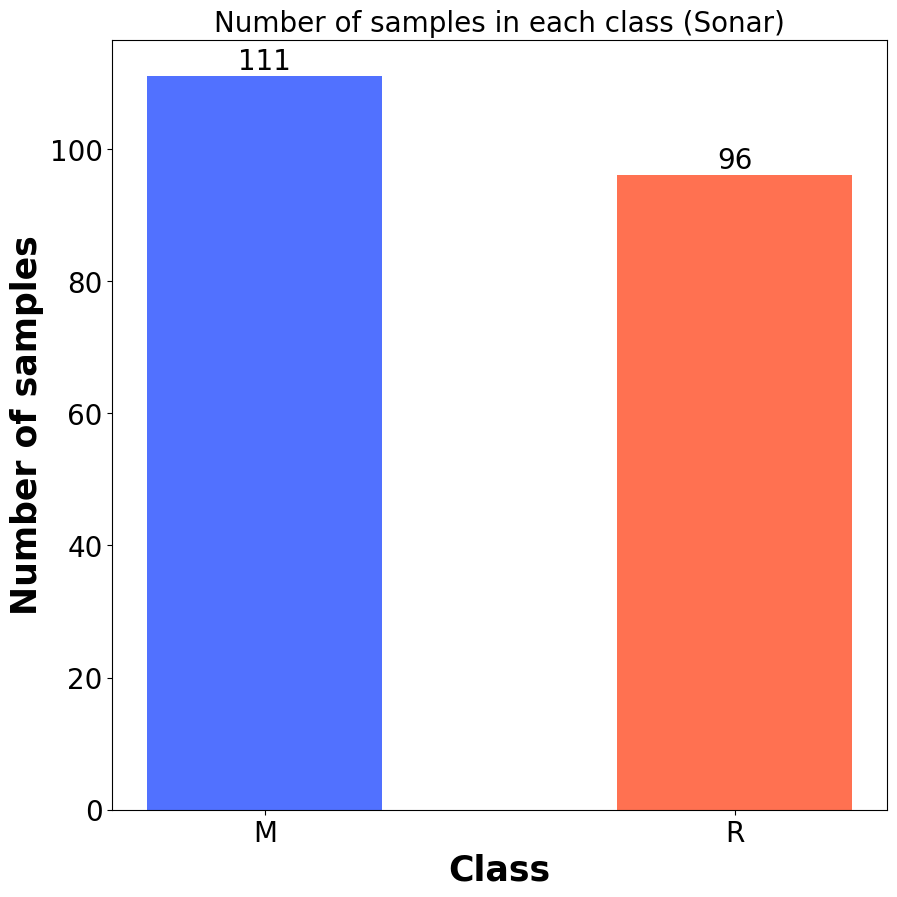

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(sample_number.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Number of samples in each class (Sonar)", fontsize=20)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + "sample/" + data_name, dpi=300)


## Select prototypes

In [9]:
prototypes_index = []
for class_name in sample_number:
    index_i = np.where(label == class_name)
    index_i = list(index_i[0])
    prototype_index_i = random.sample(index_i, num_prototypes)
    prototypes_index += prototype_index_i
prototypes_index.sort(reverse=True)
prototypes = [(feature[i], label[i]) for i in prototypes_index]
# Remove prototypes from dataset
feature = np.delete(feature, prototypes_index, axis=0)
label = np.delete(label, prototypes_index, axis=0)


### Accuracy

In [10]:
experiment = "experiment_1"

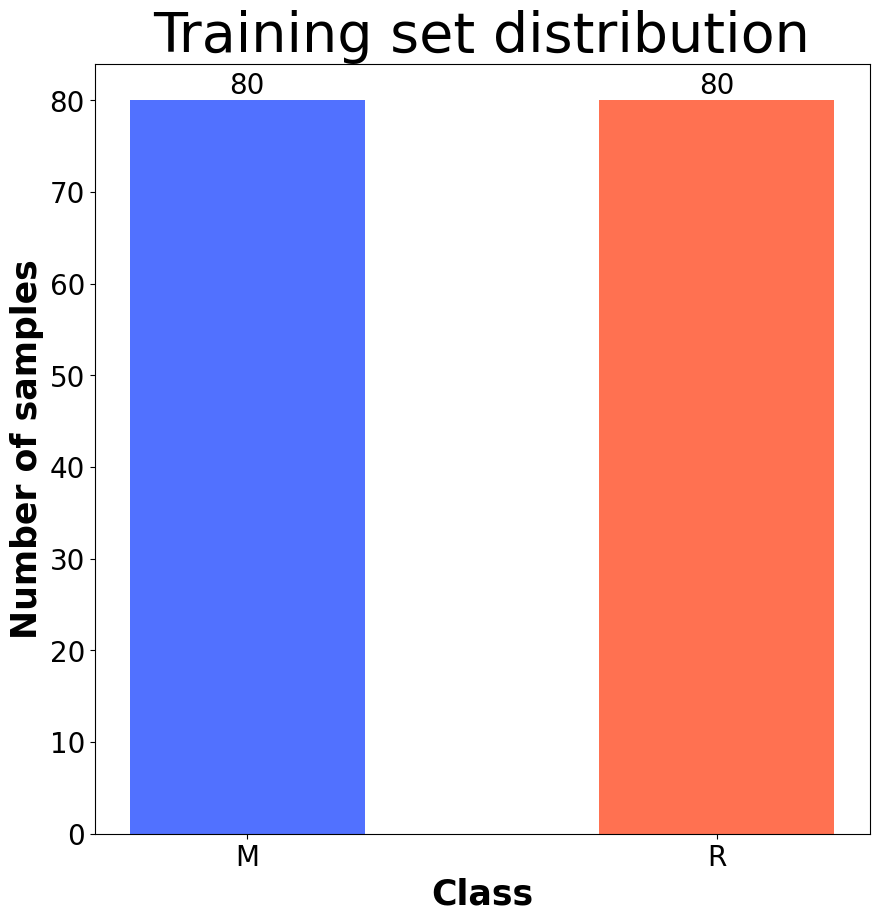

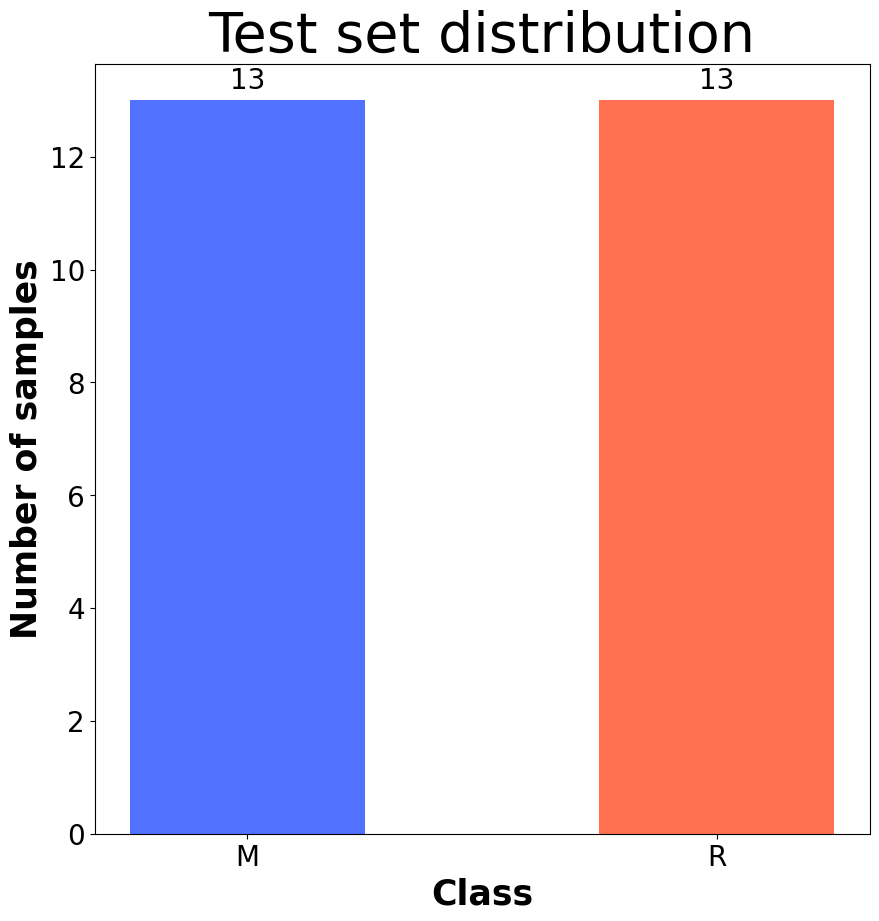

In [11]:
# Select equal amount of normal and abnormal data
data_per_class = min(count) - num_prototypes
test_percentage = 0.15
test_size = int(test_percentage * data_per_class)
train_size = data_per_class - test_size
feature_acc = copy.deepcopy(feature)
label_acc = copy.deepcopy(label)

# Select test set
test_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size)
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_acc = [(feature_acc[i], label_acc[i]) for i in test_index]
random.shuffle(test_set_acc)
unique, counts = np.unique(label_acc[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_acc = np.delete(feature_acc, test_index, axis=0)
label_acc = np.delete(label_acc, test_index, axis=0)

# Select train set
train_index = []
for class_name in sample_number:
    index_i = np.where(label_acc == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size)
    train_index += index_i_sample
train_index.sort(reverse=True)
unique, counts = np.unique(label_acc[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))
train_set_acc = [(feature_acc[i], label_acc[i]) for i in train_index]
random.shuffle(train_set_acc)

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/train_dist.png", dpi=300)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" +
            data_name + "/test_dist.png", dpi=300)


#### Train the Models

In [12]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [13]:
learning_rate = 0.1
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 75.5755, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 71.3147, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 21, Loss: 70.7812, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 31, Loss: 70.5826, Accuracy: 84.62 %, F_1_score: 84.52 %
Epoch: 41, Loss: 70.4640, Accuracy: 84.62 %, F_1_score: 84.52 %
Epoch: 51, Loss: 70.3601, Accuracy: 88.46 %, F_1_score: 88.31 %
Epoch: 61, Loss: 70.2803, Accuracy: 88.46 %, F_1_score: 88.31 %
Epoch: 71, Loss: 70.2247, Accuracy: 88.46 %, F_1_score: 88.31 %
Epoch: 81, Loss: 70.1837, Accuracy: 88.46 %, F_1_score: 88.31 %
Epoch: 91, Loss: 70.1533, Accuracy: 88.46 %, F_1_score: 88.31 %


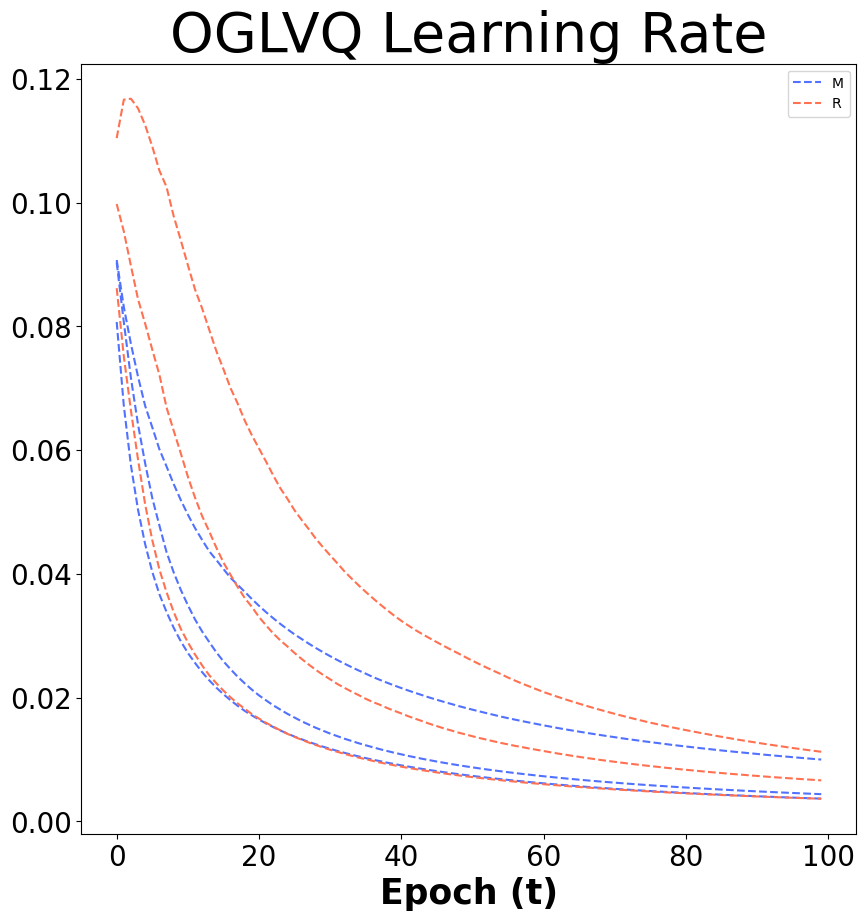

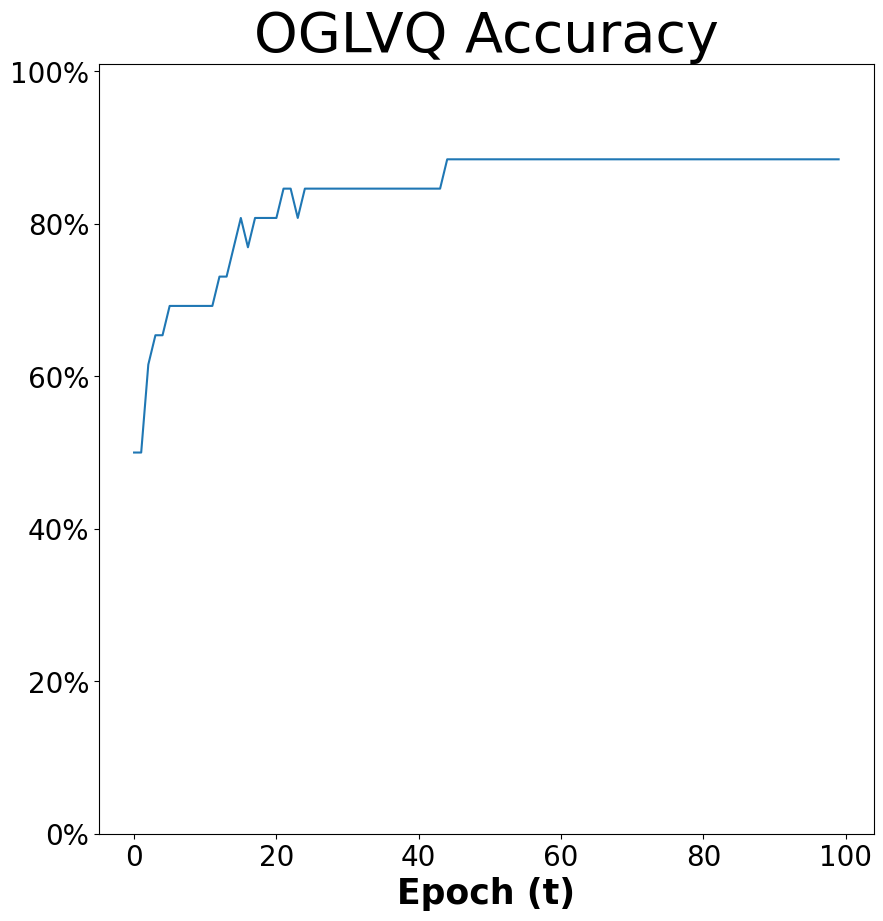

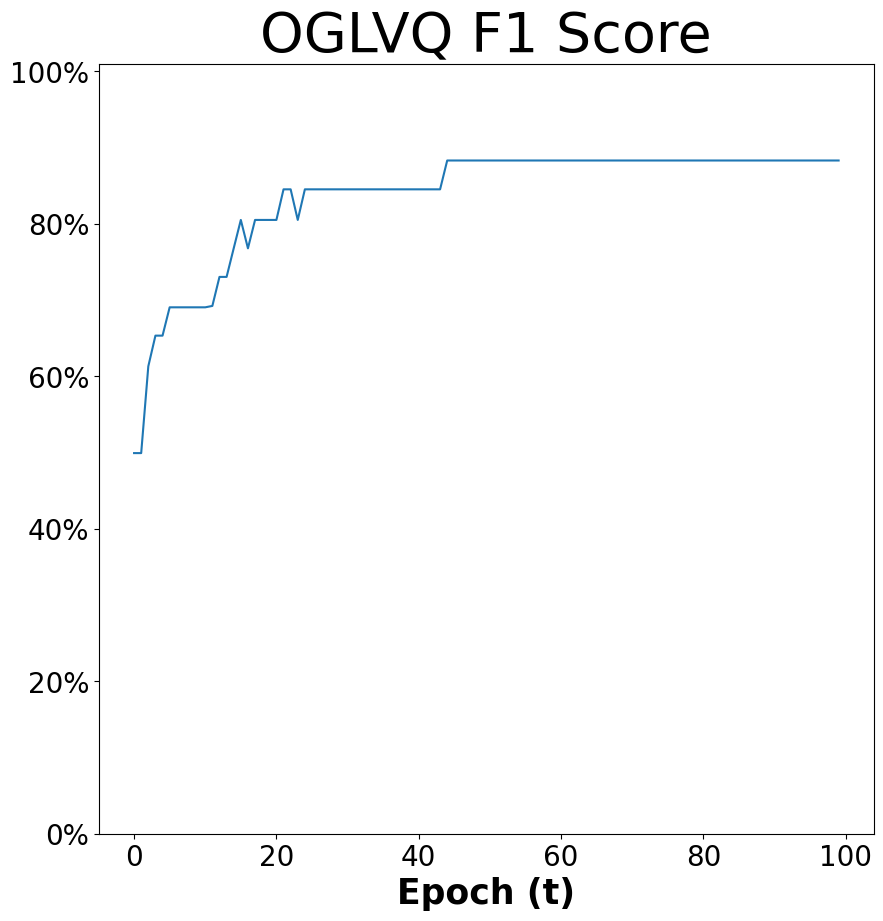

In [14]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [15]:
learning_rate = 0.03
oglvq_acc = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 75.7720, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 72.8172, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 21, Loss: 71.8110, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 31, Loss: 71.3185, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 41, Loss: 71.0476, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 51, Loss: 70.8812, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 61, Loss: 70.7635, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 71, Loss: 70.6673, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 81, Loss: 70.5856, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 91, Loss: 70.5272, Accuracy: 80.77 %, F_1_score: 80.51 %


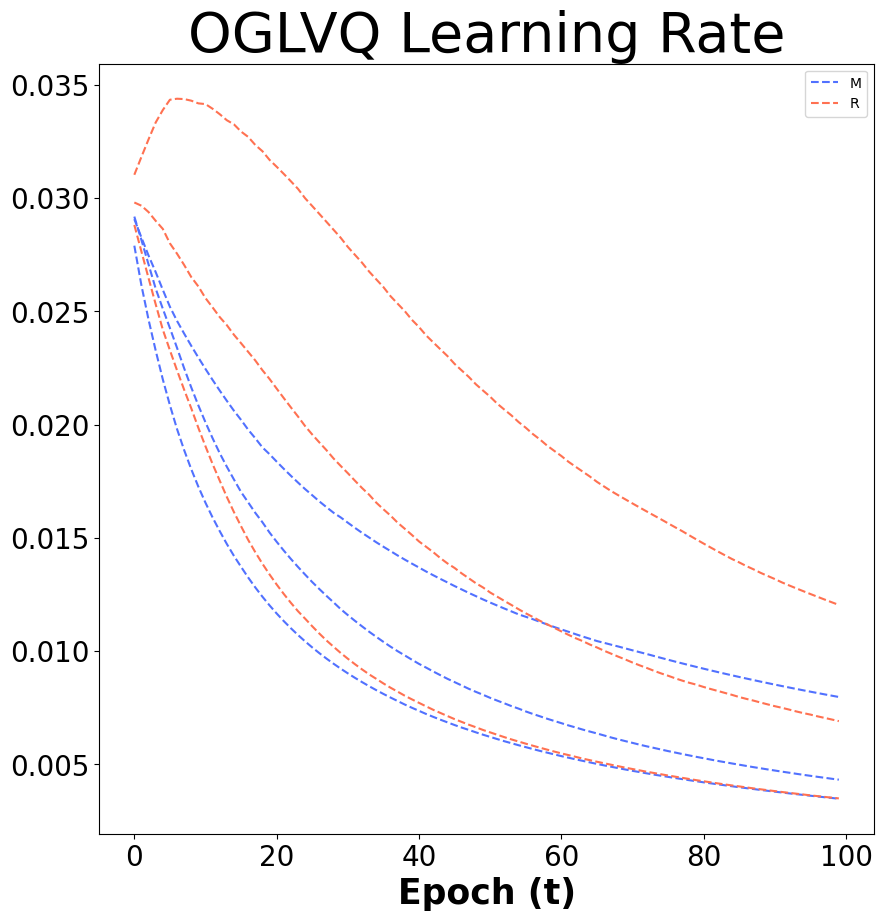

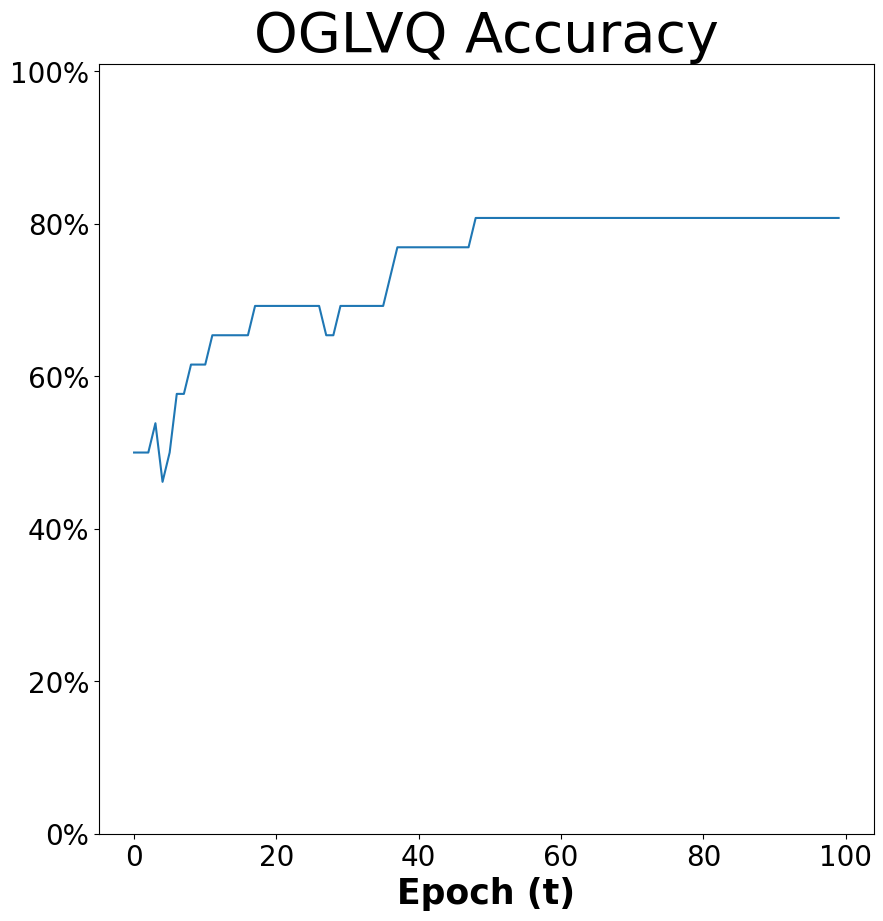

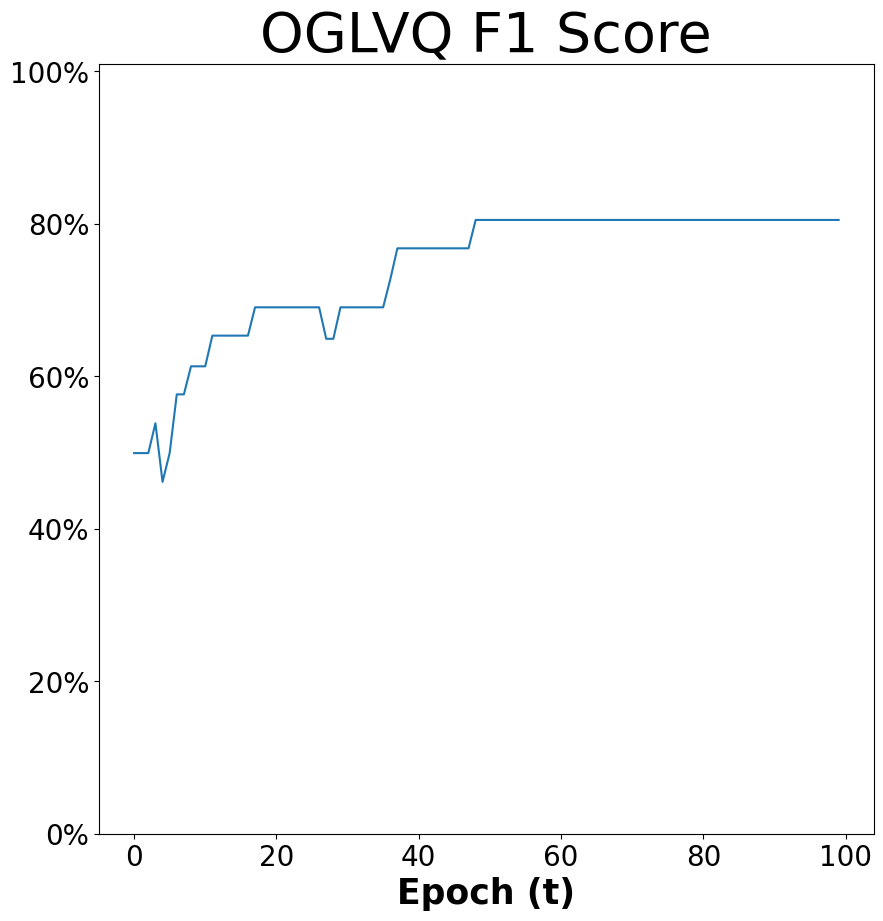

In [16]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [17]:
learning_rate = 0.01
oglvq_acc = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_acc.train(
    num_epochs, train_set_acc, test_set_acc, sample_number=train_dist
)

Epoch: 1, Loss: 75.8383, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 74.4732, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 73.4812, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 31, Loss: 72.8079, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 41, Loss: 72.3568, Accuracy: 65.38 %, F_1_score: 65.33 %
Epoch: 51, Loss: 72.0308, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 61, Loss: 71.7829, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 71, Loss: 71.5852, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 81, Loss: 71.4232, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 91, Loss: 71.2912, Accuracy: 65.38 %, F_1_score: 64.92 %


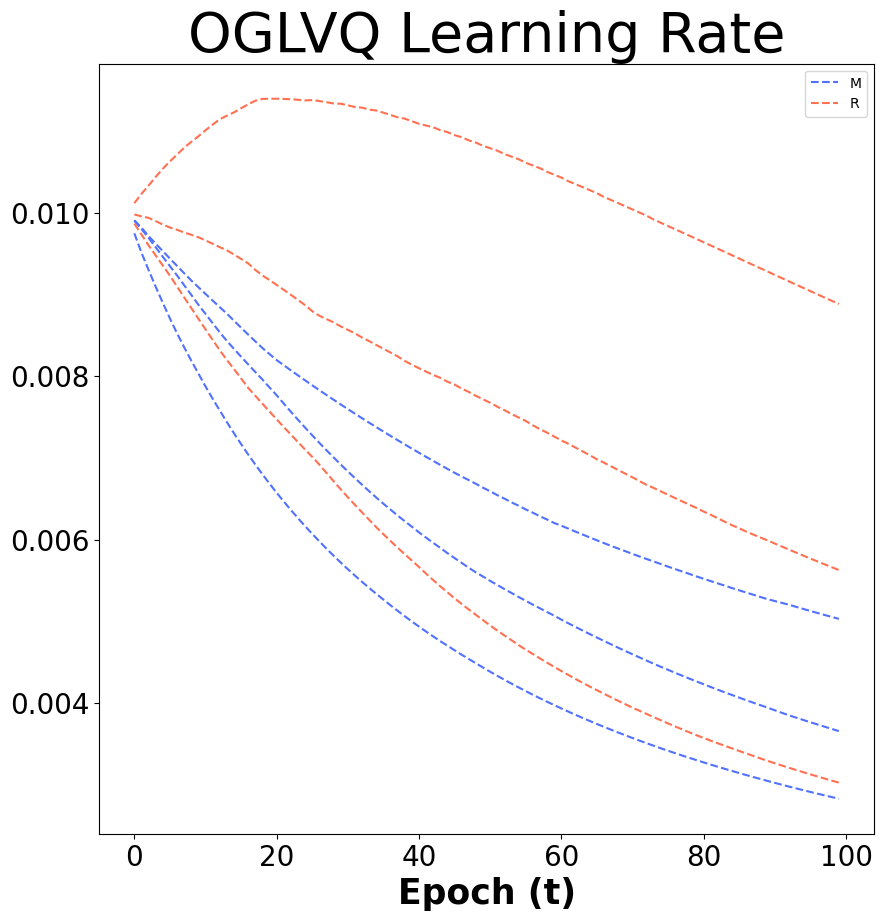

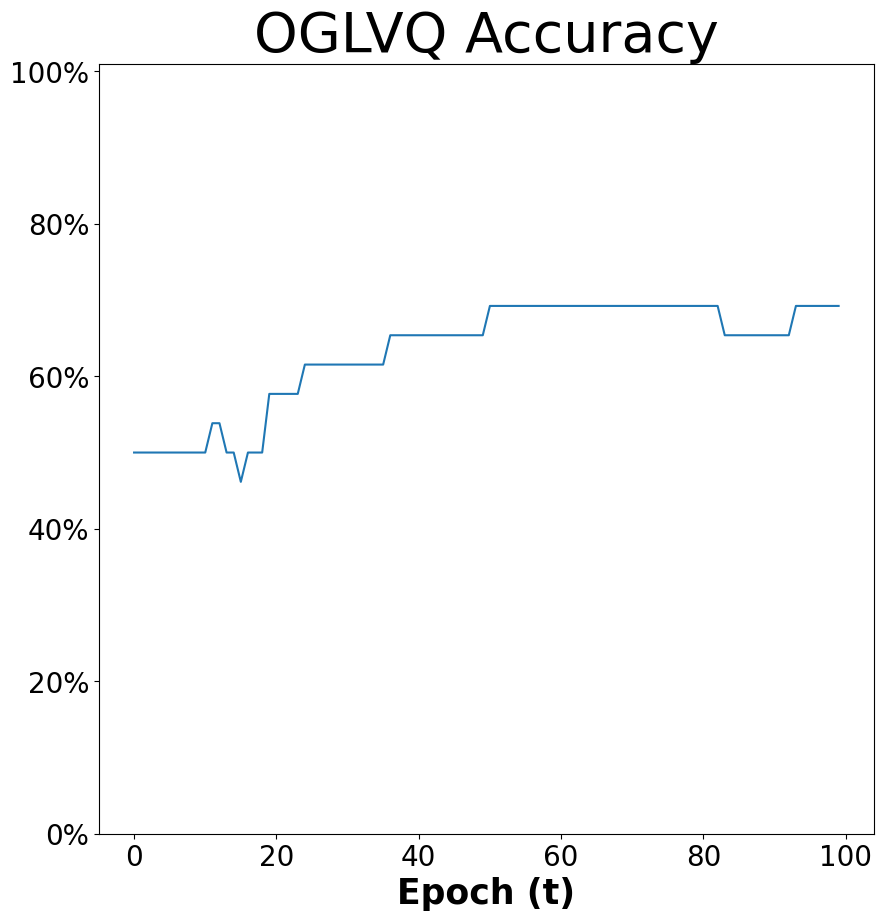

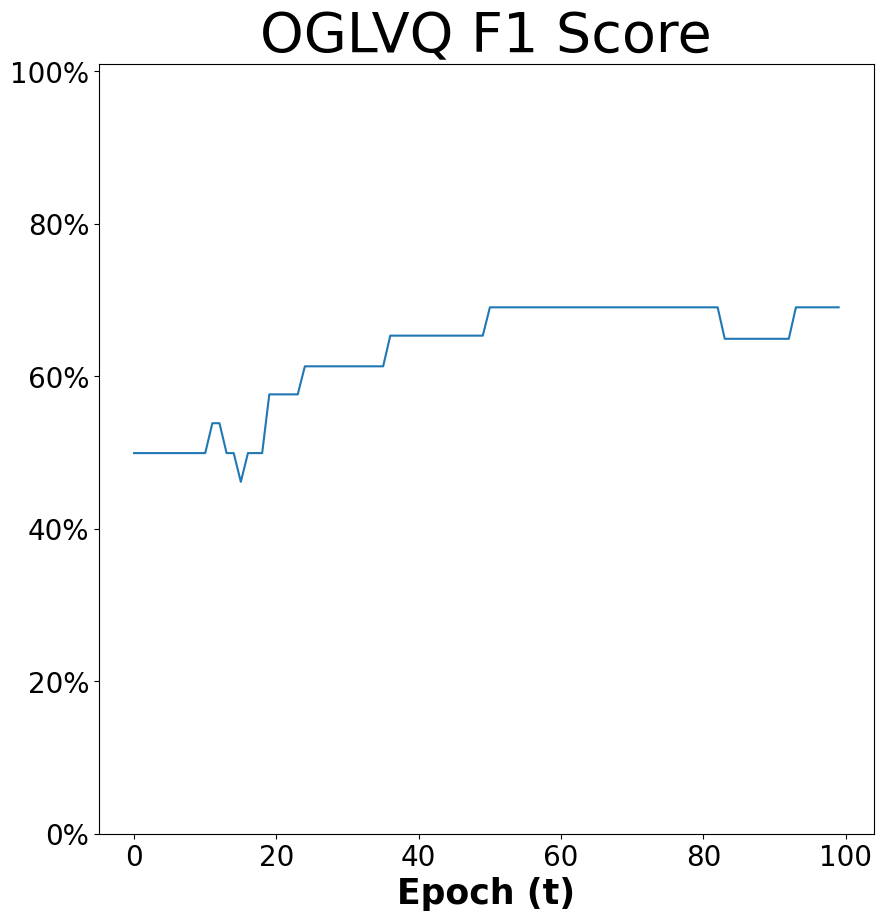

In [18]:
save_figs(oglvq_acc, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [19]:
learning_rate = 0.1
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4734, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 11, Loss: 0.4582, Accuracy: 50.00 %, F_1_score: 43.19 %
Epoch: 21, Loss: 0.4693, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 31, Loss: 0.4716, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 41, Loss: 0.4736, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 51, Loss: 0.4738, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 61, Loss: 0.4743, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 71, Loss: 0.4731, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 81, Loss: 0.4735, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 91, Loss: 0.4738, Accuracy: 50.00 %, F_1_score: 33.33 %


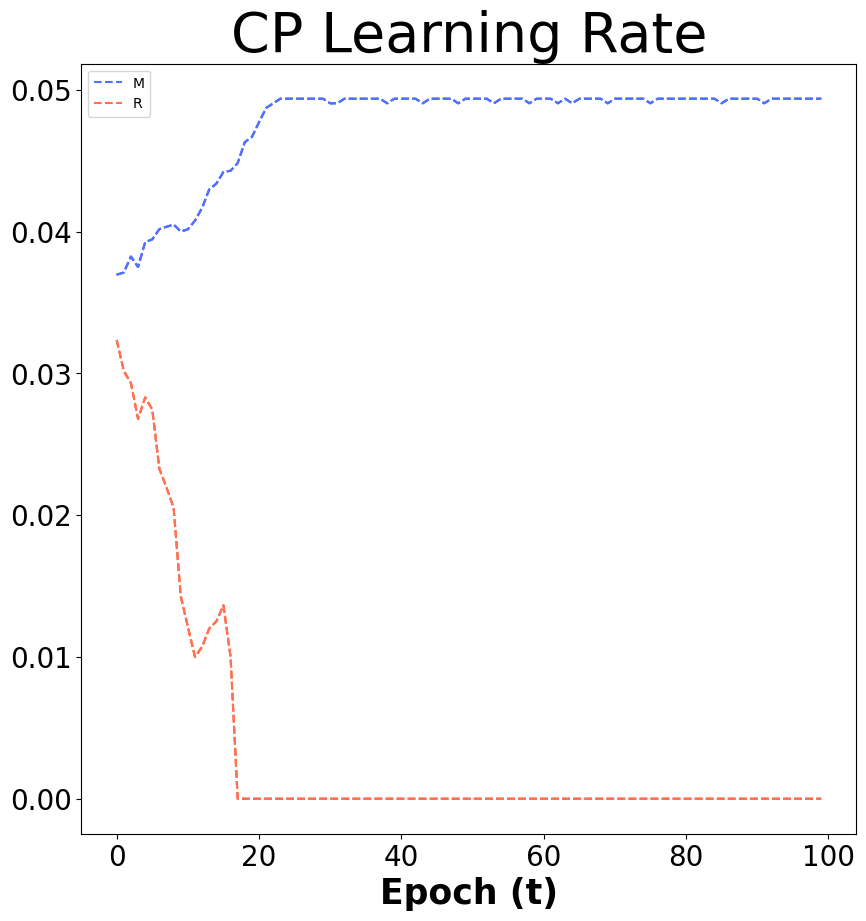

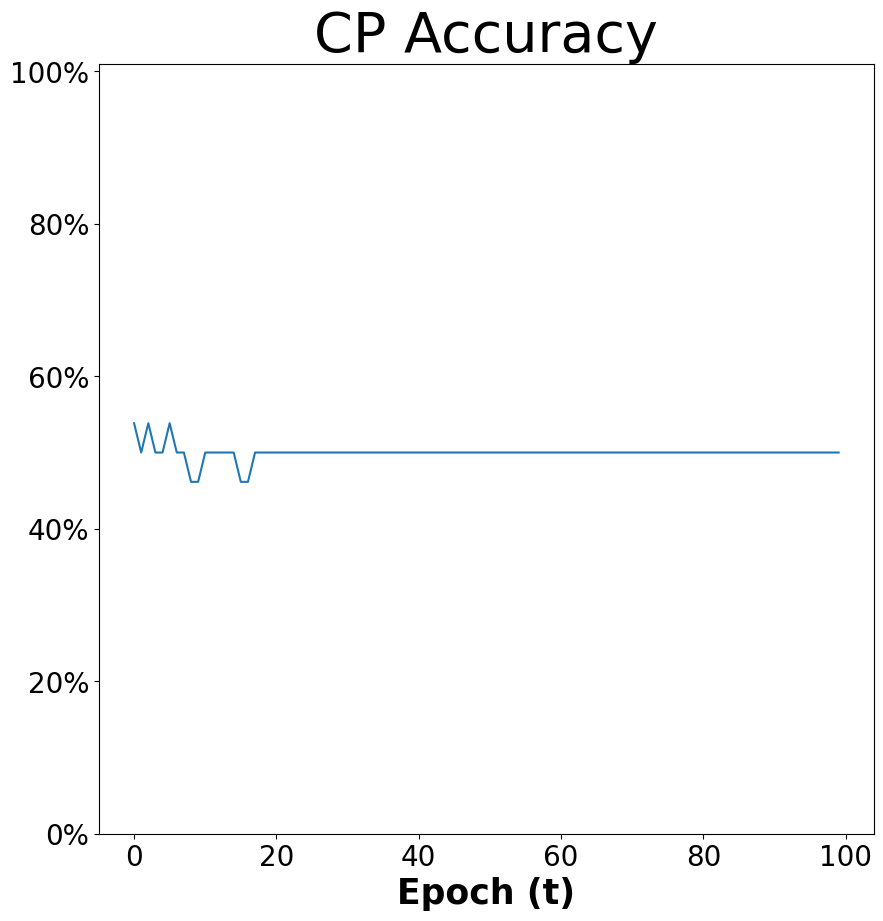

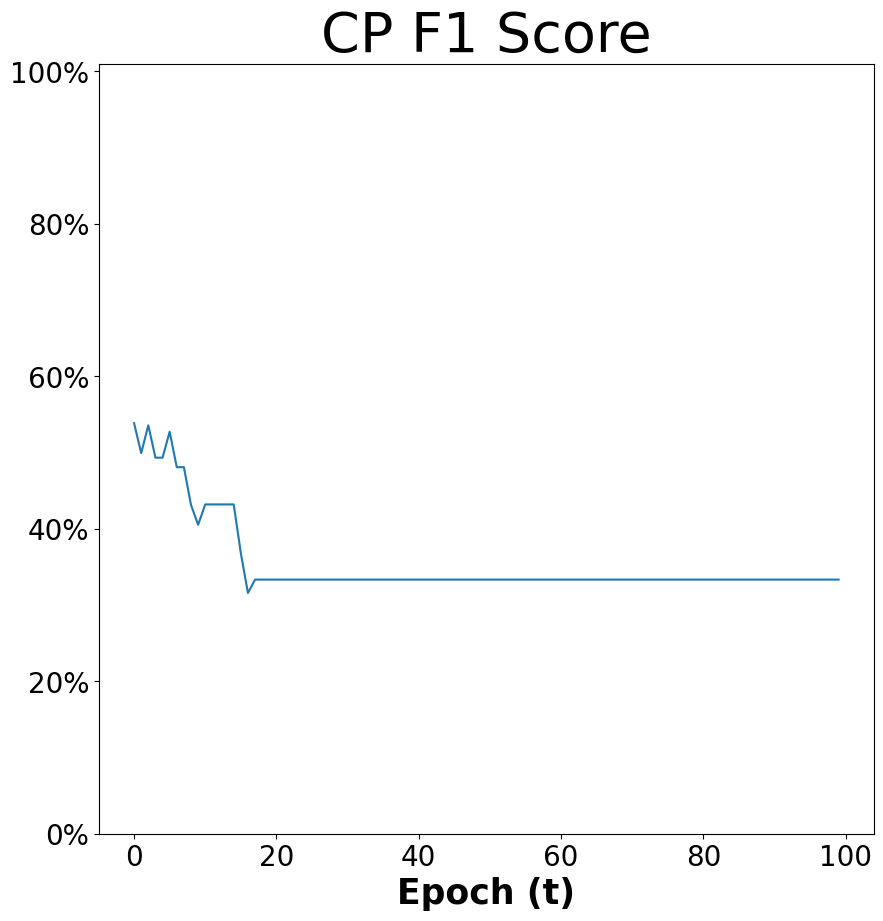

In [20]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [21]:
learning_rate = 0.03
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4739, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4650, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 21, Loss: 0.4595, Accuracy: 53.85 %, F_1_score: 52.73 %
Epoch: 31, Loss: 0.4580, Accuracy: 46.15 %, F_1_score: 40.52 %
Epoch: 41, Loss: 0.4595, Accuracy: 50.00 %, F_1_score: 43.19 %
Epoch: 51, Loss: 0.4613, Accuracy: 46.15 %, F_1_score: 36.81 %
Epoch: 61, Loss: 0.4656, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 71, Loss: 0.4706, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 81, Loss: 0.4744, Accuracy: 50.00 %, F_1_score: 33.33 %
Epoch: 91, Loss: 0.4732, Accuracy: 50.00 %, F_1_score: 33.33 %


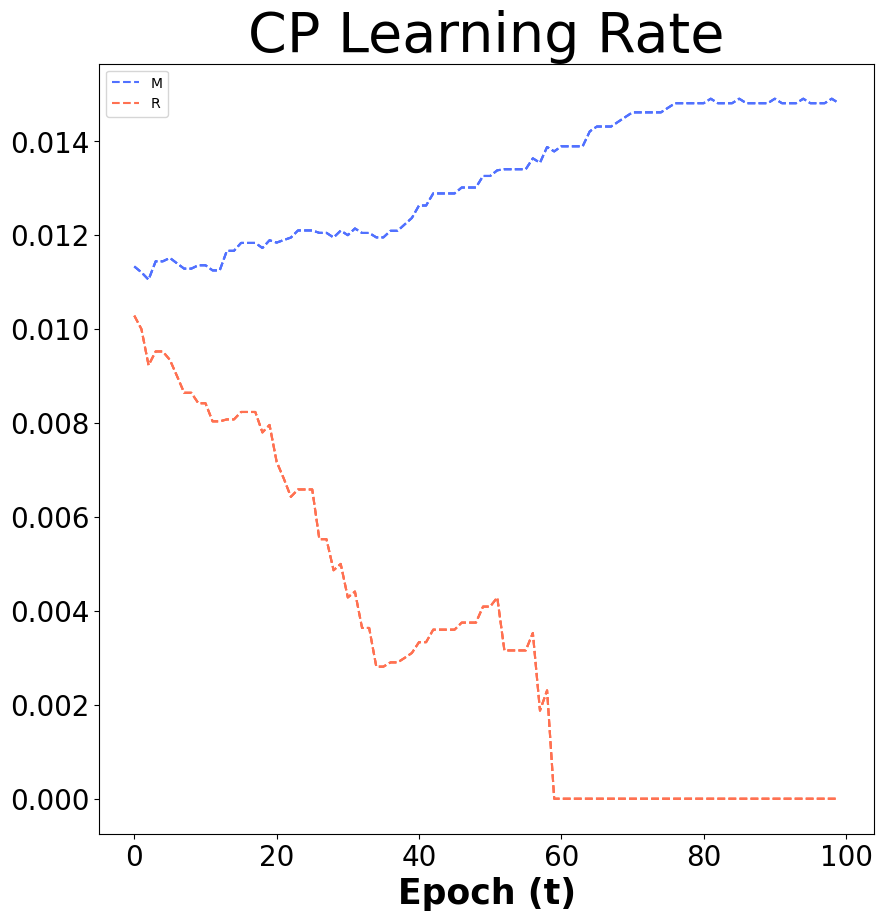

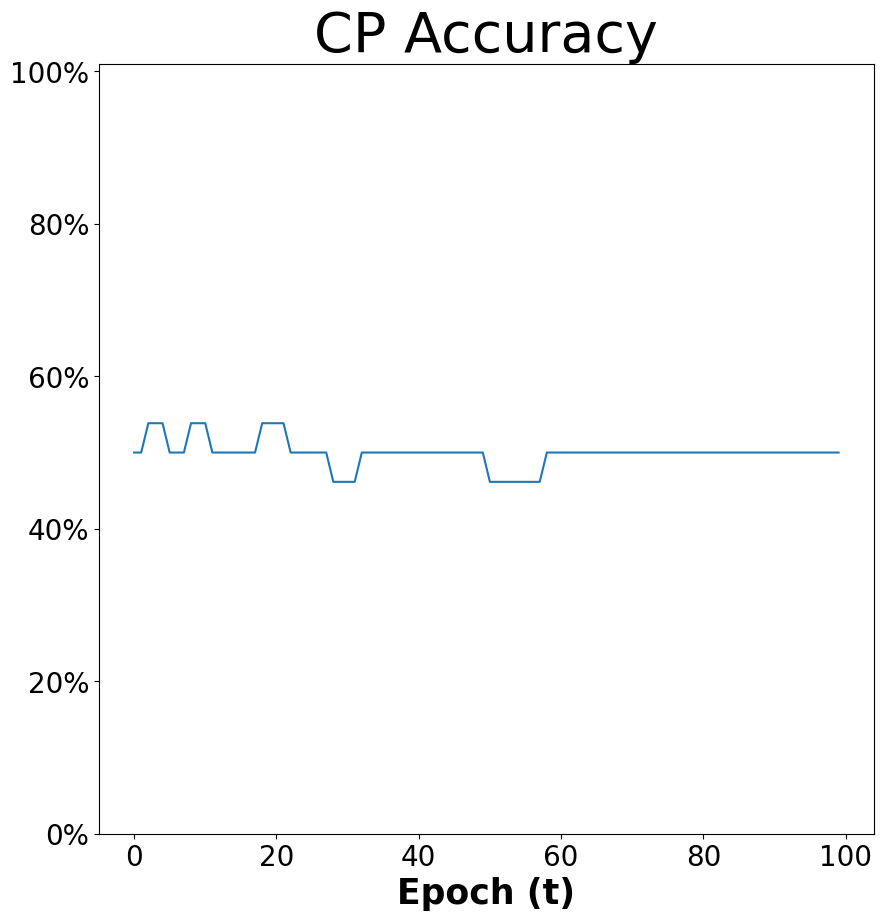

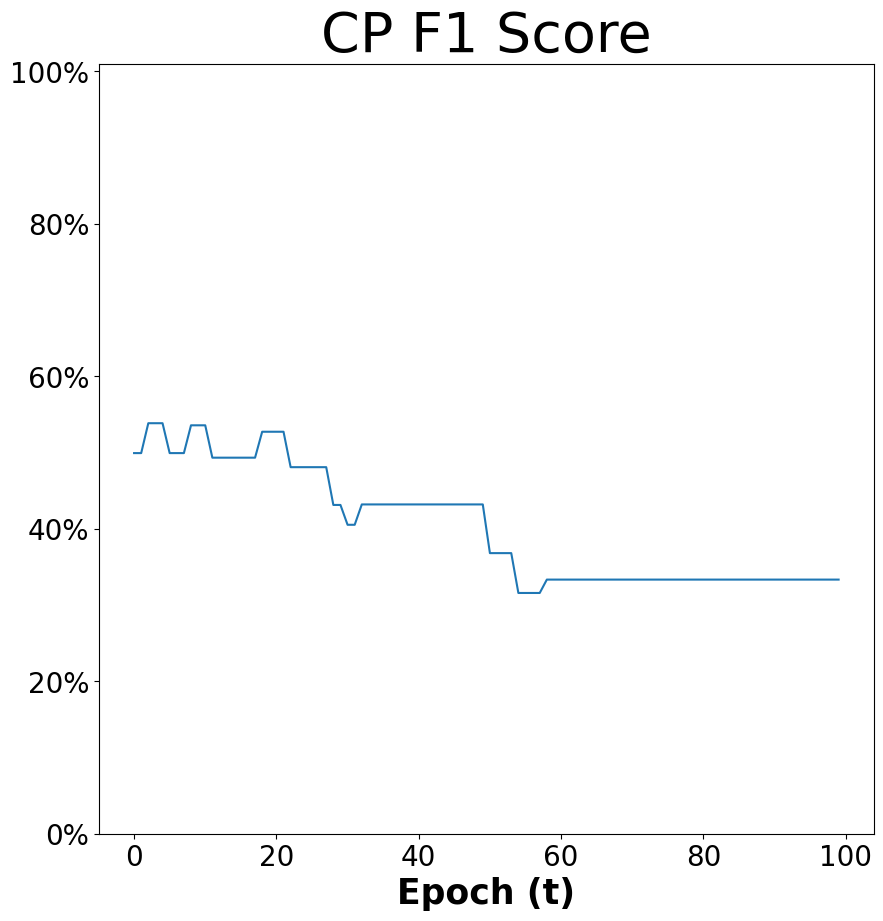

In [22]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [23]:
learning_rate = 0.01
cp_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4741, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4707, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 21, Loss: 0.4677, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 31, Loss: 0.4651, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 41, Loss: 0.4629, Accuracy: 50.00 %, F_1_score: 49.33 %
Epoch: 51, Loss: 0.4610, Accuracy: 50.00 %, F_1_score: 49.33 %
Epoch: 61, Loss: 0.4596, Accuracy: 53.85 %, F_1_score: 52.73 %
Epoch: 71, Loss: 0.4588, Accuracy: 50.00 %, F_1_score: 48.08 %
Epoch: 81, Loss: 0.4582, Accuracy: 50.00 %, F_1_score: 48.08 %
Epoch: 91, Loss: 0.4582, Accuracy: 46.15 %, F_1_score: 40.52 %


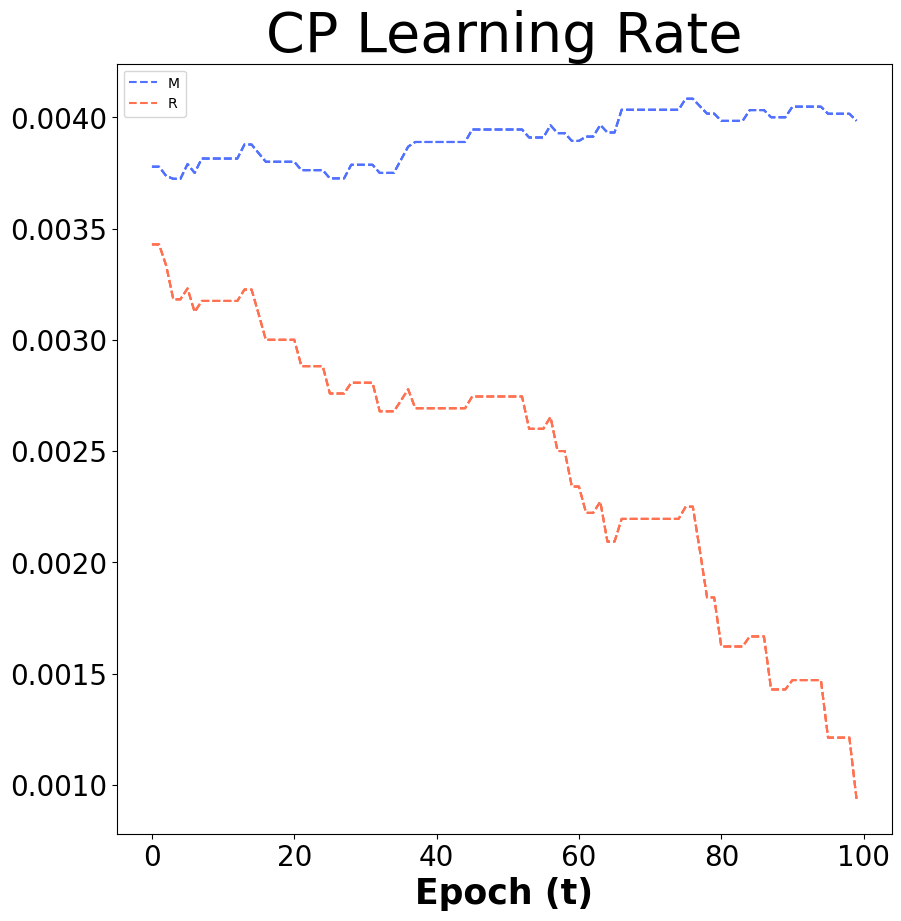

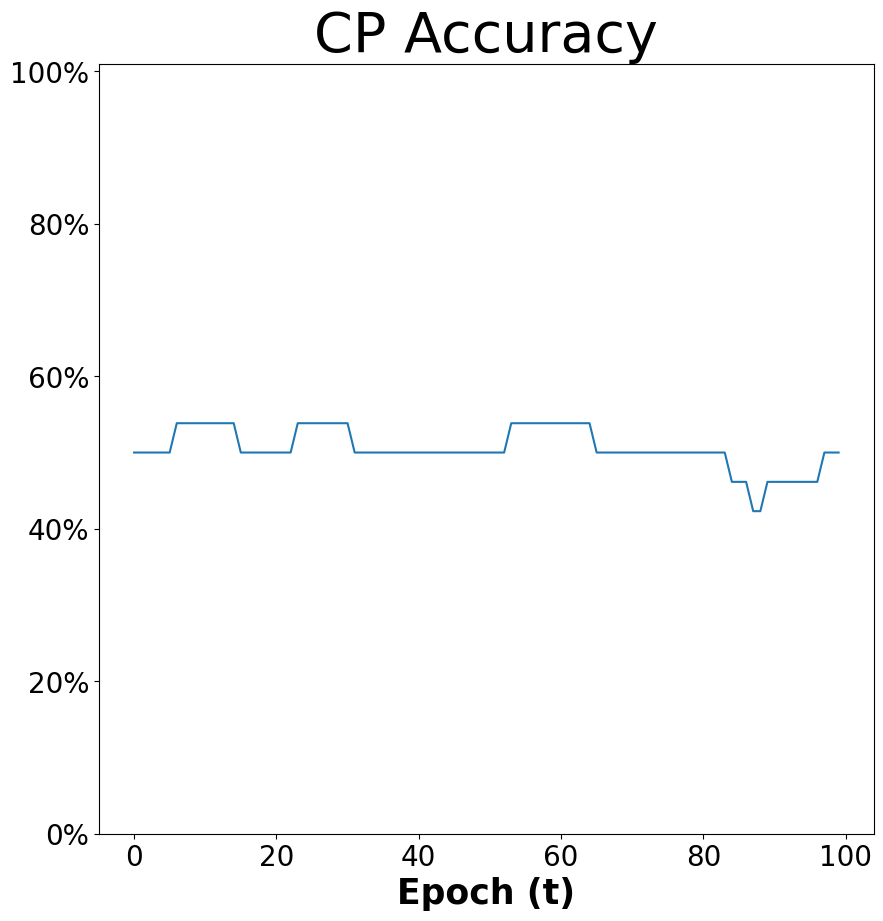

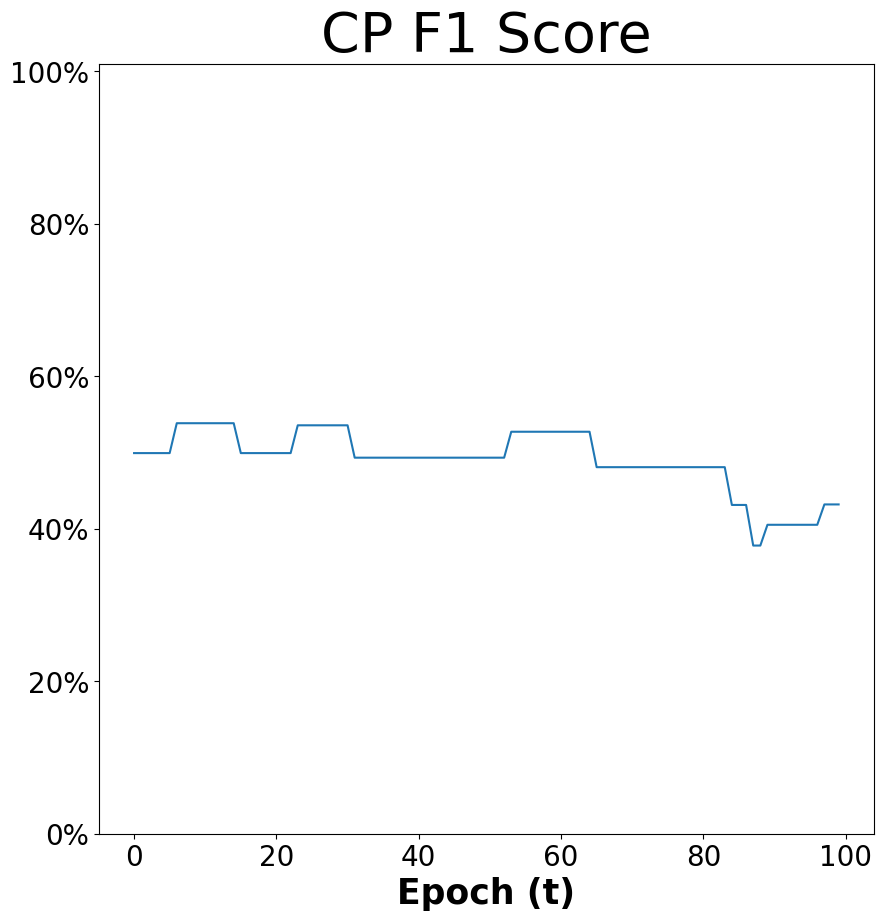

In [24]:
save_figs(cp_glvq_acc, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [25]:
learning_rate = 0.1
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4733, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4507, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 21, Loss: 0.4455, Accuracy: 73.08 %, F_1_score: 73.04 %
Epoch: 31, Loss: 0.4433, Accuracy: 73.08 %, F_1_score: 73.04 %
Epoch: 41, Loss: 0.4424, Accuracy: 80.77 %, F_1_score: 80.74 %
Epoch: 51, Loss: 0.4417, Accuracy: 80.77 %, F_1_score: 80.74 %
Epoch: 61, Loss: 0.4410, Accuracy: 80.77 %, F_1_score: 80.74 %
Epoch: 71, Loss: 0.4404, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 81, Loss: 0.4399, Accuracy: 80.77 %, F_1_score: 80.74 %
Epoch: 91, Loss: 0.4395, Accuracy: 76.92 %, F_1_score: 76.79 %


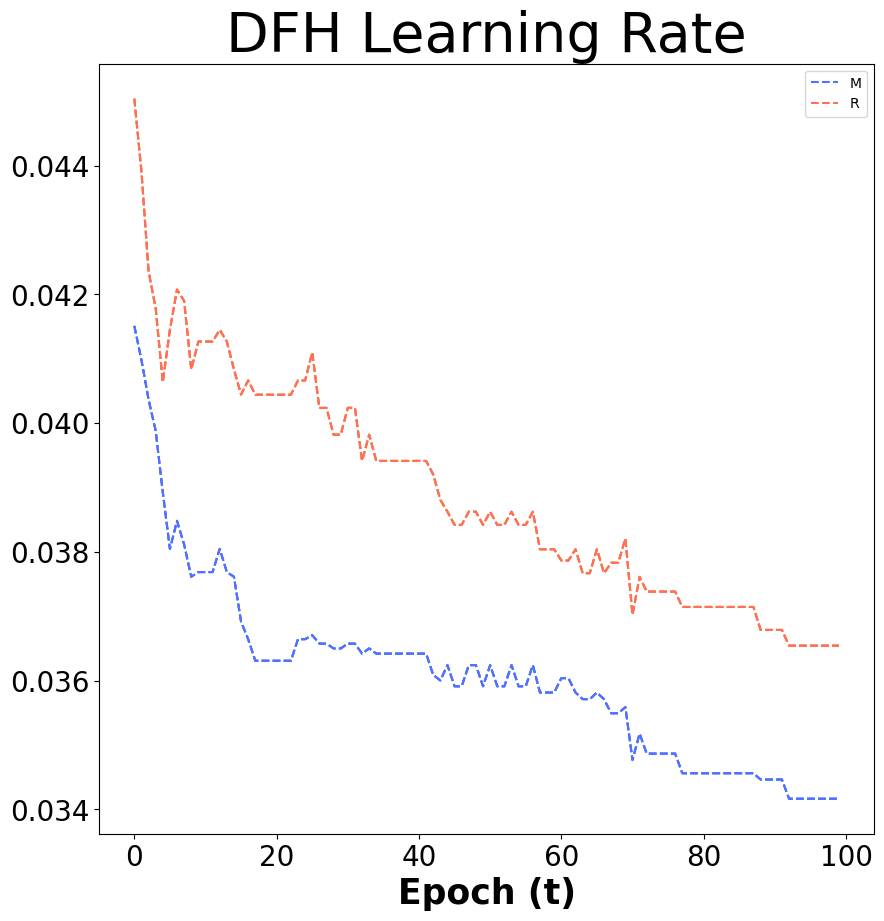

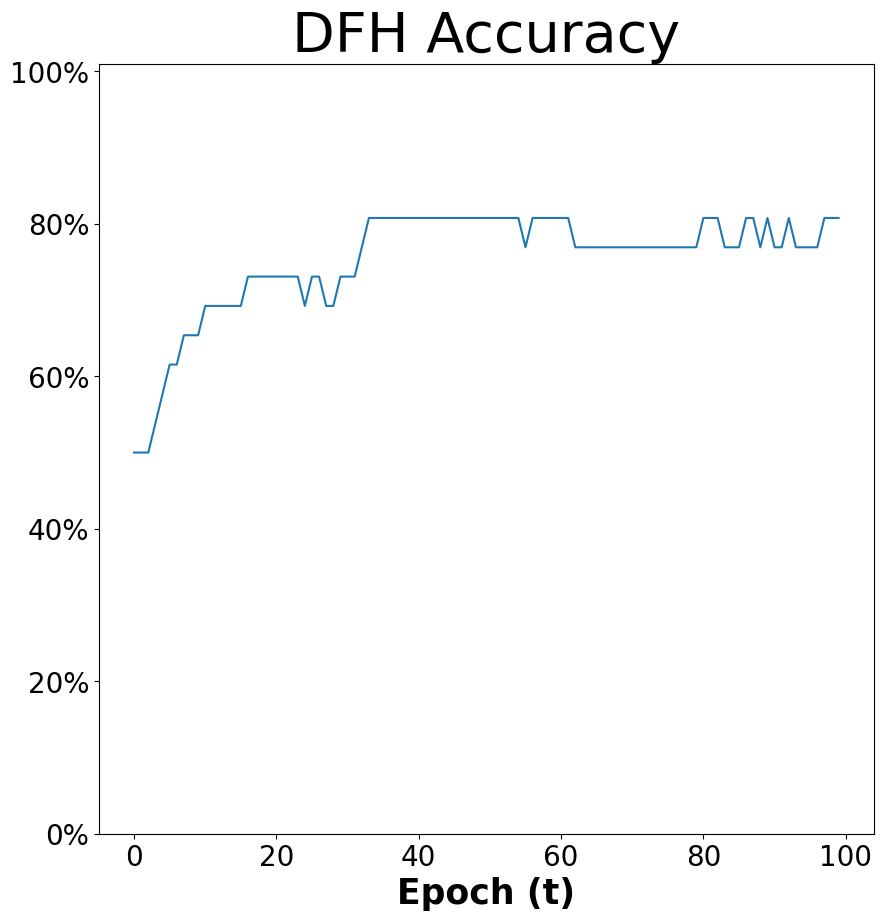

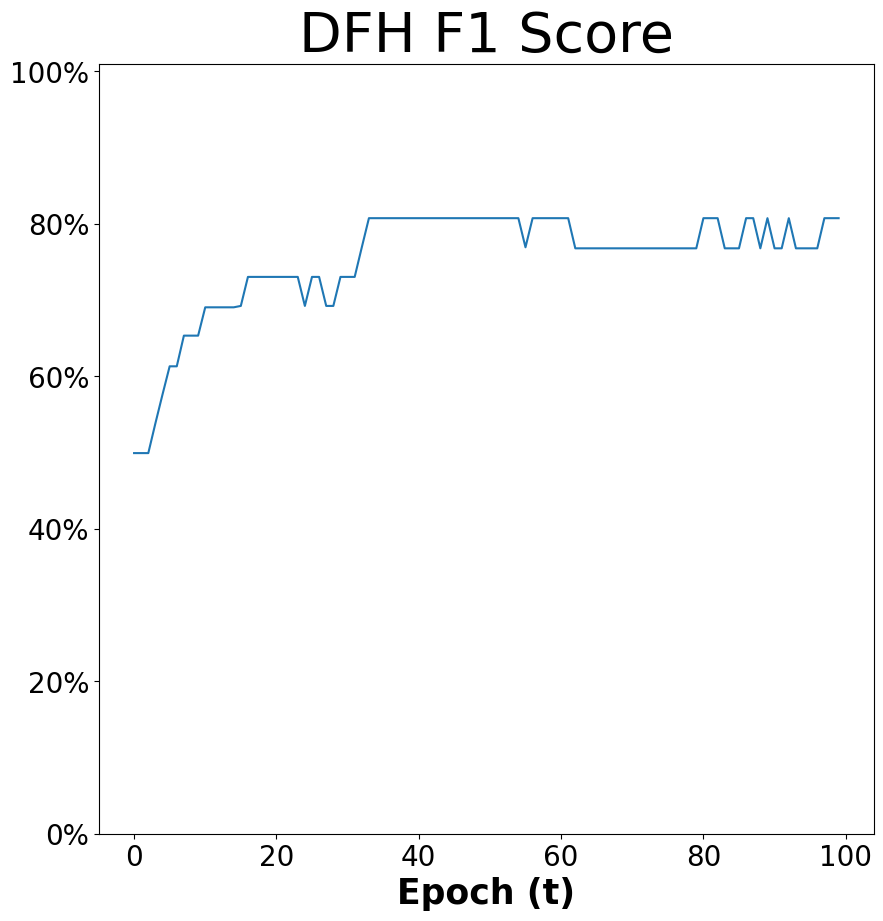

In [26]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [27]:
learning_rate = 0.03
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4739, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4631, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 21, Loss: 0.4558, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 31, Loss: 0.4515, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 41, Loss: 0.4488, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 51, Loss: 0.4470, Accuracy: 69.23 %, F_1_score: 69.23 %
Epoch: 61, Loss: 0.4457, Accuracy: 69.23 %, F_1_score: 69.23 %
Epoch: 71, Loss: 0.4447, Accuracy: 69.23 %, F_1_score: 69.23 %
Epoch: 81, Loss: 0.4440, Accuracy: 69.23 %, F_1_score: 69.23 %
Epoch: 91, Loss: 0.4433, Accuracy: 69.23 %, F_1_score: 69.23 %


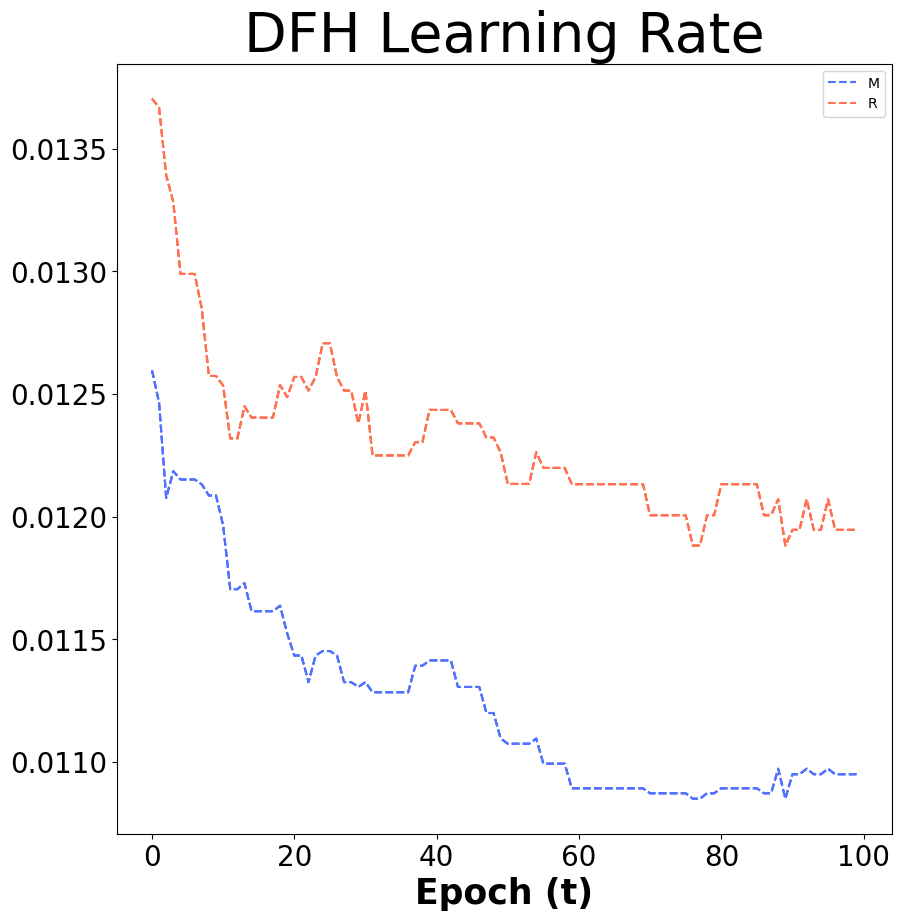

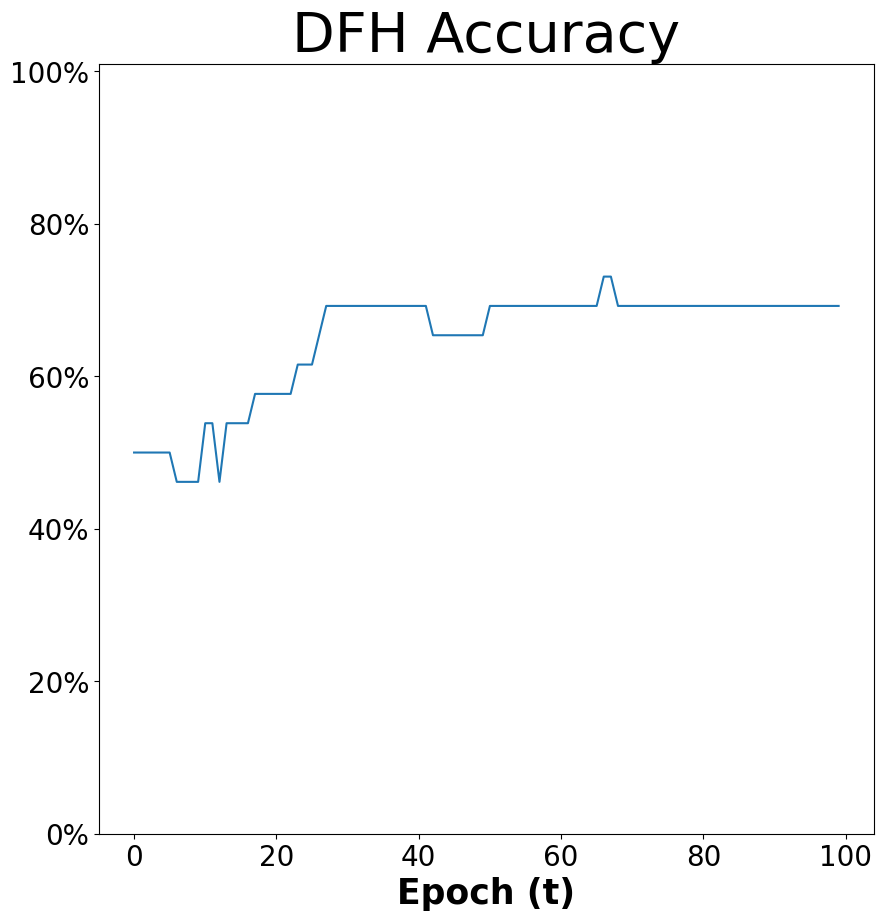

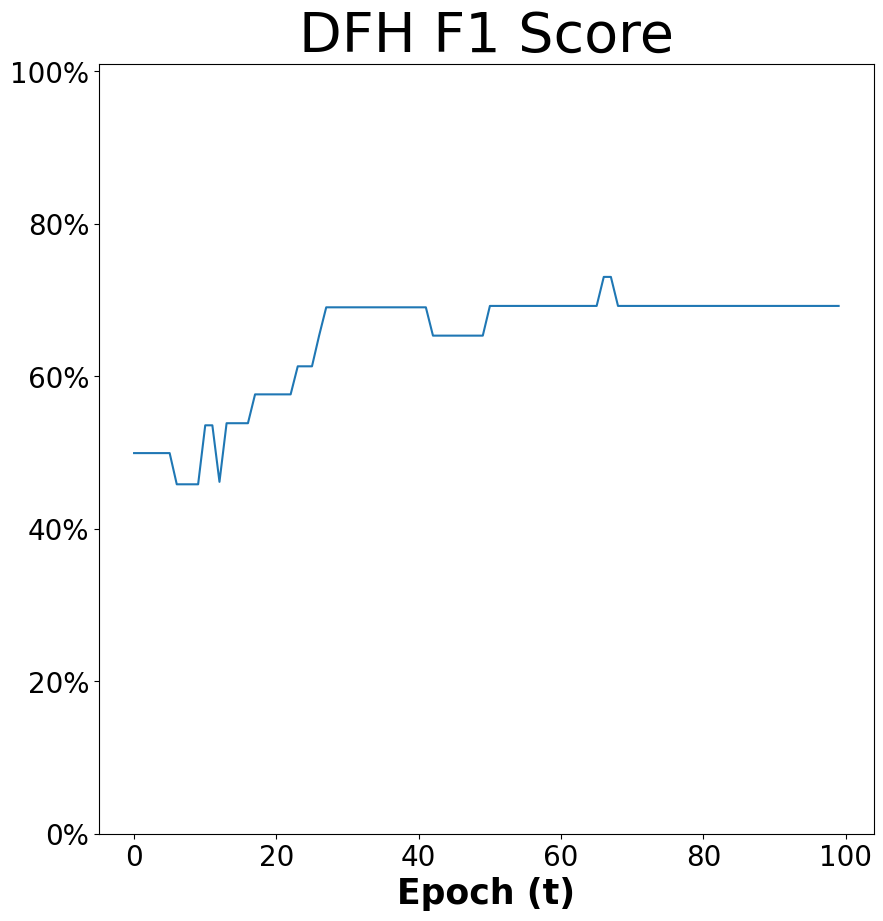

In [28]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [29]:
learning_rate = 0.01
dfh_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4741, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4700, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 0.4664, Accuracy: 46.15 %, F_1_score: 45.83 %
Epoch: 31, Loss: 0.4632, Accuracy: 50.00 %, F_1_score: 49.33 %
Epoch: 41, Loss: 0.4603, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 51, Loss: 0.4579, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 61, Loss: 0.4558, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 71, Loss: 0.4541, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 81, Loss: 0.4526, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 91, Loss: 0.4514, Accuracy: 69.23 %, F_1_score: 69.05 %


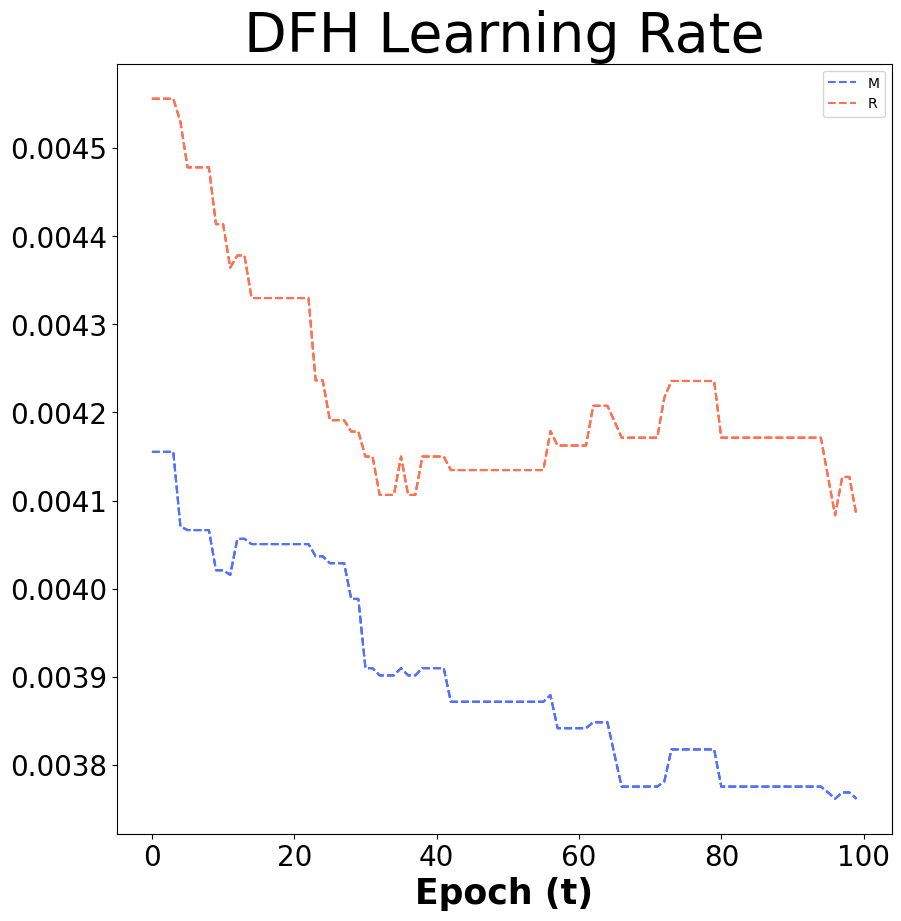

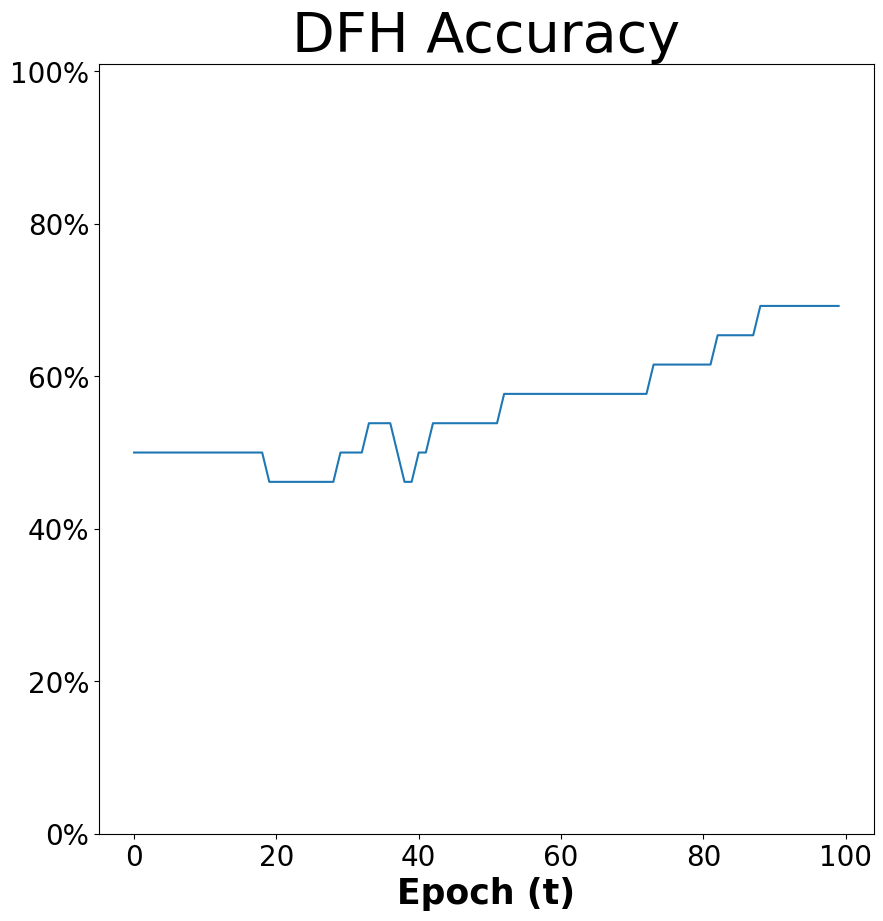

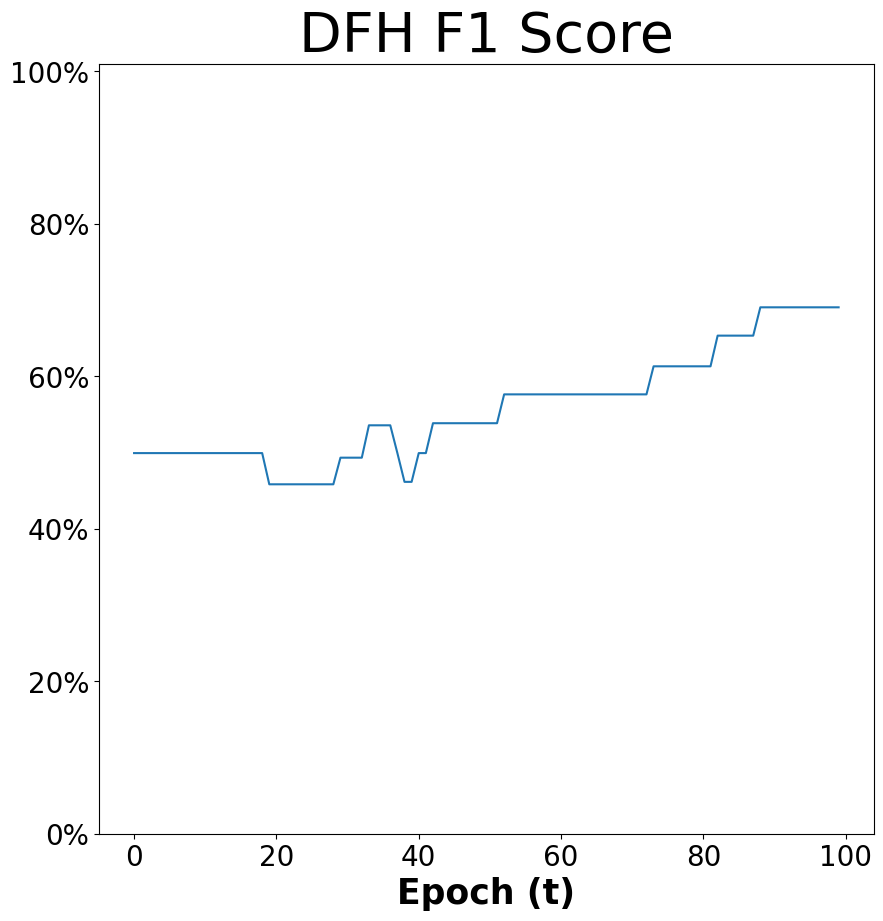

In [30]:
save_figs(dfh_glvq_acc, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [31]:
learning_rate = 0.1
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4730, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4481, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 21, Loss: 0.4439, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 31, Loss: 0.4425, Accuracy: 88.46 %, F_1_score: 88.44 %
Epoch: 41, Loss: 0.4414, Accuracy: 88.46 %, F_1_score: 88.44 %
Epoch: 51, Loss: 0.4404, Accuracy: 88.46 %, F_1_score: 88.44 %
Epoch: 61, Loss: 0.4396, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 71, Loss: 0.4391, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 81, Loss: 0.4388, Accuracy: 88.46 %, F_1_score: 88.44 %
Epoch: 91, Loss: 0.4386, Accuracy: 92.31 %, F_1_score: 92.26 %


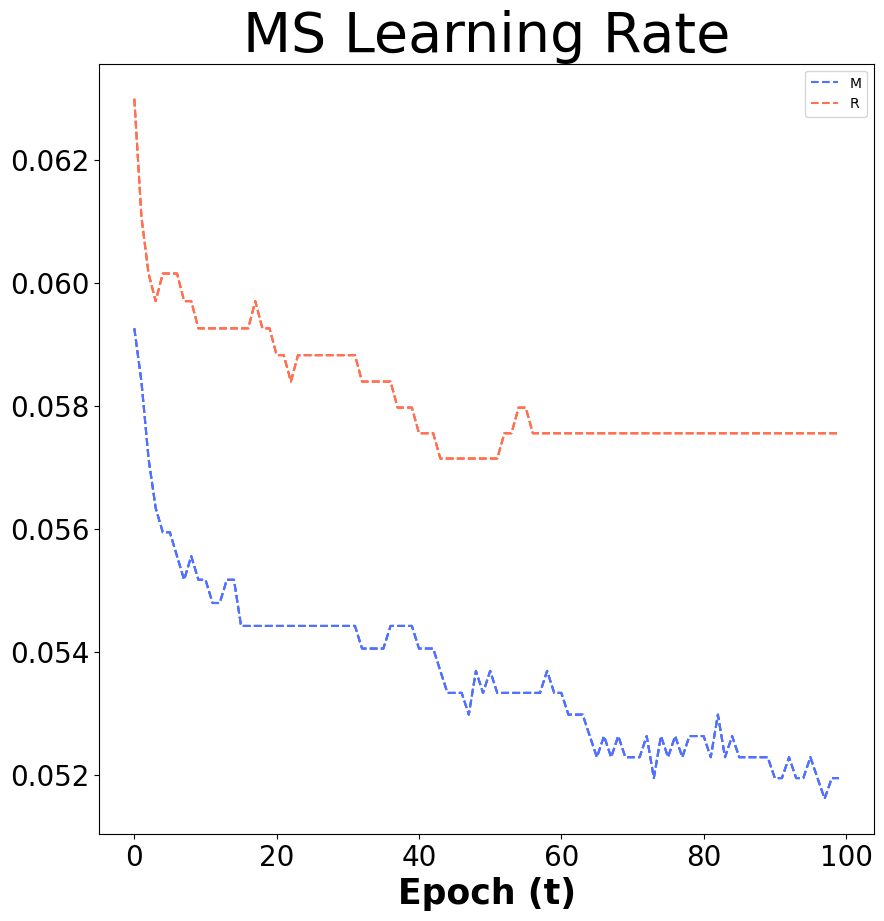

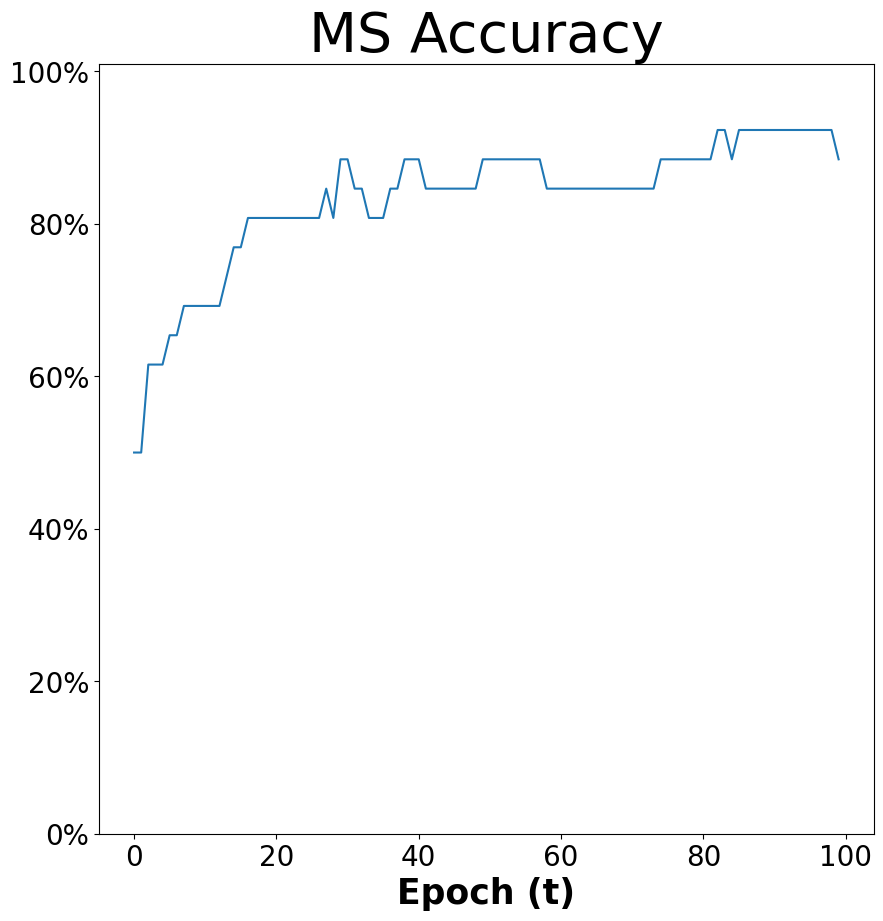

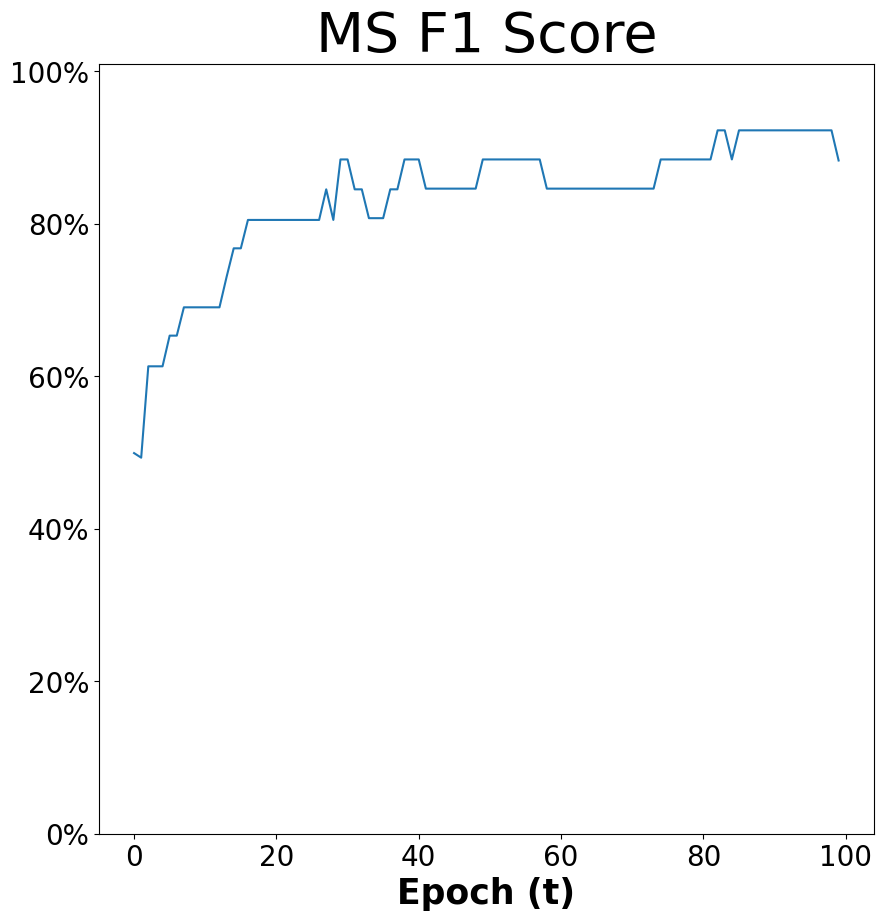

In [32]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [33]:
learning_rate = 0.03
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4738, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4594, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 21, Loss: 0.4519, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 31, Loss: 0.4481, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 41, Loss: 0.4457, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 51, Loss: 0.4441, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 61, Loss: 0.4430, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 71, Loss: 0.4423, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 81, Loss: 0.4417, Accuracy: 80.77 %, F_1_score: 80.51 %
Epoch: 91, Loss: 0.4412, Accuracy: 84.62 %, F_1_score: 84.52 %


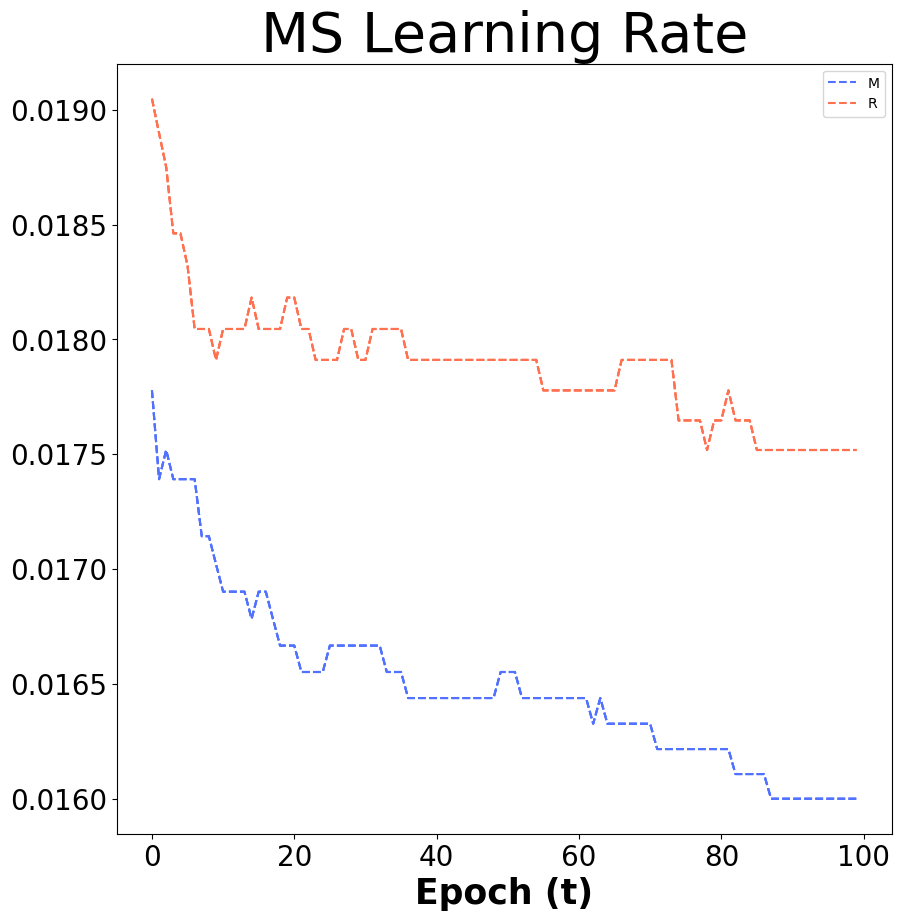

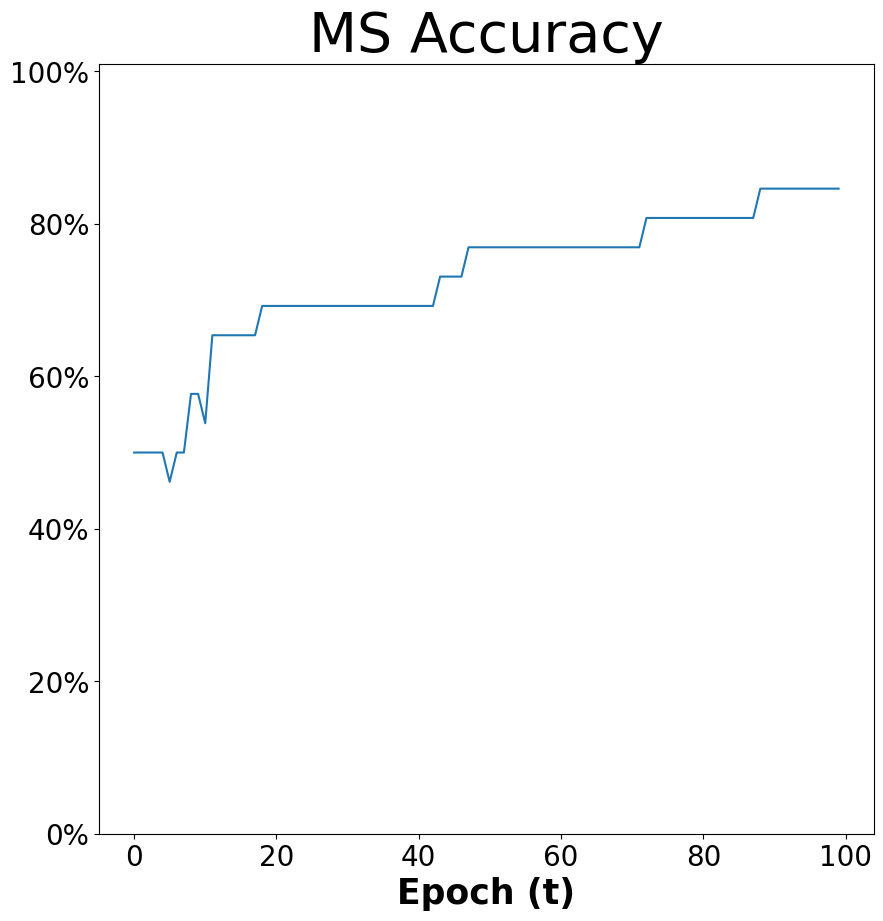

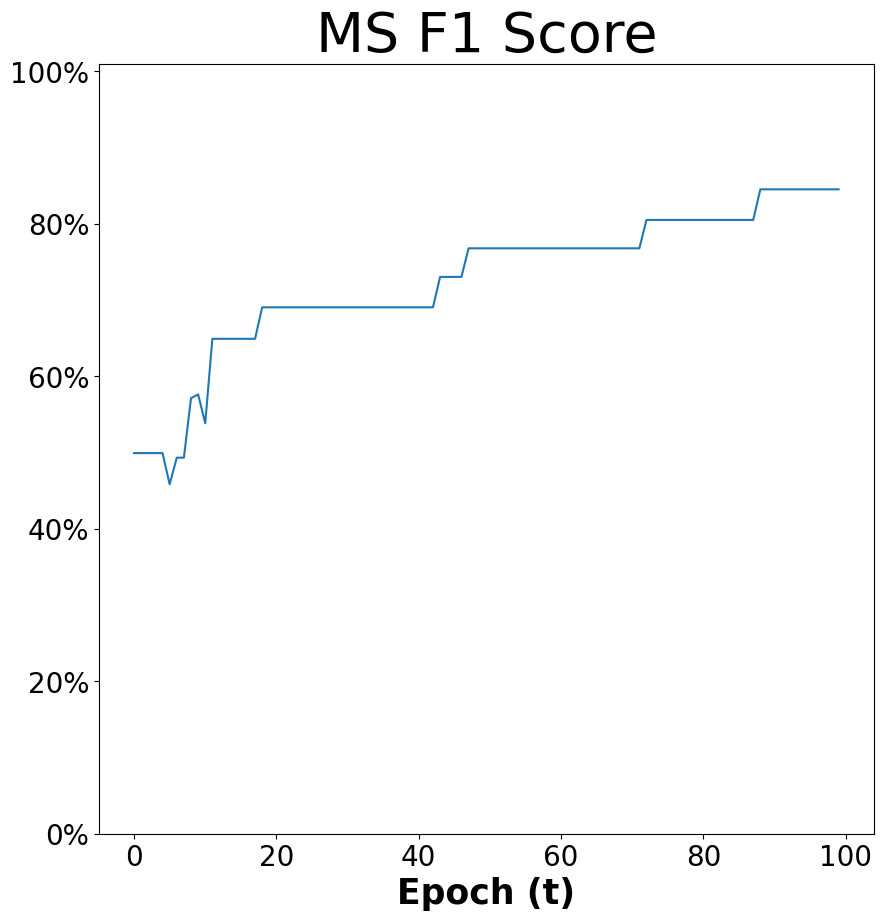

In [34]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [35]:
learning_rate = 0.01
ms_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4741, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4684, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 0.4636, Accuracy: 50.00 %, F_1_score: 49.33 %
Epoch: 31, Loss: 0.4595, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 41, Loss: 0.4562, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 51, Loss: 0.4537, Accuracy: 65.38 %, F_1_score: 64.92 %
Epoch: 61, Loss: 0.4518, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 71, Loss: 0.4502, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 81, Loss: 0.4489, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 91, Loss: 0.4479, Accuracy: 69.23 %, F_1_score: 69.05 %


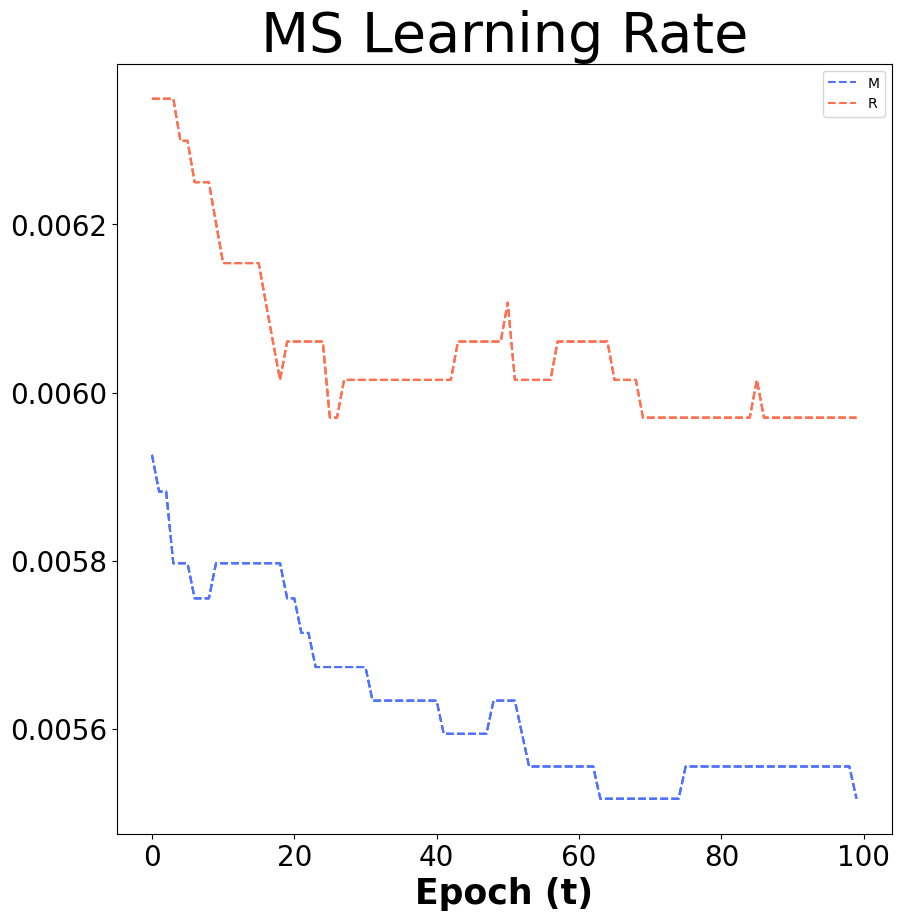

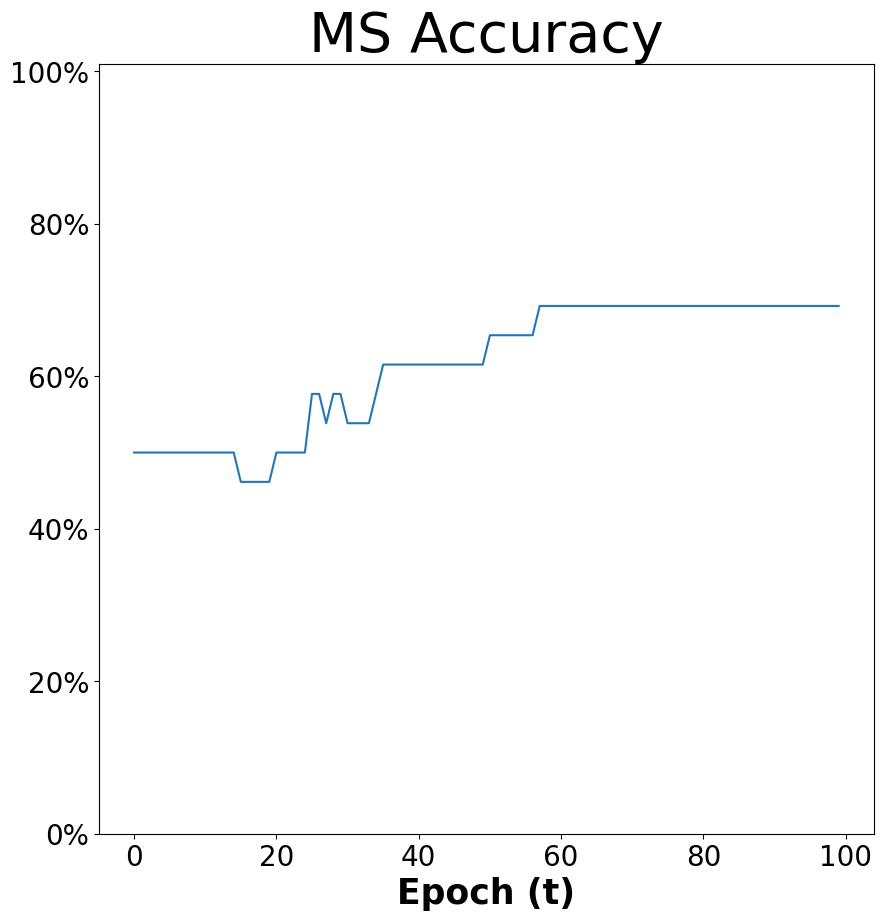

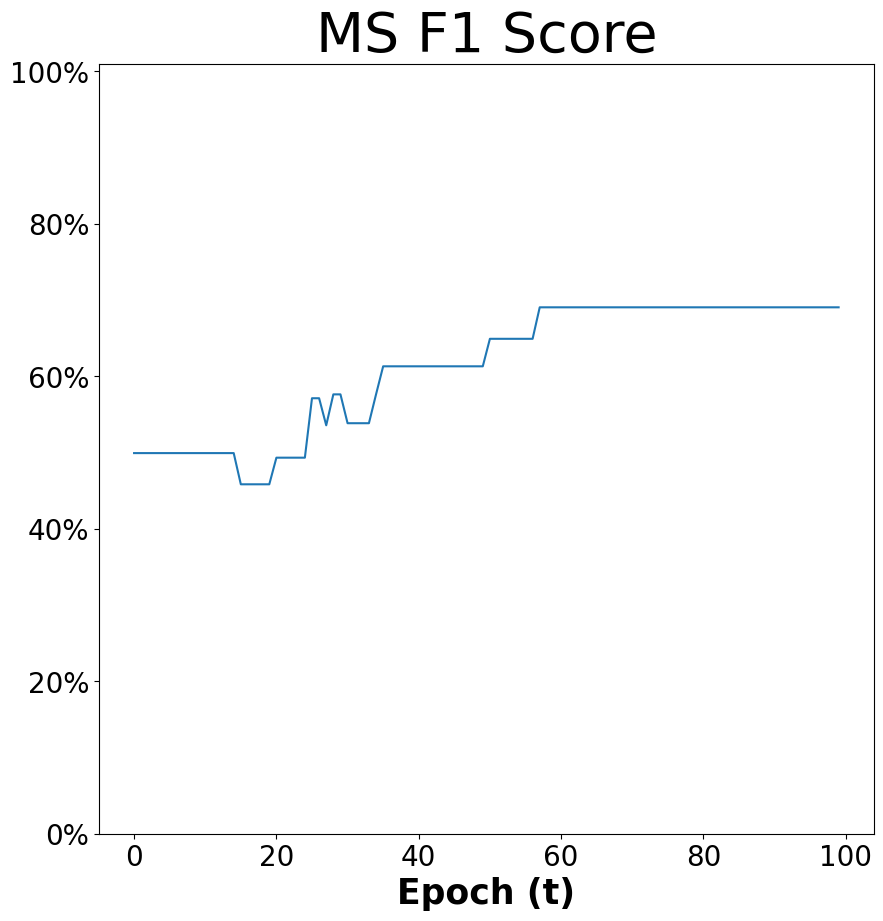

In [36]:
save_figs(ms_glvq_acc, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [37]:
learning_rate = 0.1
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4732, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4506, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 21, Loss: 0.4452, Accuracy: 73.08 %, F_1_score: 72.71 %
Epoch: 31, Loss: 0.4433, Accuracy: 69.23 %, F_1_score: 68.48 %
Epoch: 41, Loss: 0.4426, Accuracy: 61.54 %, F_1_score: 59.38 %
Epoch: 51, Loss: 0.4422, Accuracy: 65.38 %, F_1_score: 64.06 %
Epoch: 61, Loss: 0.4418, Accuracy: 69.23 %, F_1_score: 68.48 %
Epoch: 71, Loss: 0.4415, Accuracy: 69.23 %, F_1_score: 68.48 %
Epoch: 81, Loss: 0.4412, Accuracy: 61.54 %, F_1_score: 59.38 %
Epoch: 91, Loss: 0.4409, Accuracy: 61.54 %, F_1_score: 59.38 %


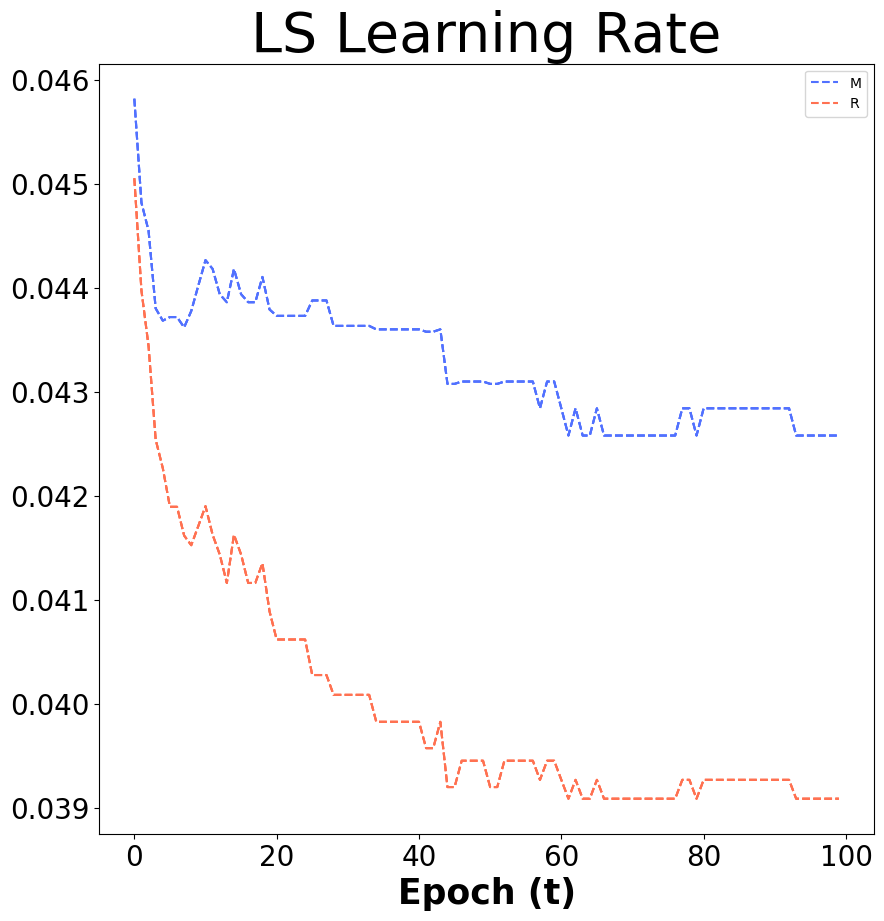

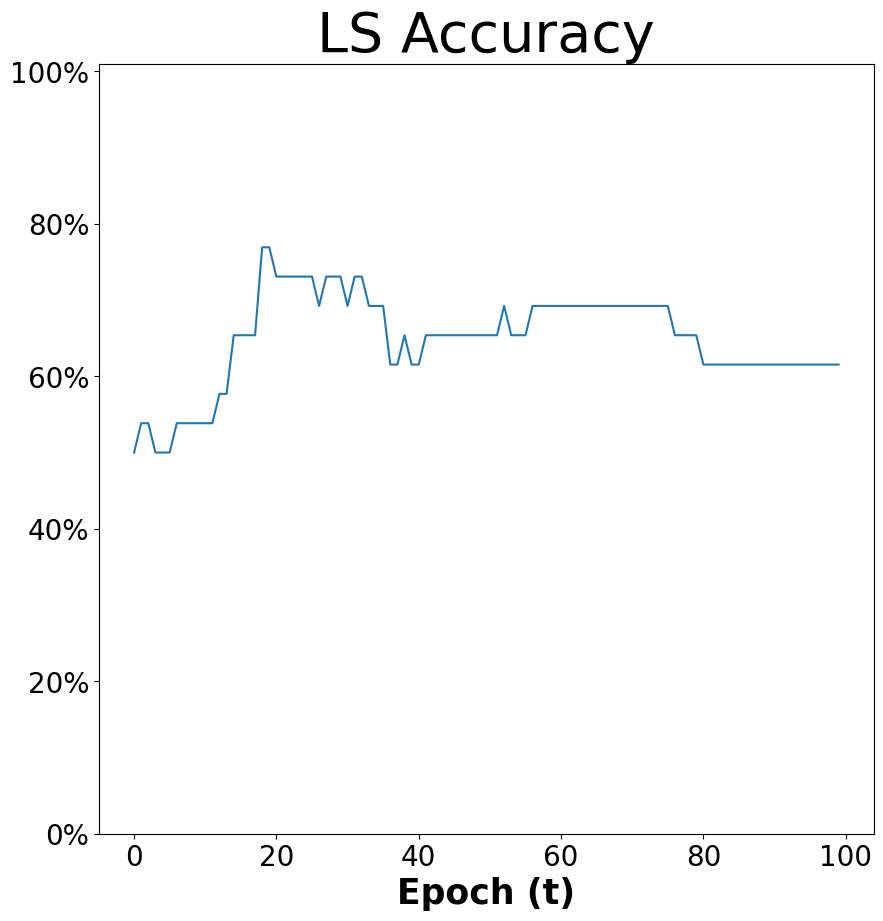

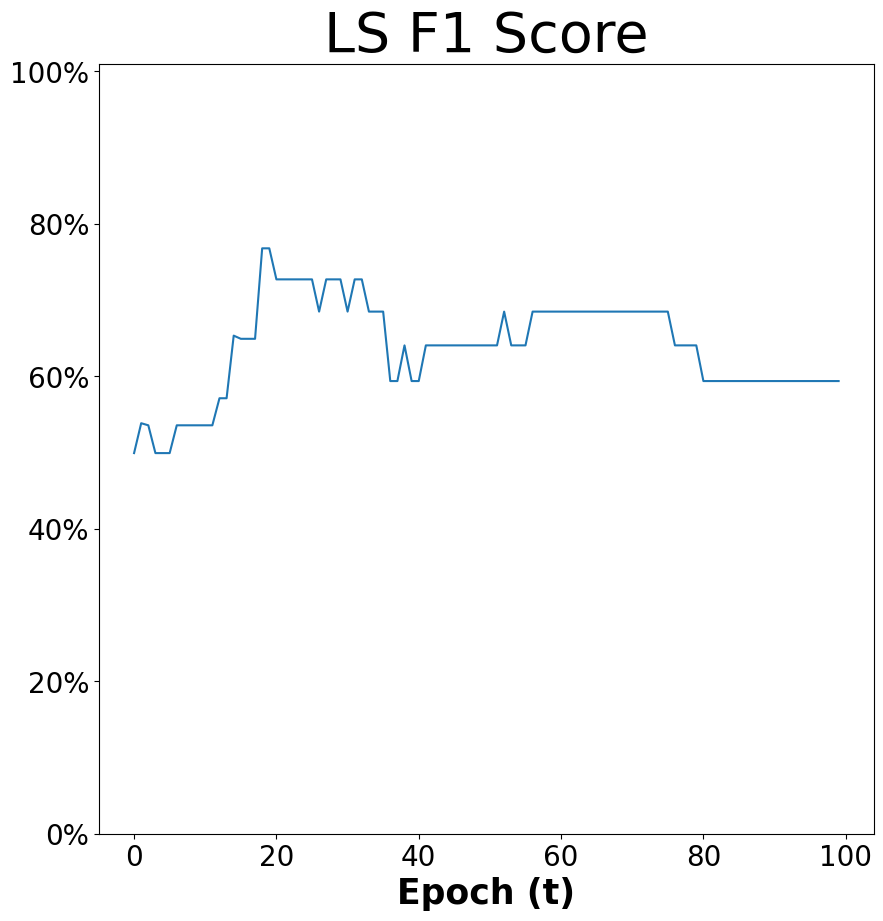

In [38]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [39]:
learning_rate = 0.03
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4739, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4625, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 21, Loss: 0.4552, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 31, Loss: 0.4511, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 41, Loss: 0.4485, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 51, Loss: 0.4467, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 61, Loss: 0.4454, Accuracy: 65.38 %, F_1_score: 64.92 %
Epoch: 71, Loss: 0.4443, Accuracy: 73.08 %, F_1_score: 72.71 %
Epoch: 81, Loss: 0.4436, Accuracy: 73.08 %, F_1_score: 72.71 %
Epoch: 91, Loss: 0.4431, Accuracy: 73.08 %, F_1_score: 72.71 %


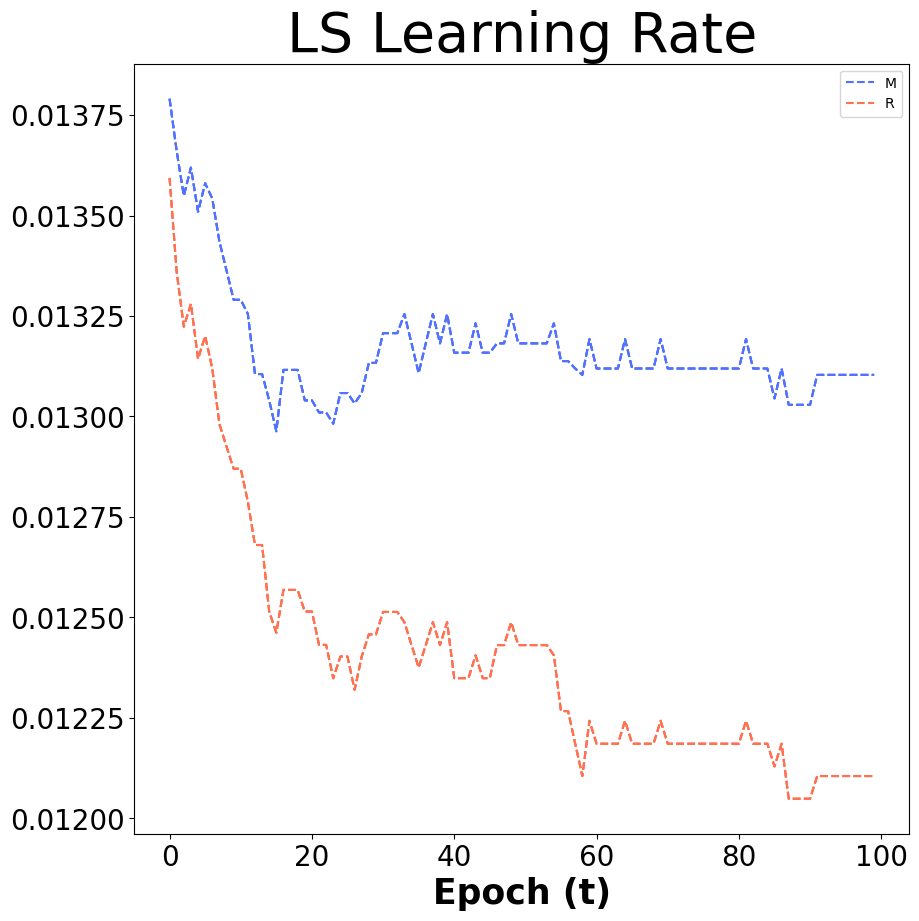

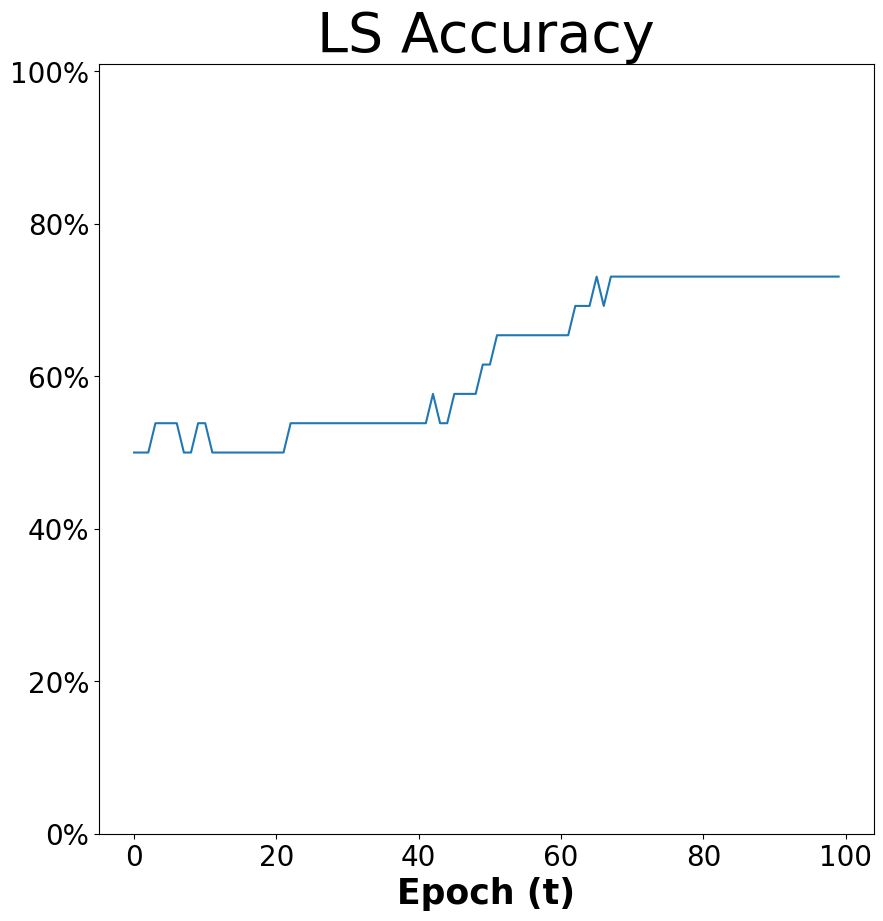

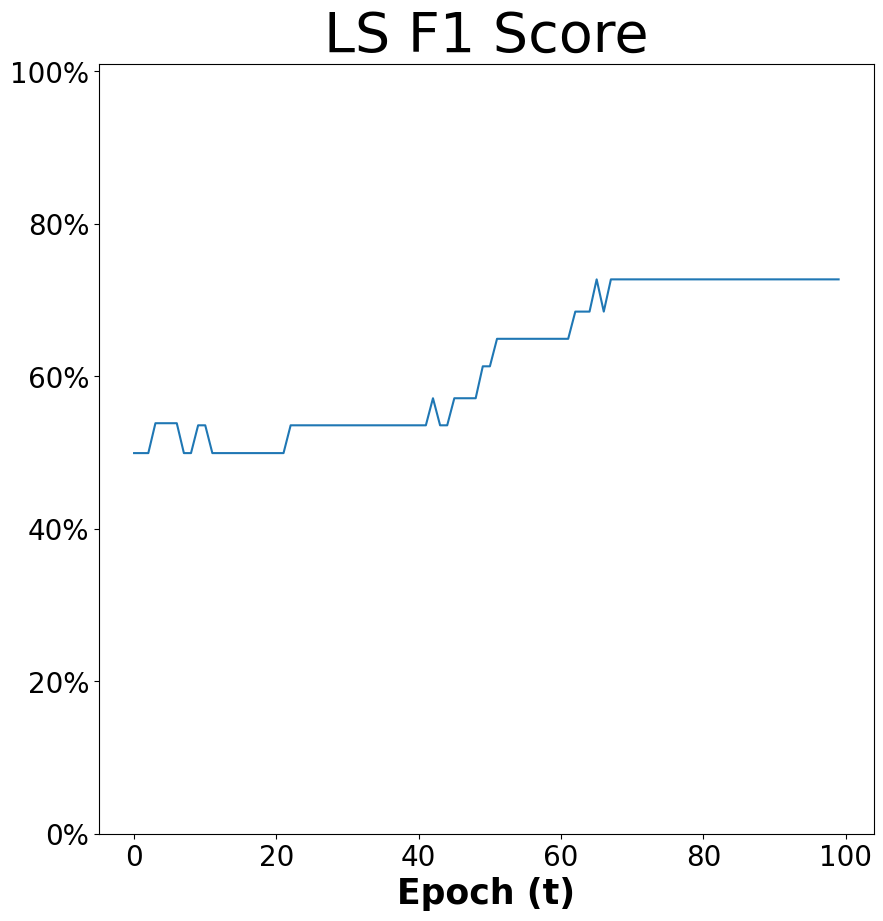

In [40]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [41]:
learning_rate = 0.01
ls_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4741, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4697, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 0.4659, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 31, Loss: 0.4626, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 41, Loss: 0.4596, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 51, Loss: 0.4572, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 61, Loss: 0.4552, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 71, Loss: 0.4536, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 81, Loss: 0.4522, Accuracy: 53.85 %, F_1_score: 53.57 %
Epoch: 91, Loss: 0.4510, Accuracy: 53.85 %, F_1_score: 53.57 %


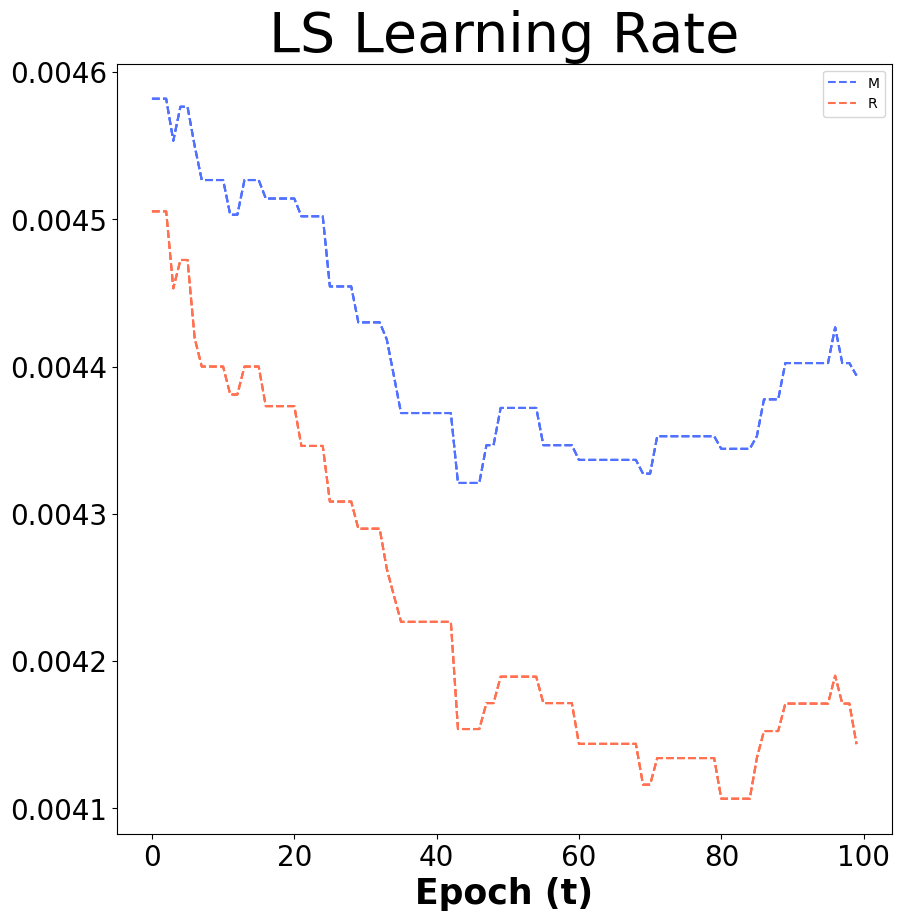

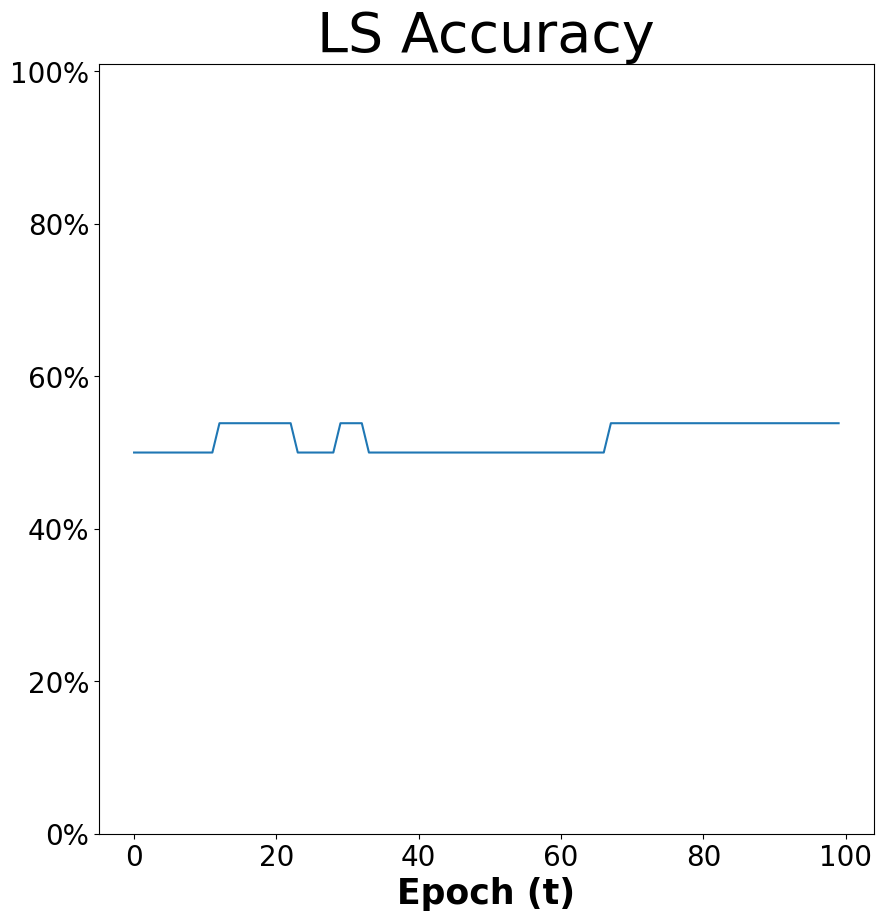

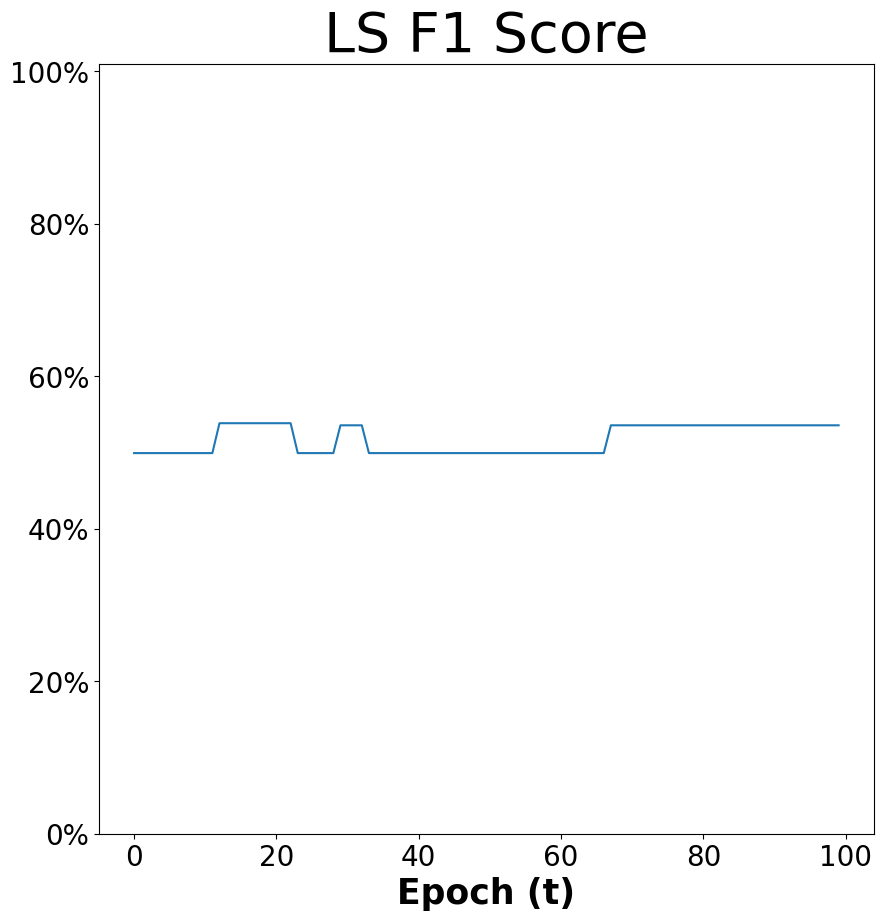

In [42]:
save_figs(ls_glvq_acc, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [43]:
learning_rate = 0.1
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4734, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4513, Accuracy: 65.38 %, F_1_score: 65.33 %
Epoch: 21, Loss: 0.4456, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 31, Loss: 0.4432, Accuracy: 76.92 %, F_1_score: 76.79 %
Epoch: 41, Loss: 0.4420, Accuracy: 80.77 %, F_1_score: 80.74 %
Epoch: 51, Loss: 0.4414, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 61, Loss: 0.4408, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 71, Loss: 0.4403, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 81, Loss: 0.4399, Accuracy: 84.62 %, F_1_score: 84.62 %
Epoch: 91, Loss: 0.4396, Accuracy: 80.77 %, F_1_score: 80.74 %


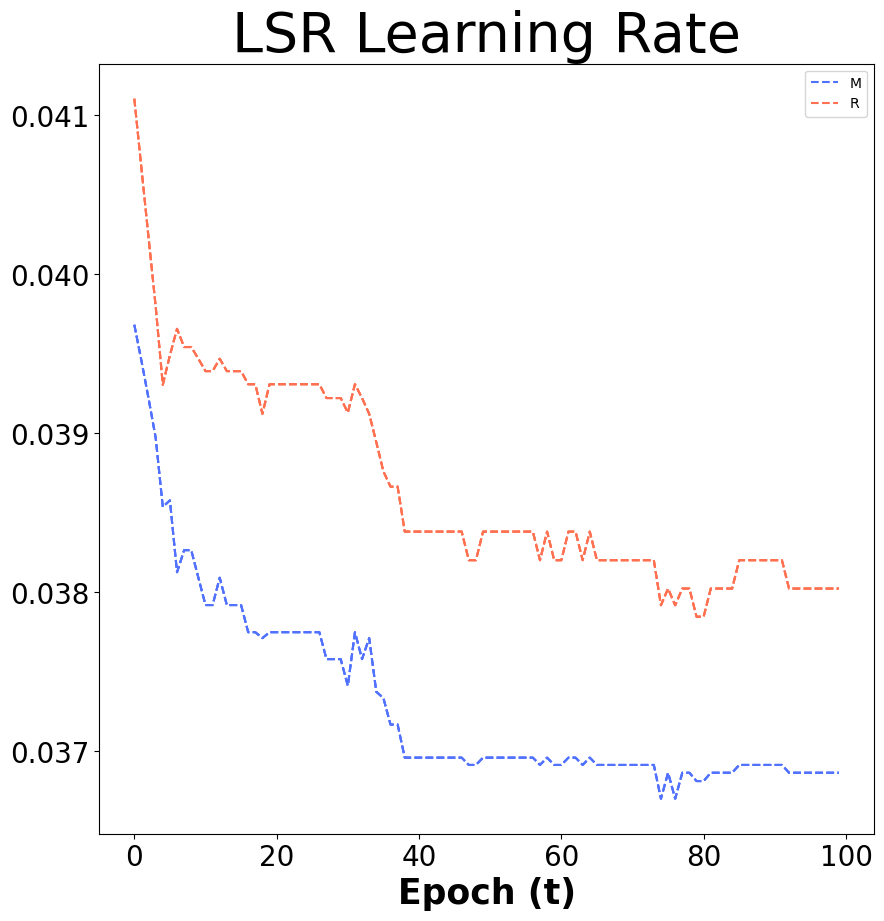

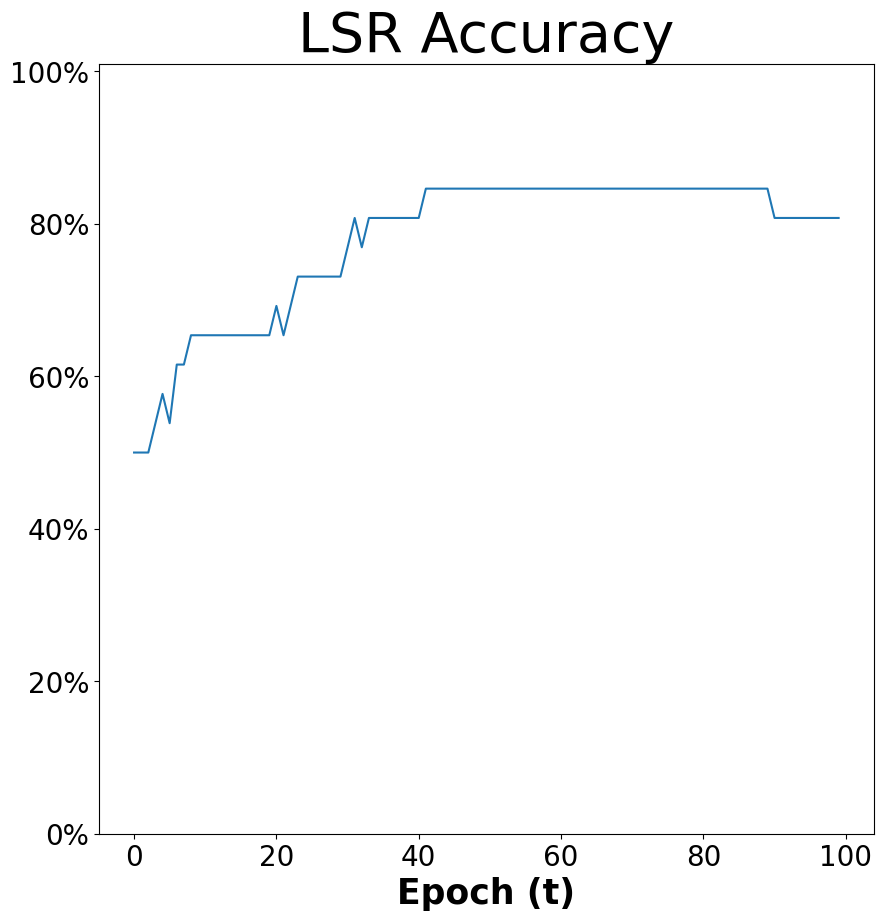

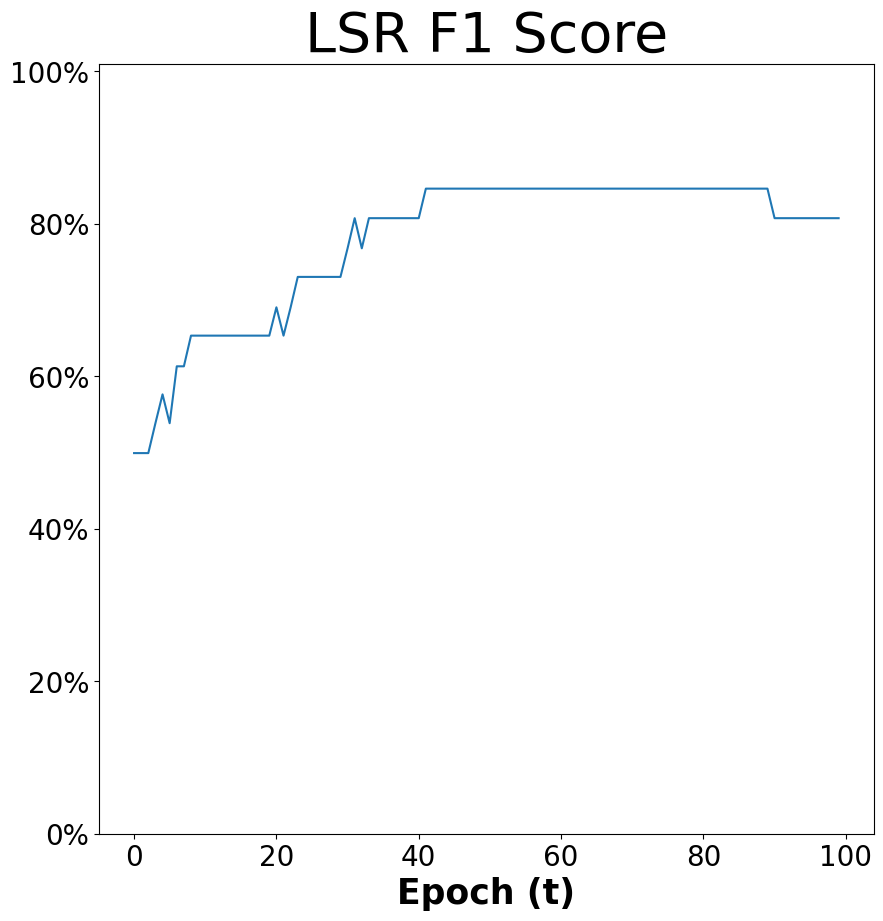

In [44]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [45]:
learning_rate = 0.03
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4740, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4636, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 0.4564, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 31, Loss: 0.4520, Accuracy: 65.38 %, F_1_score: 65.33 %
Epoch: 41, Loss: 0.4491, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 51, Loss: 0.4472, Accuracy: 65.38 %, F_1_score: 65.33 %
Epoch: 61, Loss: 0.4457, Accuracy: 65.38 %, F_1_score: 65.33 %
Epoch: 71, Loss: 0.4446, Accuracy: 69.23 %, F_1_score: 69.05 %
Epoch: 81, Loss: 0.4437, Accuracy: 73.08 %, F_1_score: 73.04 %
Epoch: 91, Loss: 0.4430, Accuracy: 73.08 %, F_1_score: 73.04 %


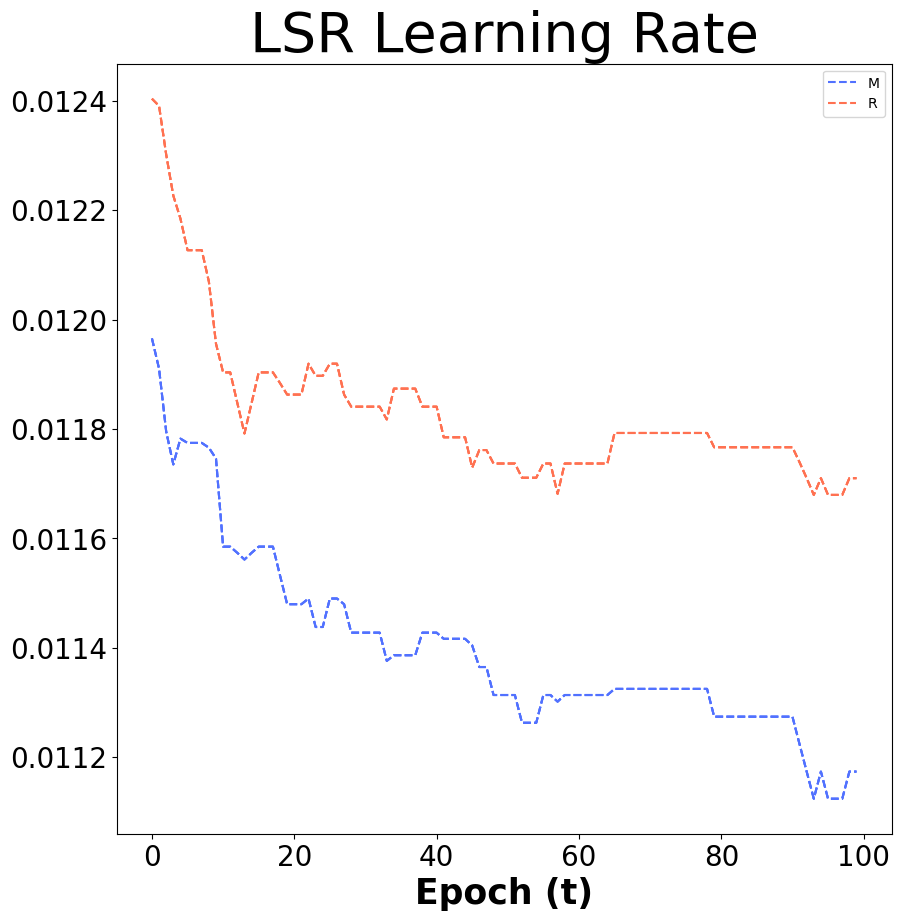

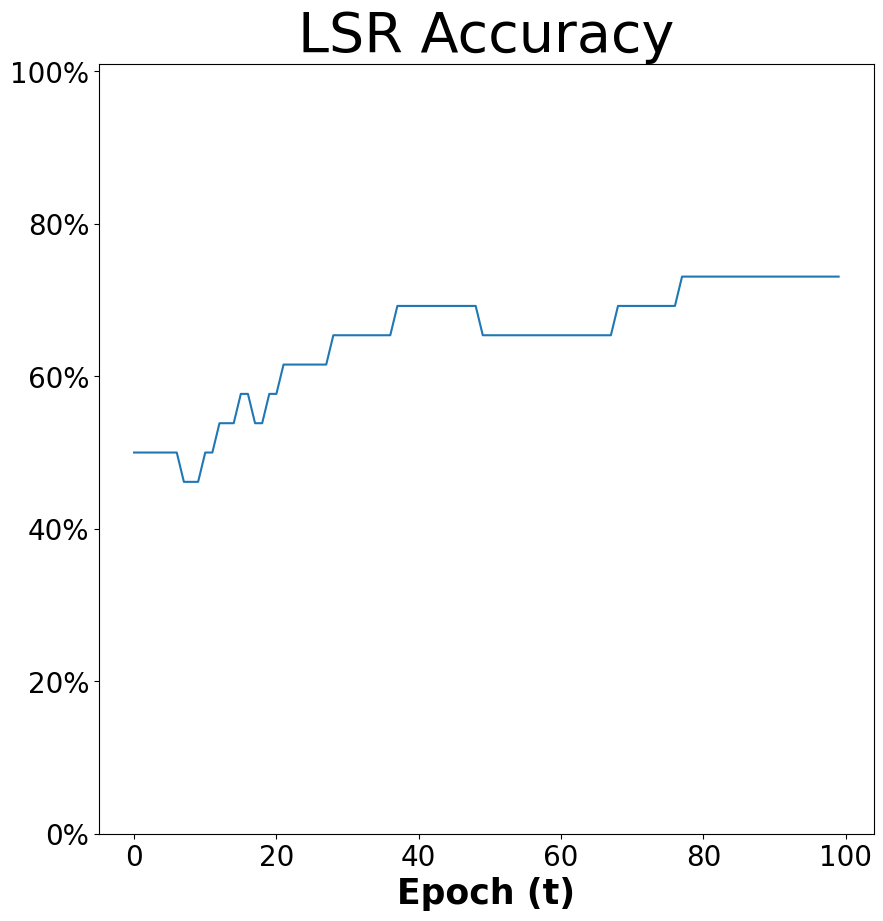

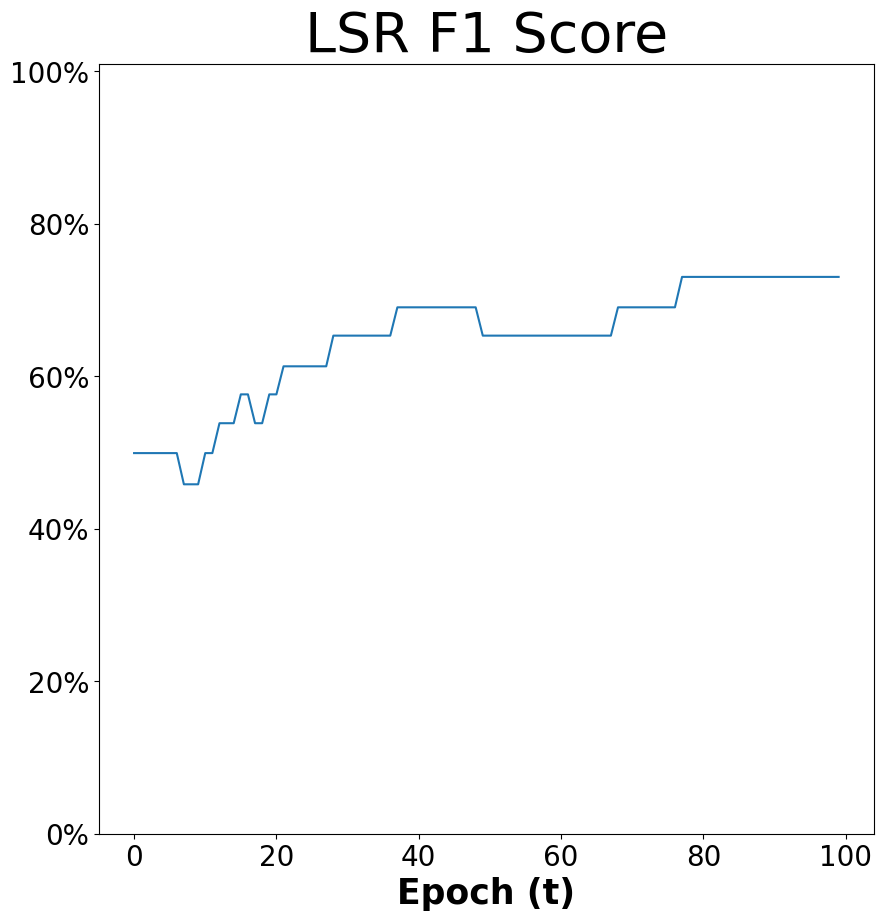

In [46]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [47]:
learning_rate = 0.01
lsr_glvq_acc = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_acc.train(
    num_epochs,
    train_set_acc,
    test_set_acc,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4741, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 11, Loss: 0.4702, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 21, Loss: 0.4668, Accuracy: 50.00 %, F_1_score: 49.93 %
Epoch: 31, Loss: 0.4637, Accuracy: 46.15 %, F_1_score: 45.83 %
Epoch: 41, Loss: 0.4609, Accuracy: 53.85 %, F_1_score: 53.85 %
Epoch: 51, Loss: 0.4586, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 61, Loss: 0.4565, Accuracy: 57.69 %, F_1_score: 57.63 %
Epoch: 71, Loss: 0.4546, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 81, Loss: 0.4531, Accuracy: 61.54 %, F_1_score: 61.31 %
Epoch: 91, Loss: 0.4519, Accuracy: 65.38 %, F_1_score: 65.33 %


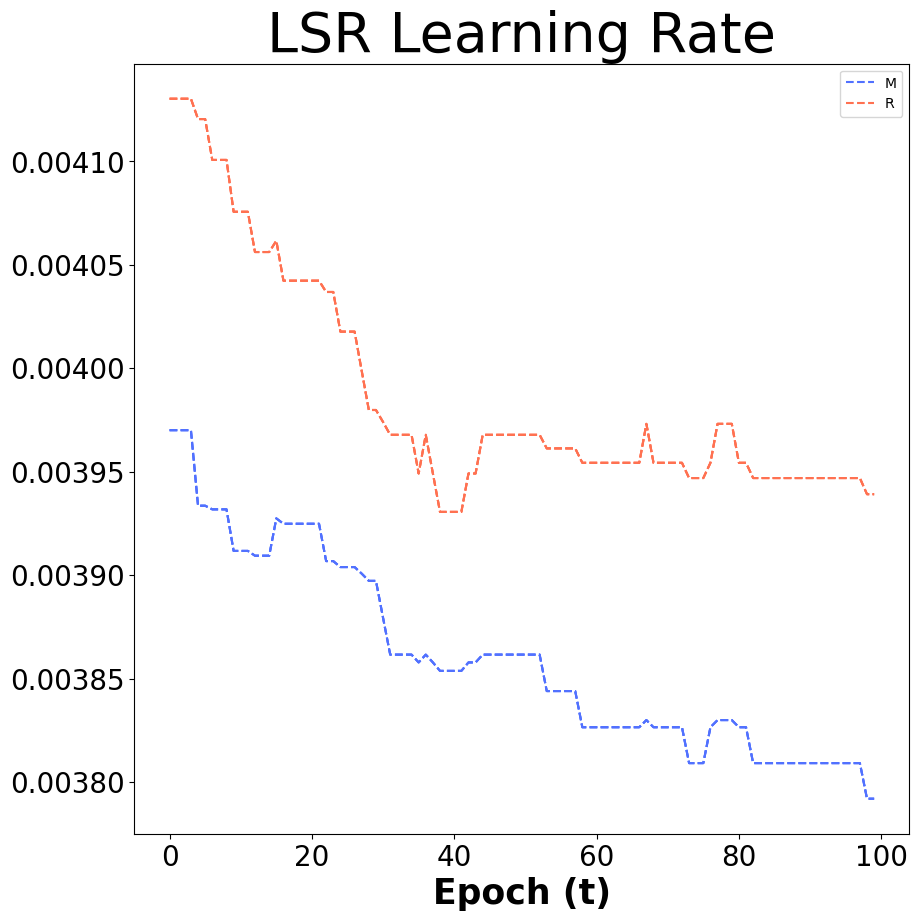

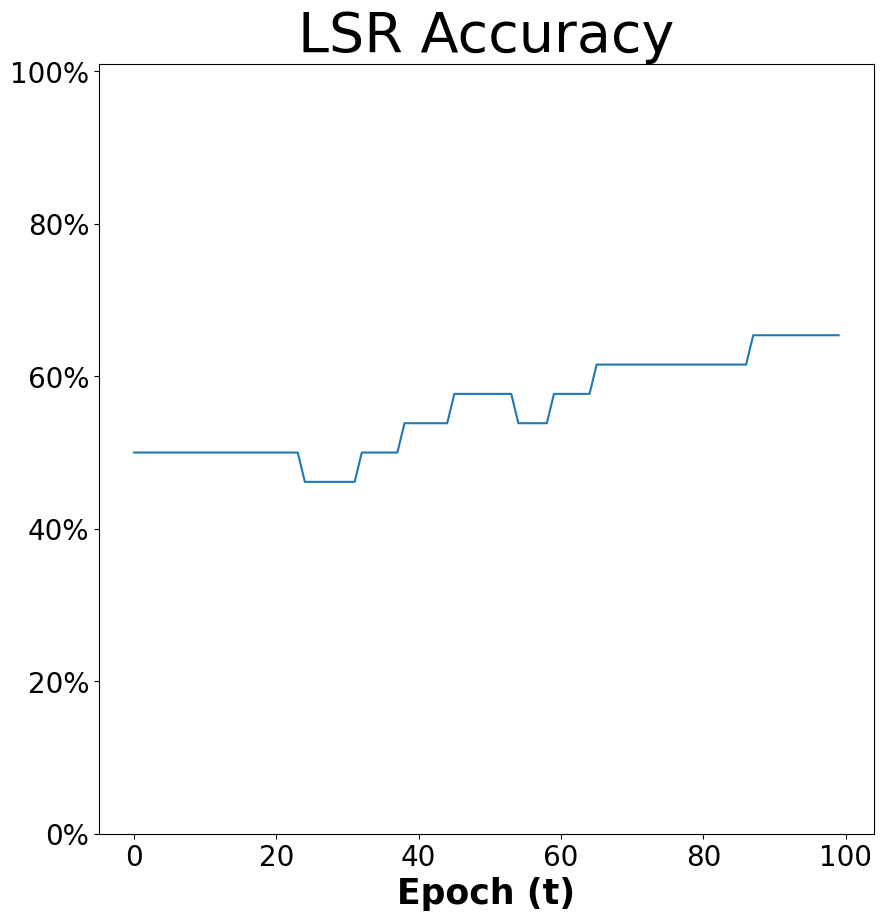

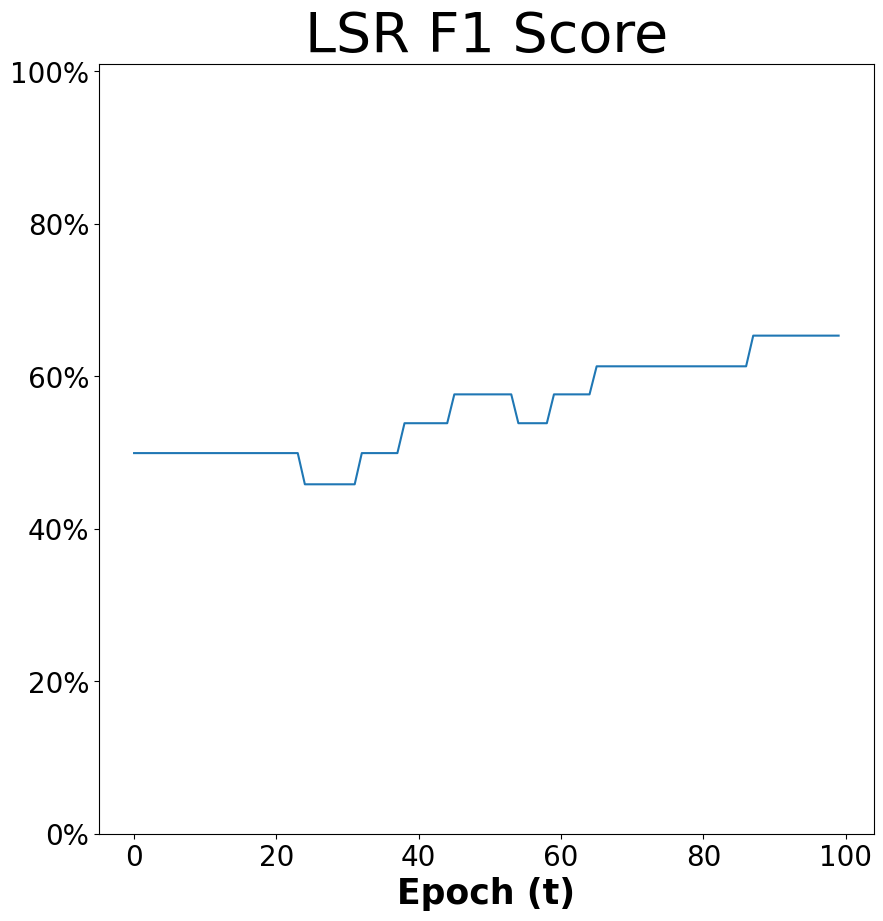

In [48]:
save_figs(lsr_glvq_acc, experiment, "LSR", learning_rate)

##### F1 Score

In [49]:
experiment = "experiment_2"

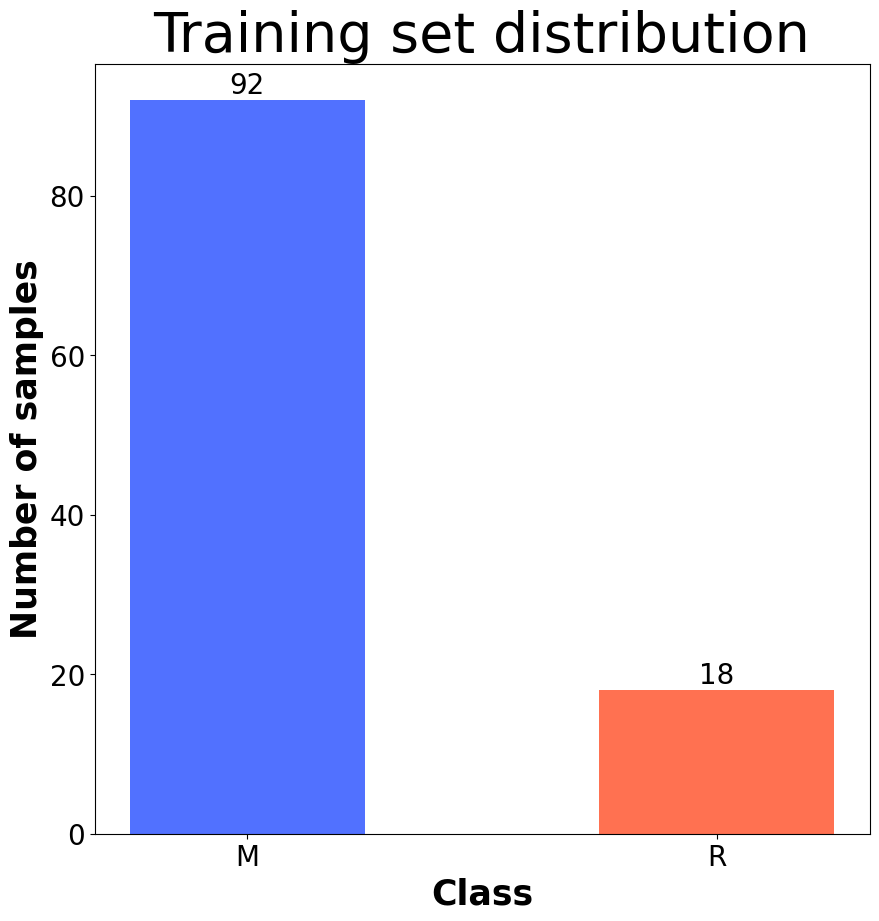

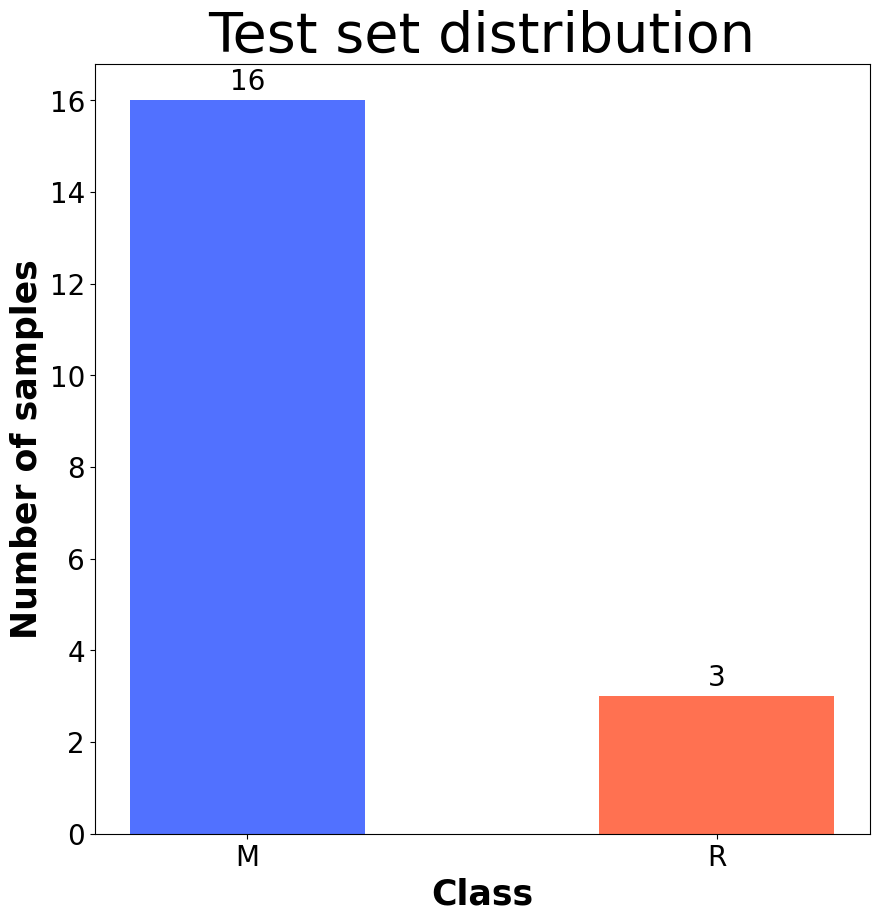

In [50]:
# Select 10% of #sample-1 as #sample-2
max_data = max(count) - num_prototypes
data_per_class = [max_data, int(max_data / 5)]
test_percentage = 0.15
test_size = list(map(lambda data: int(data * test_percentage), data_per_class))
train_size = [data - test for data, test in zip(data_per_class, test_size)]
feature_f1 = copy.deepcopy(feature)
label_f1 = copy.deepcopy(label)

## Select test set
test_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, test_size[j])
    test_index += index_i_sample
test_index.sort(reverse=True)
test_set_fscore = [(feature_f1[i], label_f1[i]) for i in test_index]
random.shuffle(test_set_fscore)
unique, counts = np.unique(label_f1[test_index], return_counts=True)
test_dist = dict(zip(unique, counts))
feature_f1 = np.delete(feature_f1, test_index, axis=0)
label_f1 = np.delete(label_f1, test_index, axis=0)

## Select train set
train_index = []
for j, class_name in enumerate(sample_number):
    index_i = np.where(label_f1 == class_name)
    index_i = list(index_i[0])
    index_i_sample = random.sample(index_i, train_size[j])
    train_index += index_i_sample
train_index.sort(reverse=True)
train_set_fscore = [(feature_f1[i], label_f1[i]) for i in train_index]
random.shuffle(train_set_fscore)
unique, counts = np.unique(label_f1[train_index], return_counts=True)
train_dist = dict(zip(unique, counts))

fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(train_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Training set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/train_dist.png", dpi=300)


fig, ax = plt.subplots(figsize=(10, 10))
for i, (k, v) in enumerate(test_dist.items()):
    ax.bar(k, v, width=0.5, color=colors[i])
    plt.text(k, v + 0.1, str(v), ha="center", va="bottom", fontsize=20)
plt.title("Test set distribution", fontsize=40)
plt.xlabel("Class", fontsize=25, weight="bold")
plt.ylabel("Number of samples", fontsize=25, weight="bold")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
fig.savefig(img_folder + experiment + "/" + data_name + "/test_dist.png", dpi=300)

#### Train the Models

In [51]:
num_epochs = 100

##### GLVQ

##### 1-step lr =0.1

In [52]:
learning_rate = 0.1
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 50.4299, Accuracy: 84.21 %, F_1_score: 84.89 %
Epoch: 11, Loss: 40.1630, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 21, Loss: 39.2081, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 31, Loss: 38.8577, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 41, Loss: 38.6712, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 51, Loss: 38.5536, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 61, Loss: 38.4717, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 71, Loss: 38.4111, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 81, Loss: 38.3641, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 91, Loss: 38.3265, Accuracy: 84.21 %, F_1_score: 76.47 %


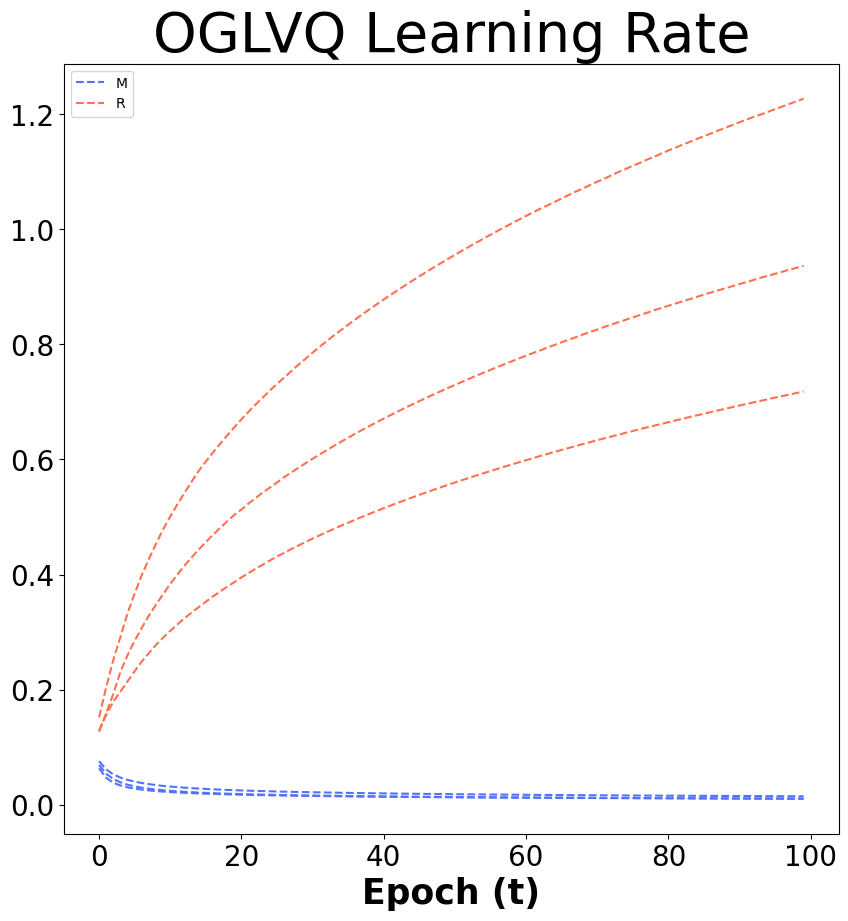

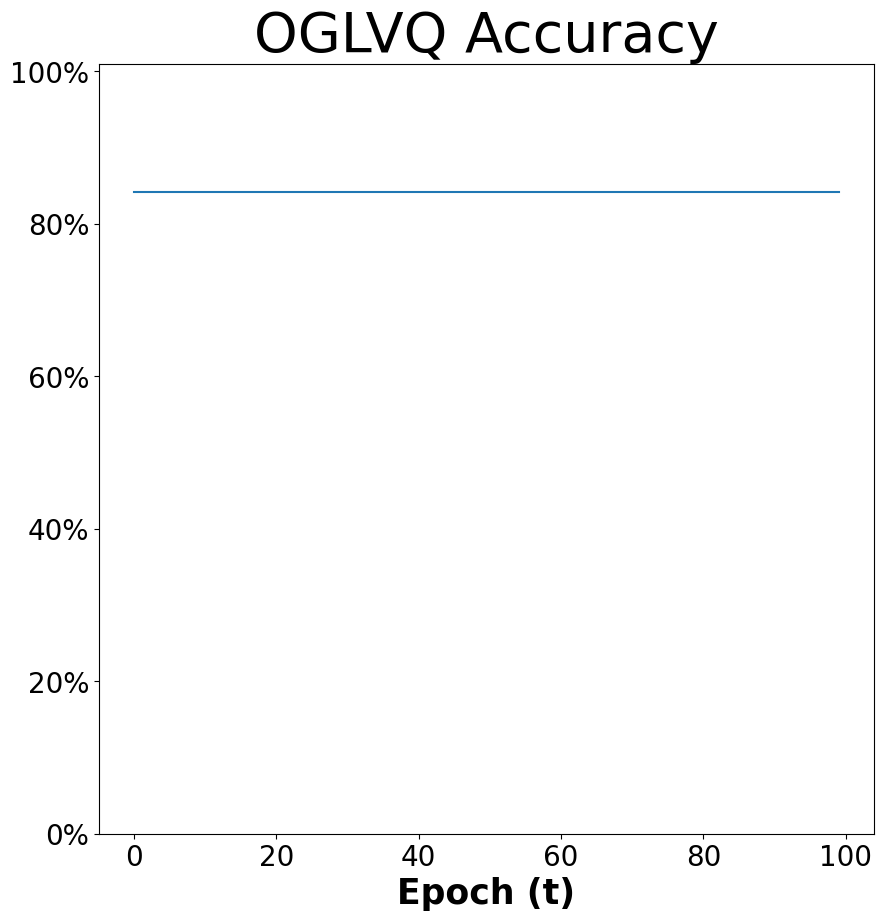

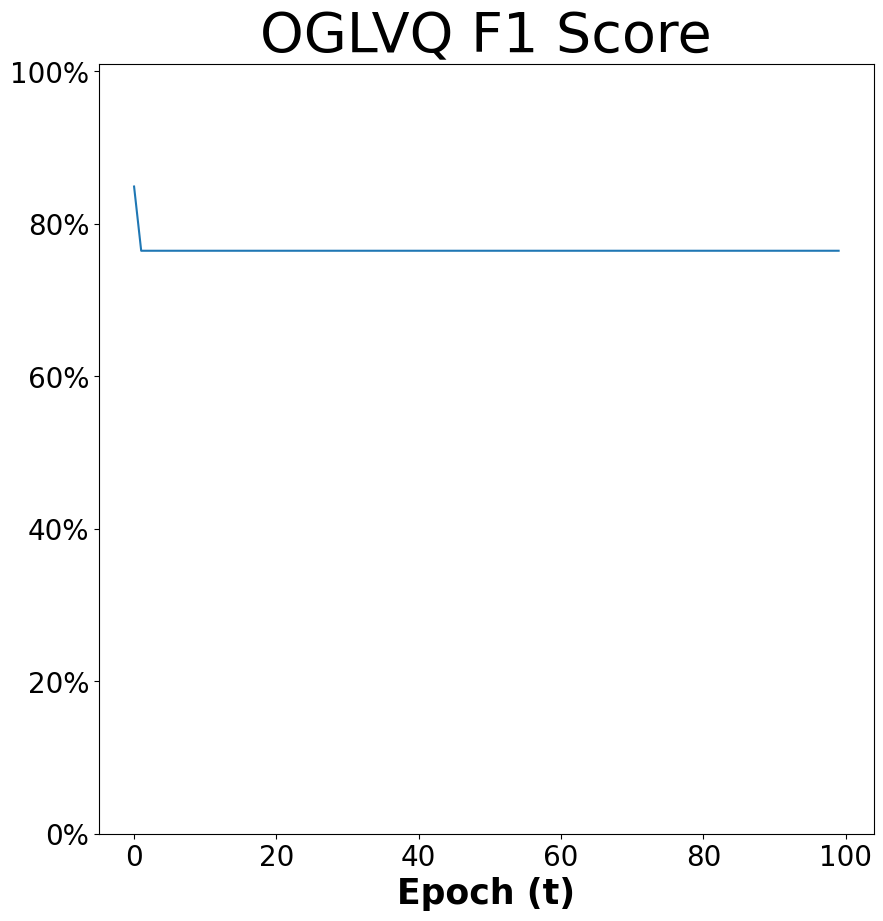

In [53]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 2-step lr = 0.03

In [54]:
learning_rate = 0.03
oglvq_fscore = oglvq.OGLVQ(
    prototypes,
    learning_rate,
)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 51.7858, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 11, Loss: 43.7780, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 21, Loss: 41.4198, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 31, Loss: 40.4437, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 41, Loss: 39.9134, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 51, Loss: 39.5791, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 61, Loss: 39.3497, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 71, Loss: 39.1826, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 81, Loss: 39.0547, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 91, Loss: 38.9534, Accuracy: 84.21 %, F_1_score: 76.47 %


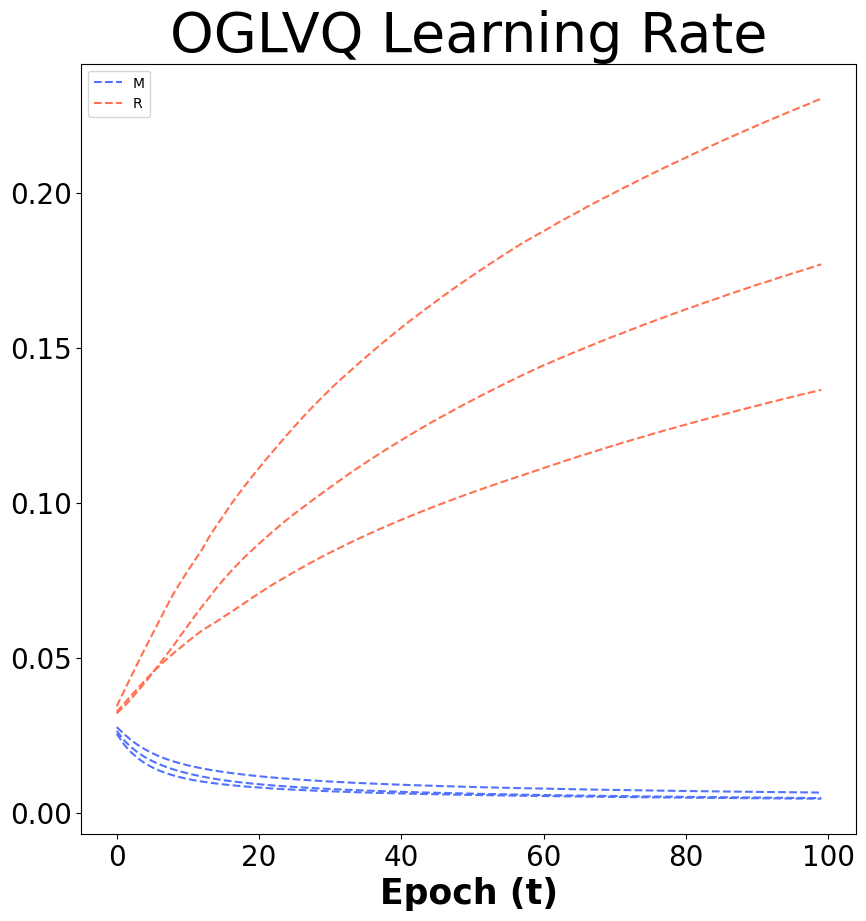

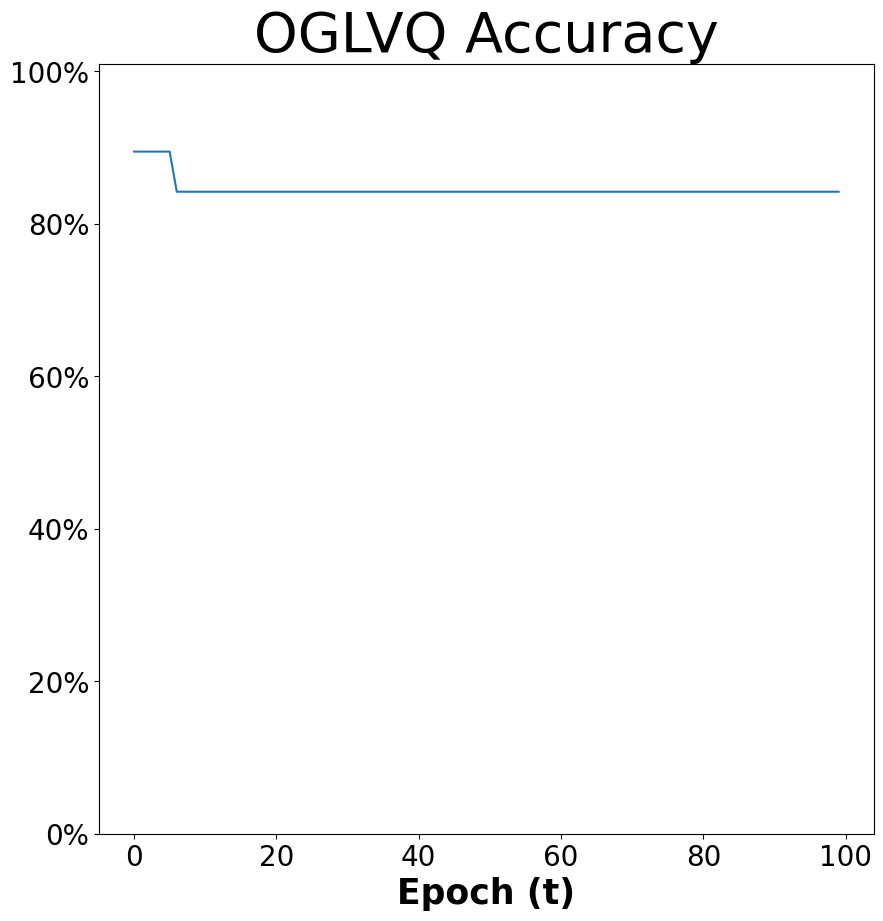

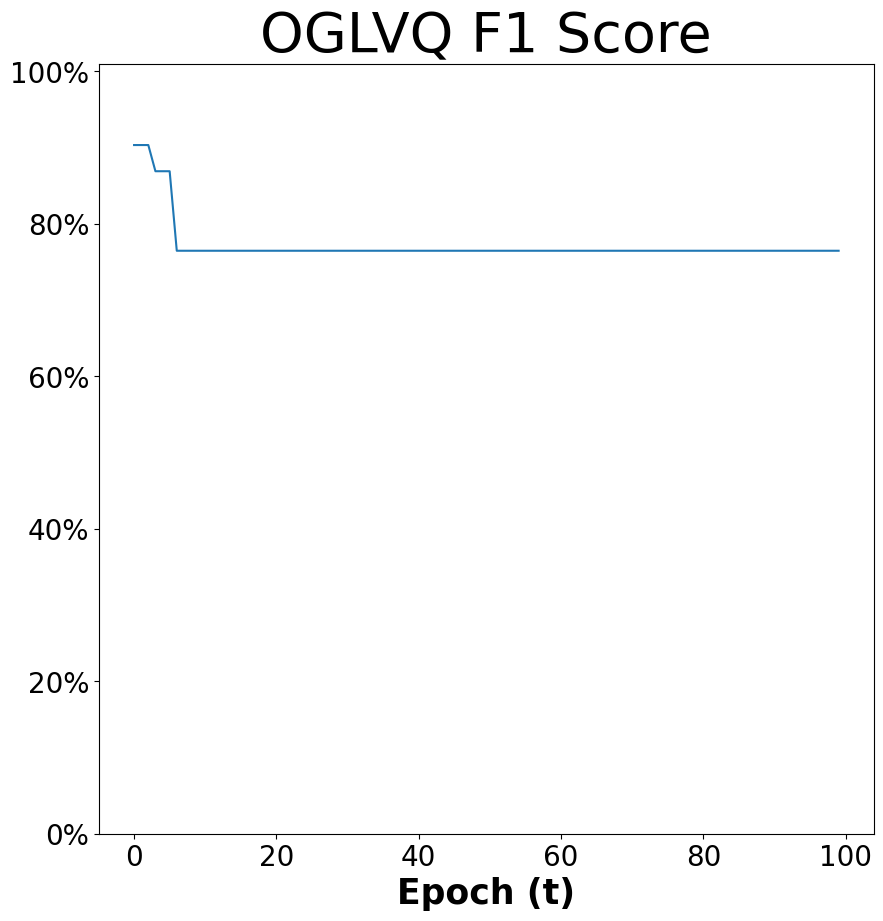

In [55]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### 3-step lr = 0.01

In [56]:
learning_rate = 0.01
oglvq_fscore = oglvq.OGLVQ(prototypes, learning_rate)
hist = oglvq_fscore.train(
    num_epochs, train_set_fscore, test_set_fscore, sample_number=train_dist
)


Epoch: 1, Loss: 52.2159, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 48.0586, Accuracy: 94.74 %, F_1_score: 94.19 %
Epoch: 21, Loss: 45.5367, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 31, Loss: 43.9026, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 41, Loss: 42.8095, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 51, Loss: 42.0254, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 61, Loss: 41.4687, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 71, Loss: 41.0531, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 81, Loss: 40.7286, Accuracy: 84.21 %, F_1_score: 76.47 %
Epoch: 91, Loss: 40.4696, Accuracy: 84.21 %, F_1_score: 76.47 %


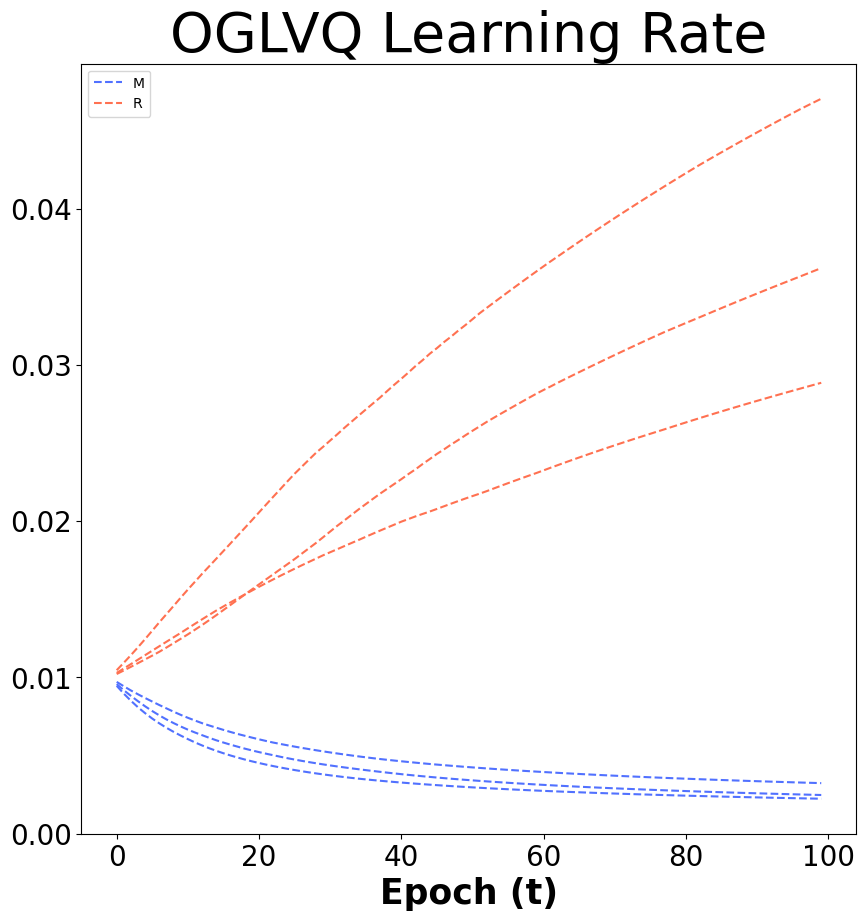

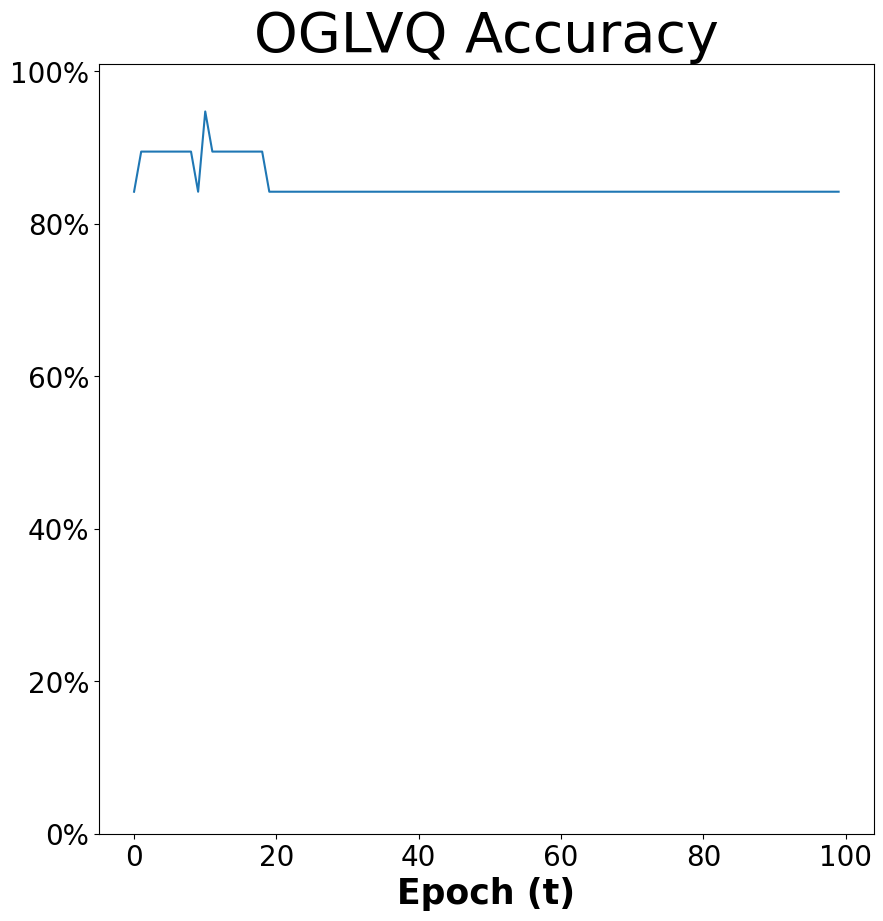

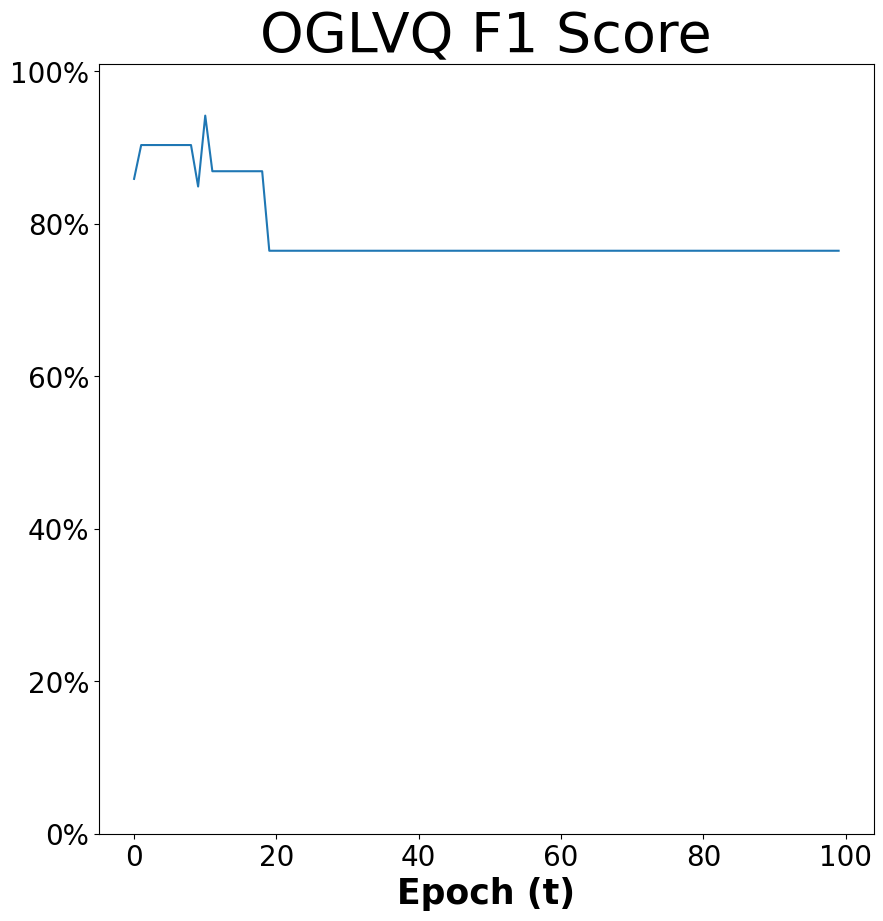

In [57]:
save_figs(oglvq_fscore, experiment, "OGLVQ", learning_rate)

##### CP

##### 1-step lr = 0.1

In [58]:
learning_rate = 0.1
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4779, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.5142, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 21, Loss: 0.5311, Accuracy: 42.11 %, F_1_score: 45.60 %
Epoch: 31, Loss: 0.5427, Accuracy: 31.58 %, F_1_score: 31.58 %
Epoch: 41, Loss: 0.5495, Accuracy: 31.58 %, F_1_score: 31.58 %
Epoch: 51, Loss: 0.5542, Accuracy: 26.32 %, F_1_score: 23.49 %
Epoch: 61, Loss: 0.5533, Accuracy: 26.32 %, F_1_score: 23.49 %
Epoch: 71, Loss: 0.5532, Accuracy: 26.32 %, F_1_score: 23.49 %
Epoch: 81, Loss: 0.5507, Accuracy: 26.32 %, F_1_score: 23.49 %
Epoch: 91, Loss: 0.5493, Accuracy: 26.32 %, F_1_score: 23.49 %


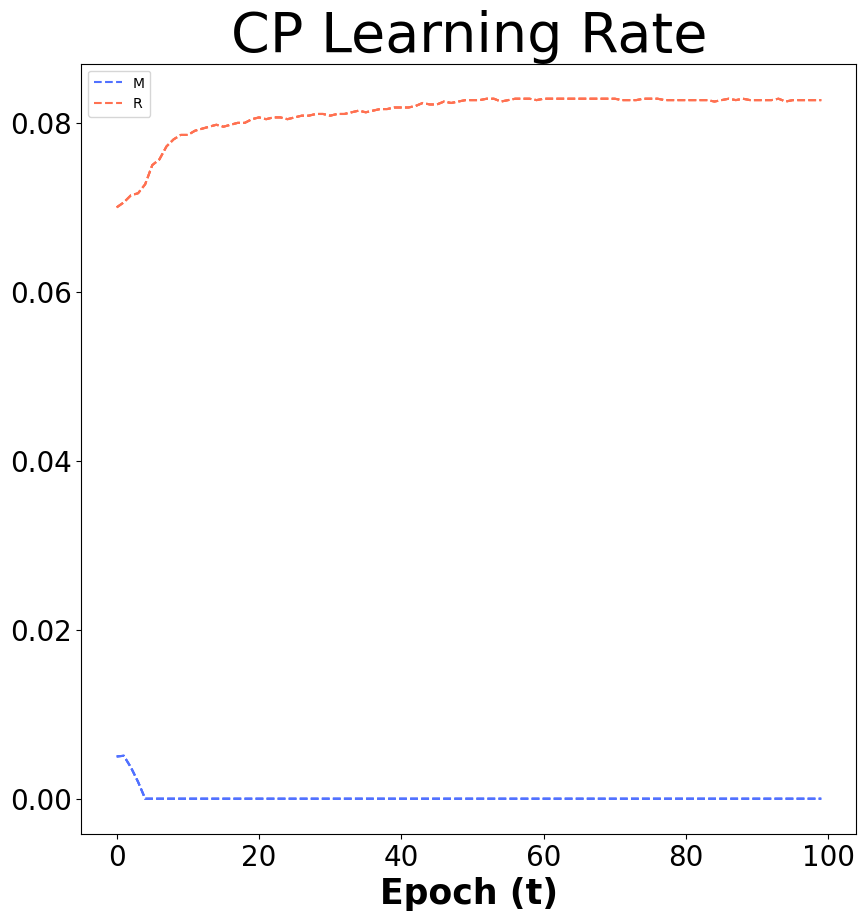

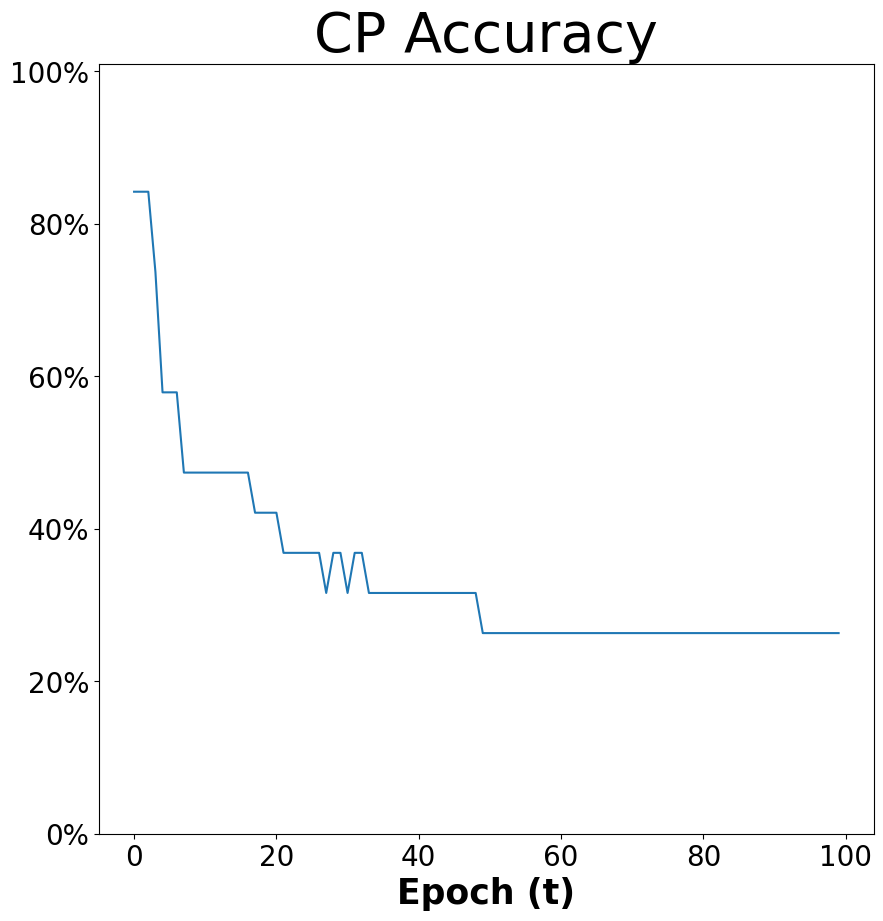

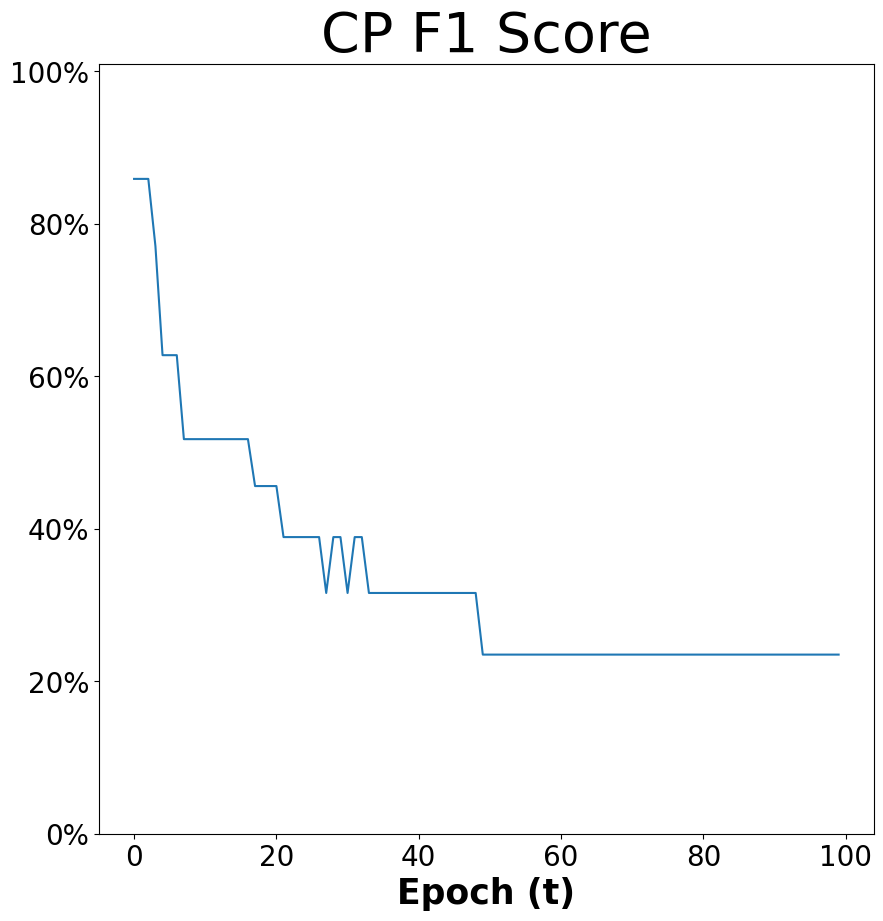

In [59]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 2-step lr = 0.03

In [60]:
learning_rate = 0.03
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4771, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4841, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4984, Accuracy: 57.89 %, F_1_score: 62.77 %
Epoch: 31, Loss: 0.5115, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 41, Loss: 0.5190, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 51, Loss: 0.5251, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 61, Loss: 0.5303, Accuracy: 42.11 %, F_1_score: 45.60 %
Epoch: 71, Loss: 0.5340, Accuracy: 42.11 %, F_1_score: 45.60 %
Epoch: 81, Loss: 0.5378, Accuracy: 36.84 %, F_1_score: 38.91 %
Epoch: 91, Loss: 0.5404, Accuracy: 31.58 %, F_1_score: 31.58 %


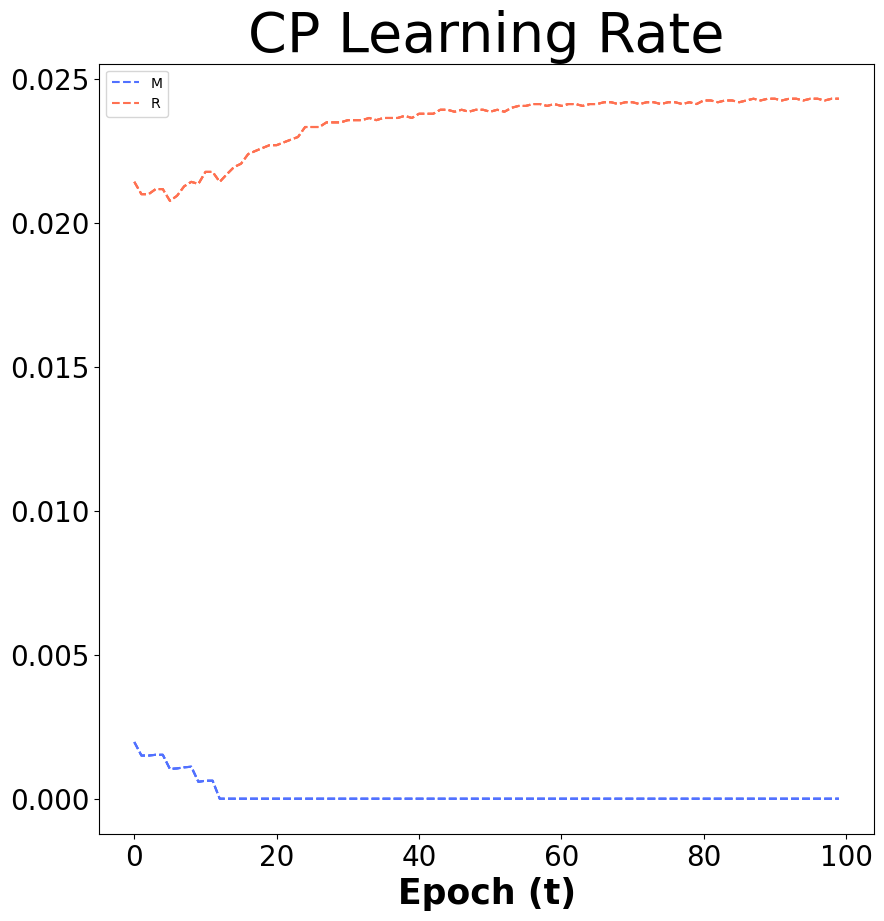

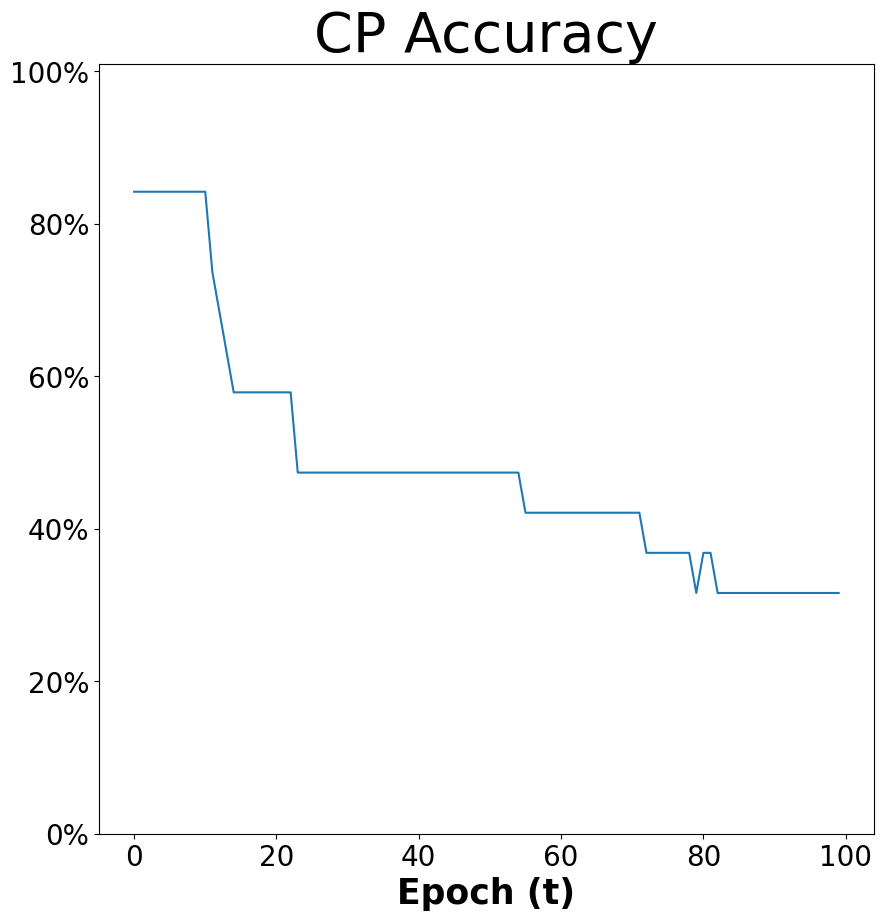

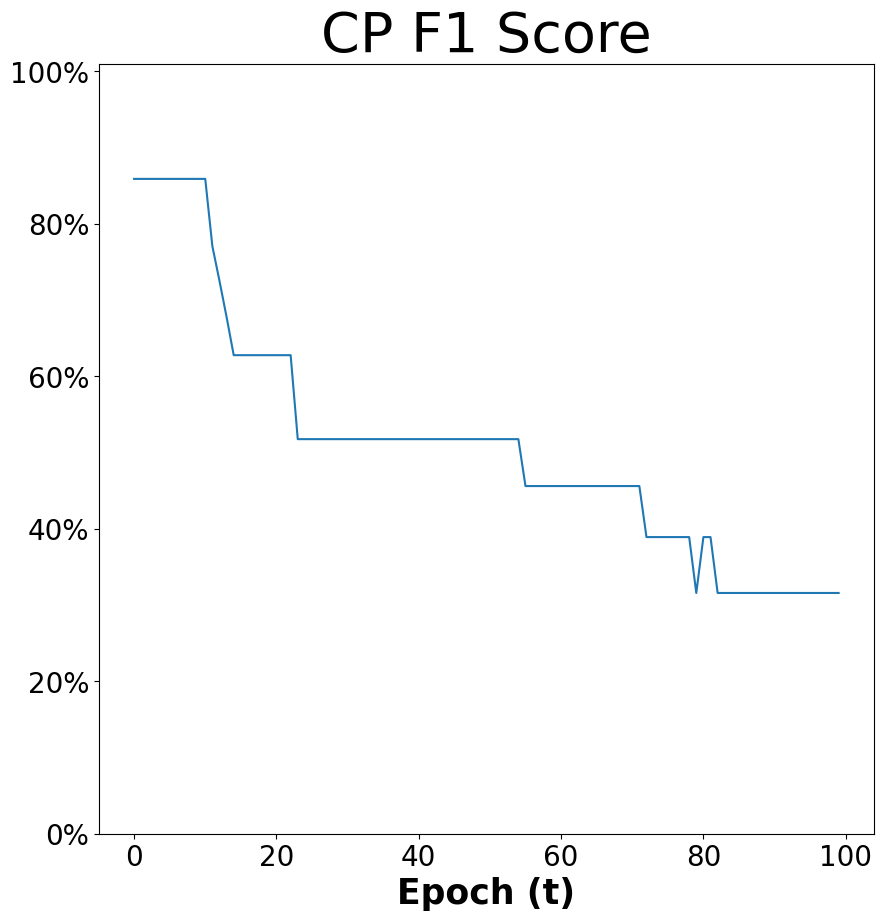

In [61]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### 3-step lr = 0.01

In [62]:
learning_rate = 0.01
cp_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = cp_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.conditional_probability,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4768, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4781, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4807, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4841, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 41, Loss: 0.4887, Accuracy: 63.16 %, F_1_score: 67.77 %
Epoch: 51, Loss: 0.4937, Accuracy: 57.89 %, F_1_score: 62.77 %
Epoch: 61, Loss: 0.4986, Accuracy: 57.89 %, F_1_score: 62.77 %
Epoch: 71, Loss: 0.5034, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 81, Loss: 0.5080, Accuracy: 47.37 %, F_1_score: 51.76 %
Epoch: 91, Loss: 0.5119, Accuracy: 47.37 %, F_1_score: 51.76 %


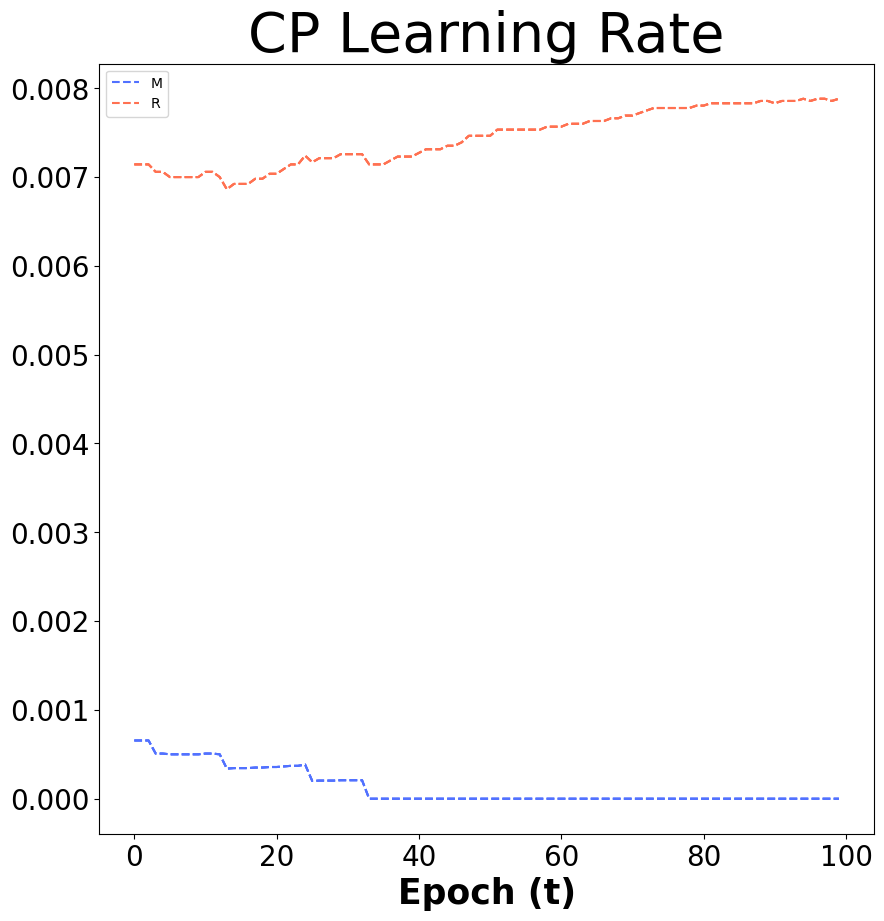

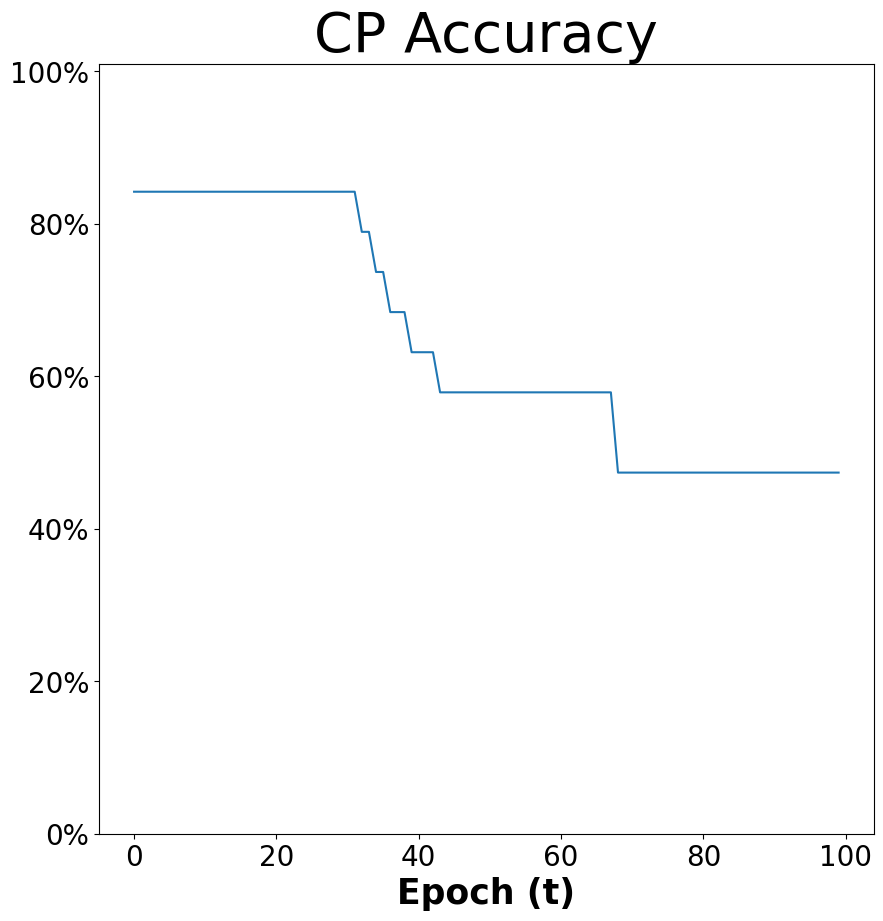

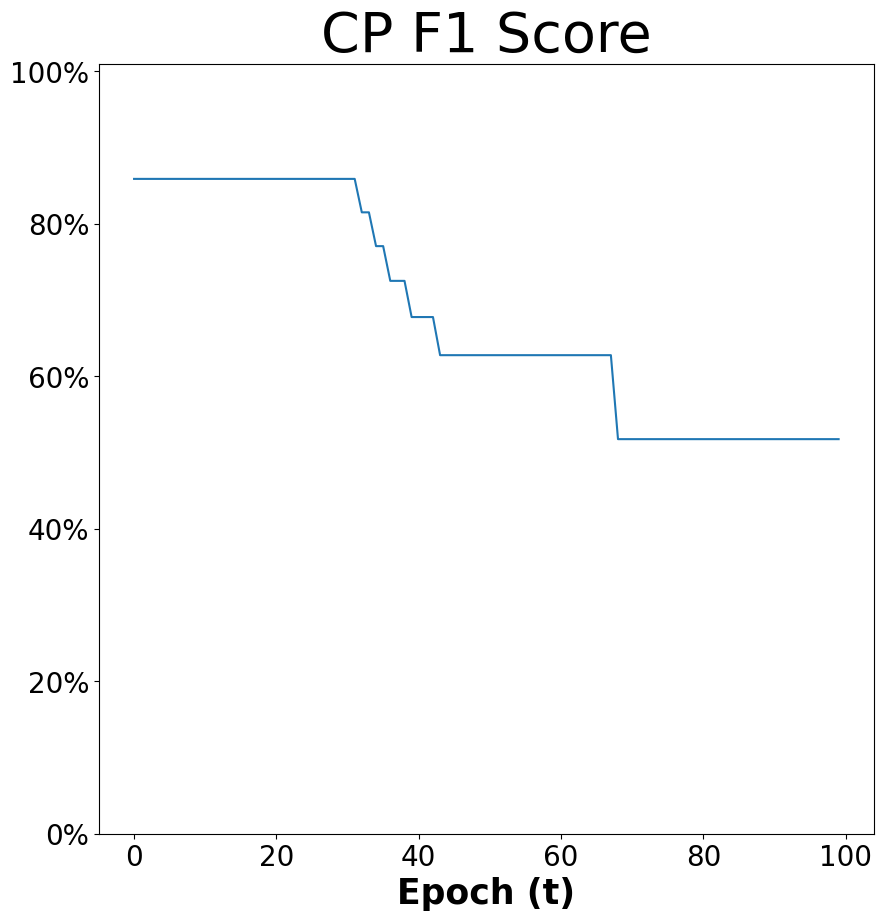

In [63]:
save_figs(cp_glvq_fscore, experiment, "CP", learning_rate)

##### DFH

##### 1-step lr = 0.1

In [64]:
learning_rate = 0.1
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4770, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4665, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 21, Loss: 0.4573, Accuracy: 73.68 %, F_1_score: 77.07 %
Epoch: 31, Loss: 0.4507, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 41, Loss: 0.4447, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 51, Loss: 0.4409, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 61, Loss: 0.4387, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 71, Loss: 0.4376, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 81, Loss: 0.4363, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 91, Loss: 0.4358, Accuracy: 84.21 %, F_1_score: 85.89 %


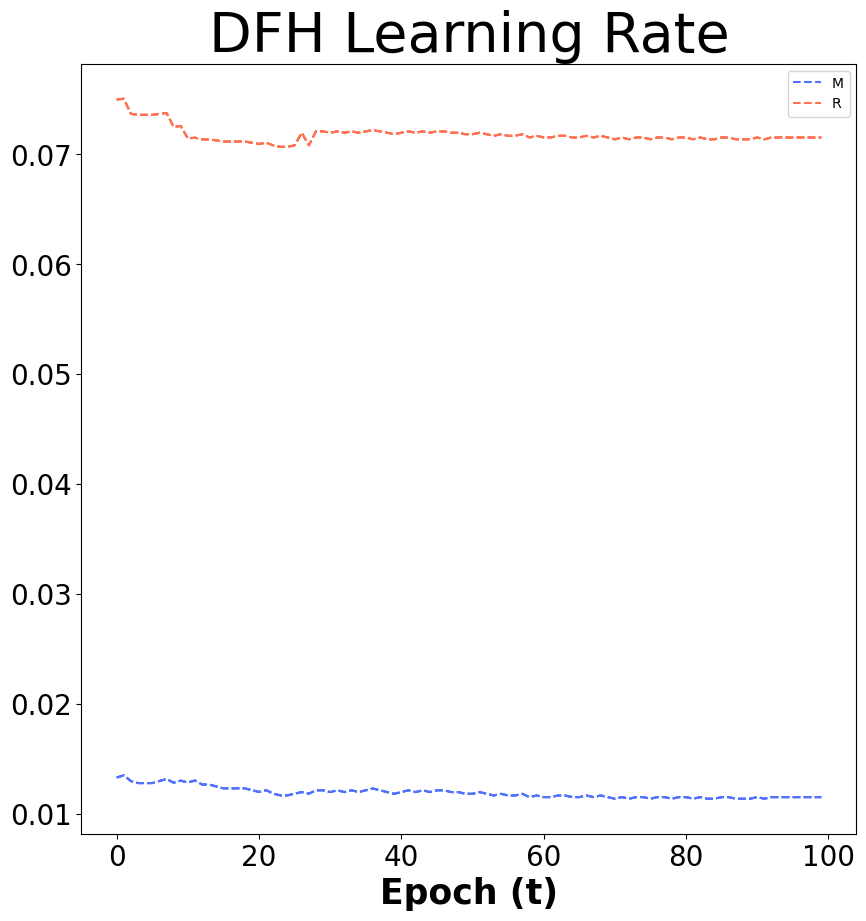

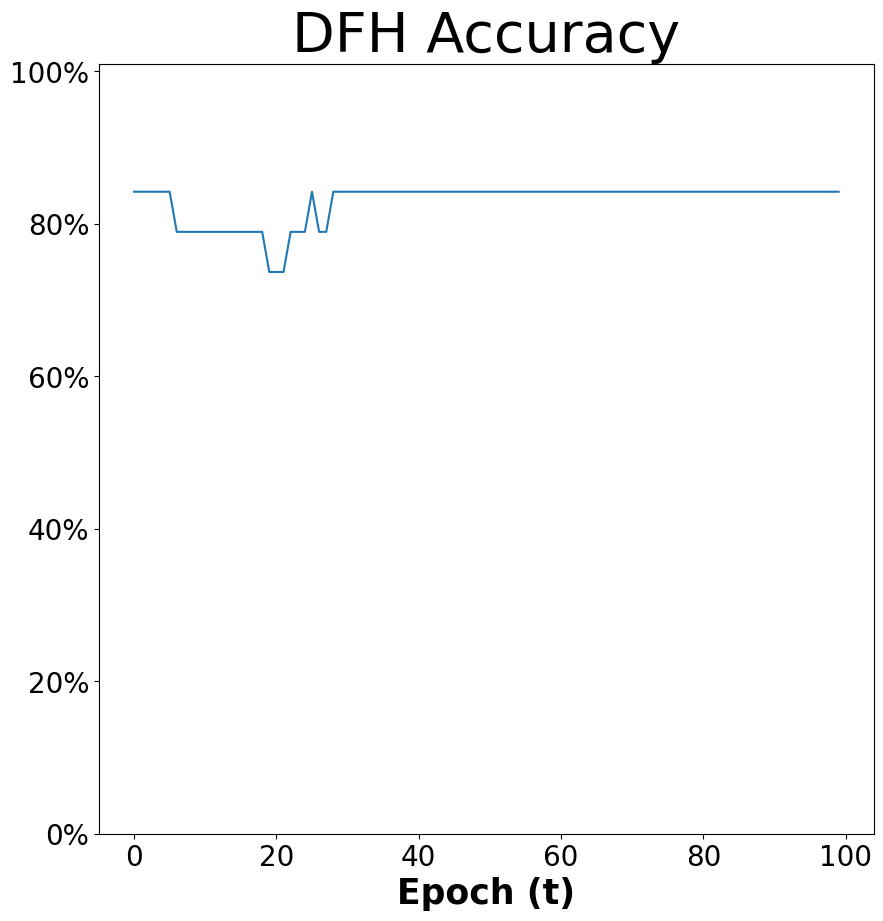

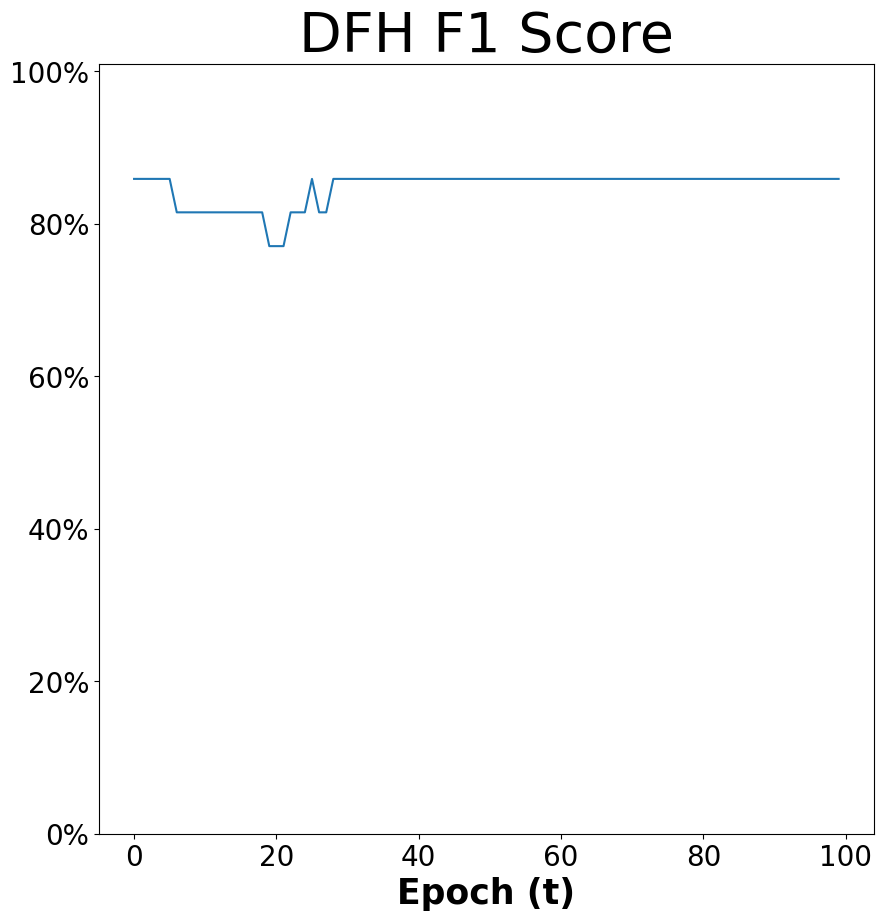

In [65]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 2-step lr = 0.03

In [66]:
learning_rate = 0.03
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4768, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4740, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4709, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4678, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 41, Loss: 0.4641, Accuracy: 73.68 %, F_1_score: 77.07 %
Epoch: 51, Loss: 0.4614, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 61, Loss: 0.4589, Accuracy: 73.68 %, F_1_score: 77.07 %
Epoch: 71, Loss: 0.4565, Accuracy: 73.68 %, F_1_score: 77.07 %
Epoch: 81, Loss: 0.4546, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 91, Loss: 0.4524, Accuracy: 73.68 %, F_1_score: 77.07 %


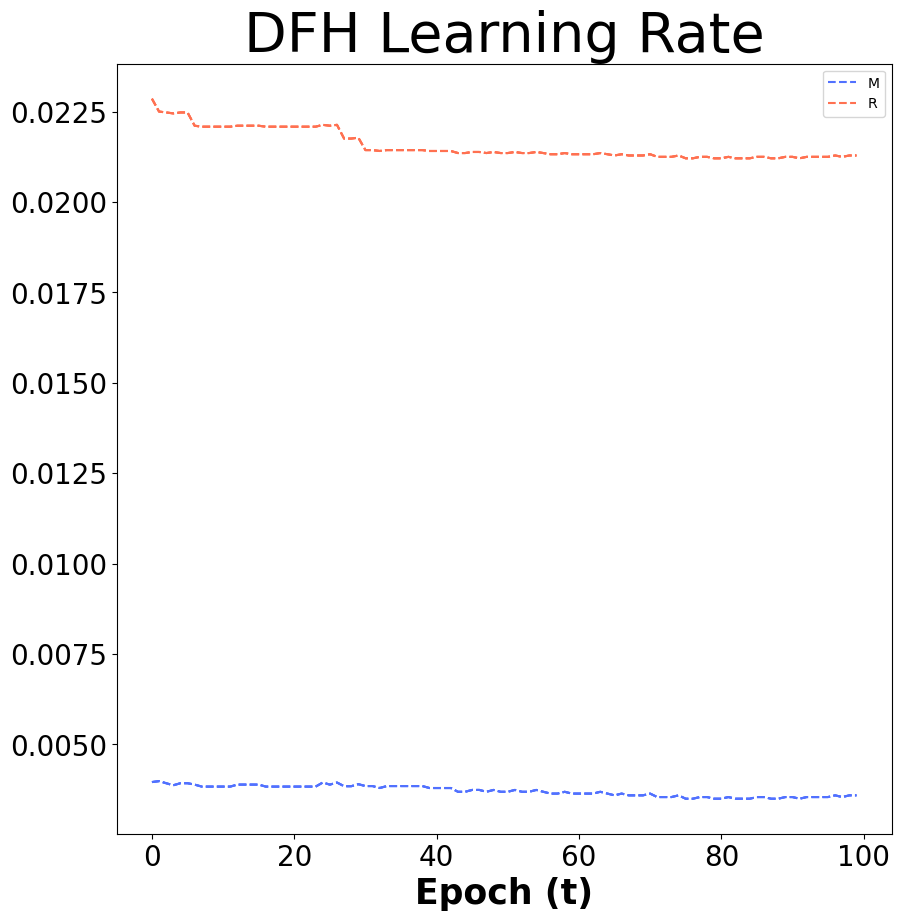

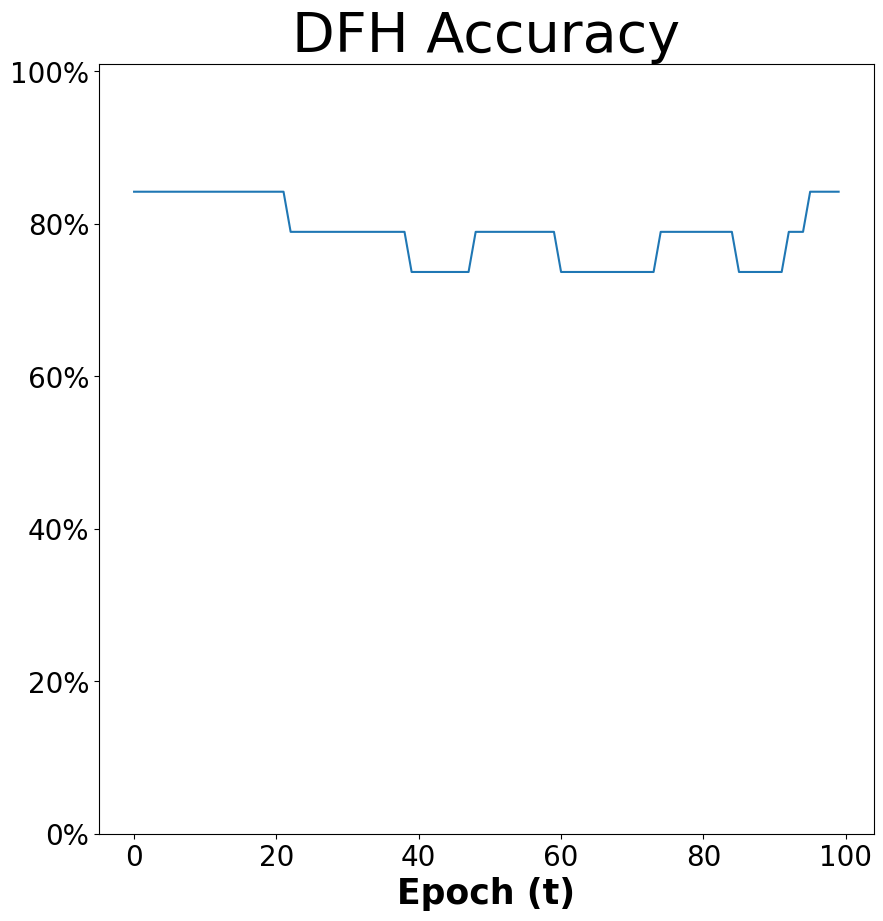

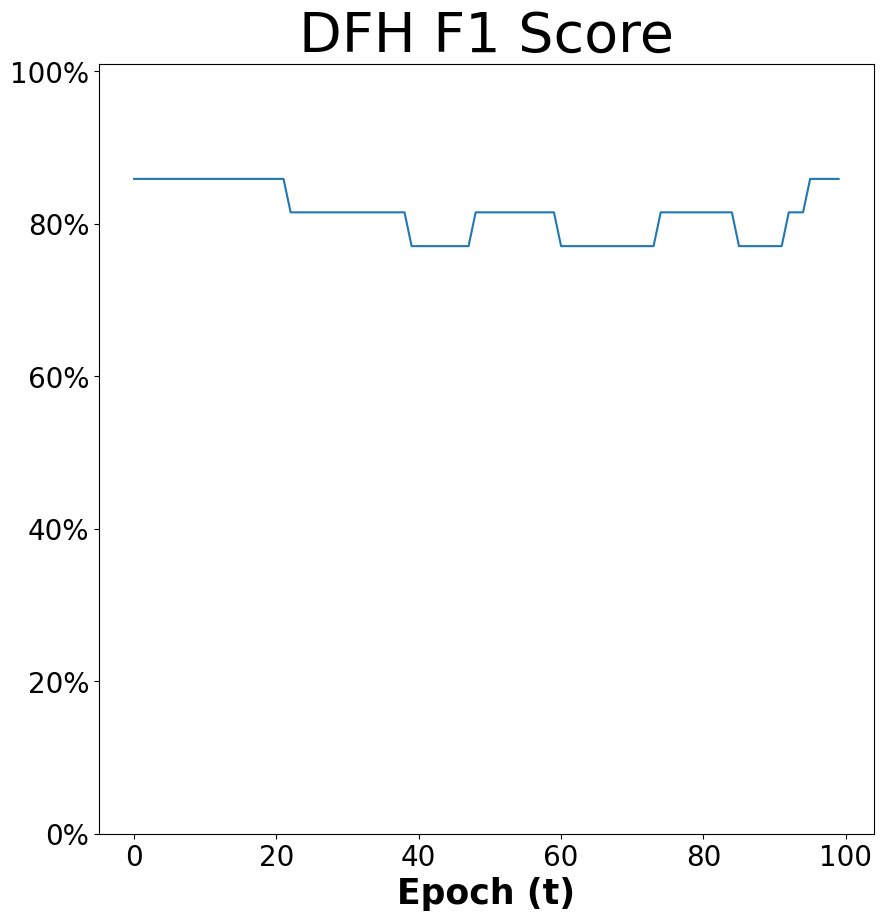

In [67]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### 3-step lr = 0.01

In [68]:
learning_rate = 0.01
dfh_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = dfh_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.dual_factor_heuristic,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4768, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4757, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4748, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4740, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 41, Loss: 0.4730, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 51, Loss: 0.4718, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 61, Loss: 0.4708, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 71, Loss: 0.4699, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 81, Loss: 0.4688, Accuracy: 78.95 %, F_1_score: 81.51 %
Epoch: 91, Loss: 0.4677, Accuracy: 78.95 %, F_1_score: 81.51 %


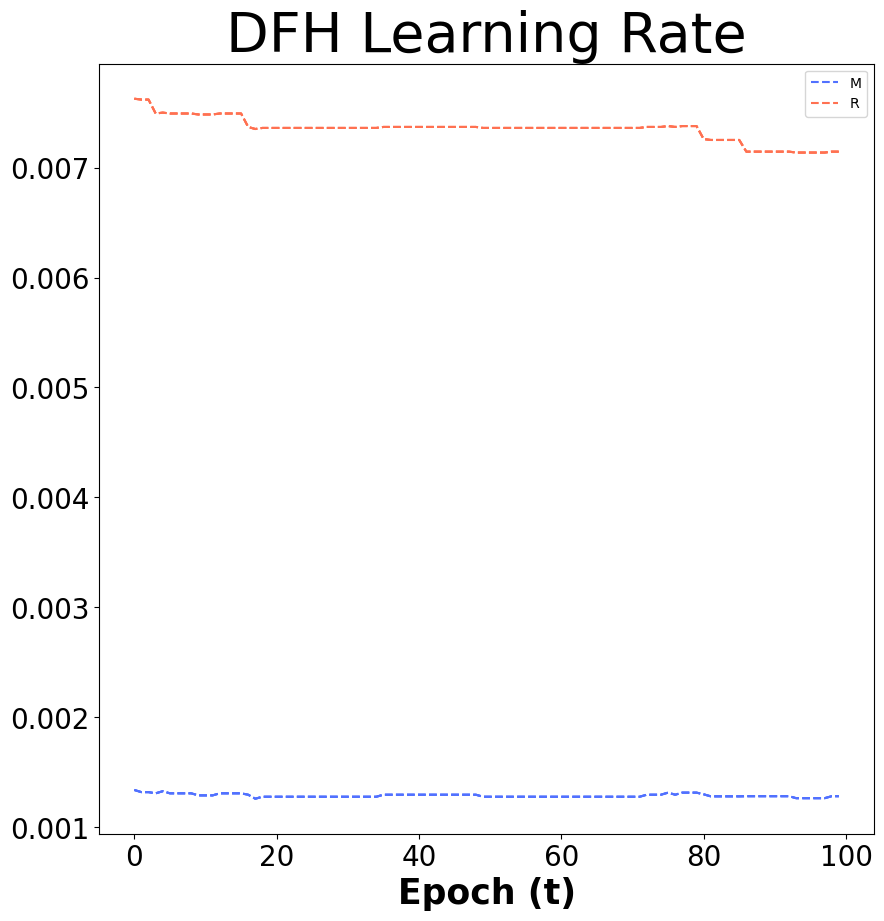

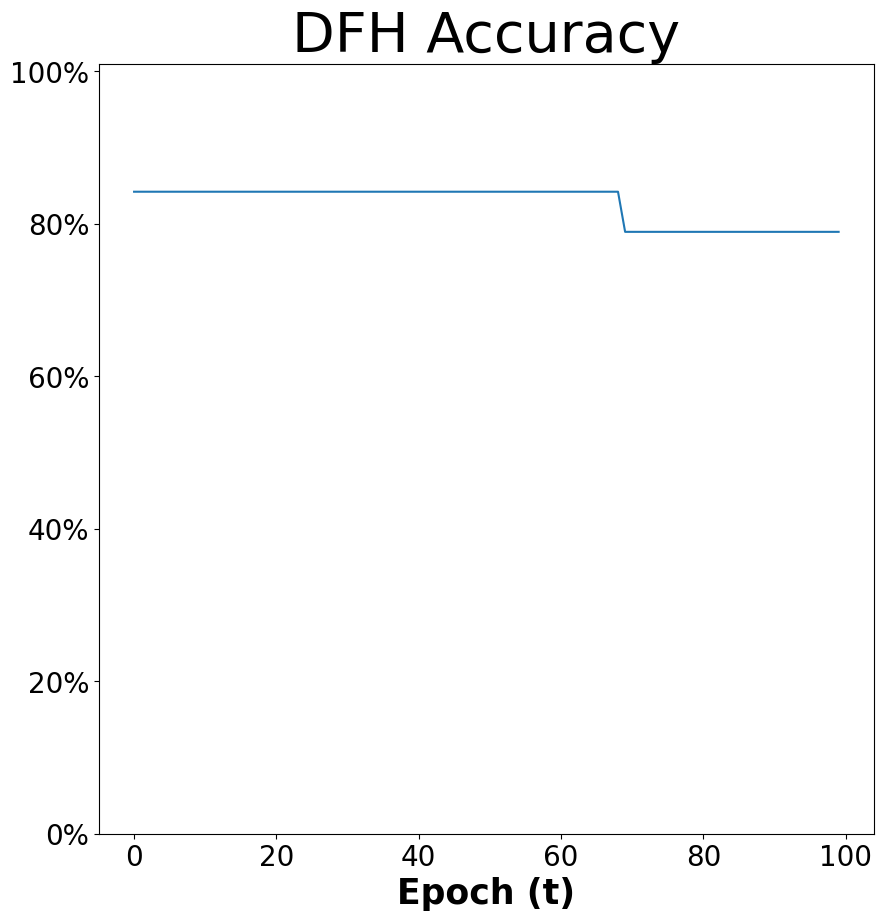

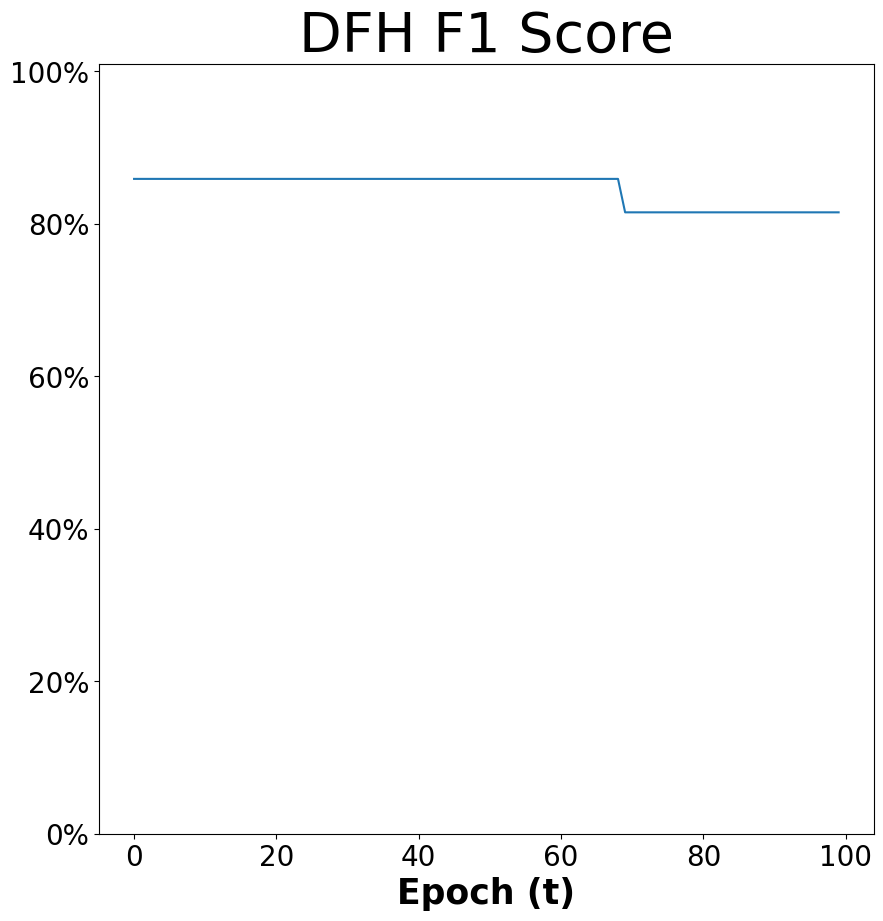

In [69]:
save_figs(dfh_glvq_fscore, experiment, "DFH", learning_rate)

##### MS

##### 1-step lr = 0.1

In [70]:
learning_rate = 0.1
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4753, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4442, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 21, Loss: 0.4316, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 31, Loss: 0.4251, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 41, Loss: 0.4215, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 51, Loss: 0.4196, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 61, Loss: 0.4180, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 71, Loss: 0.4174, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 81, Loss: 0.4173, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 91, Loss: 0.4175, Accuracy: 84.21 %, F_1_score: 84.89 %


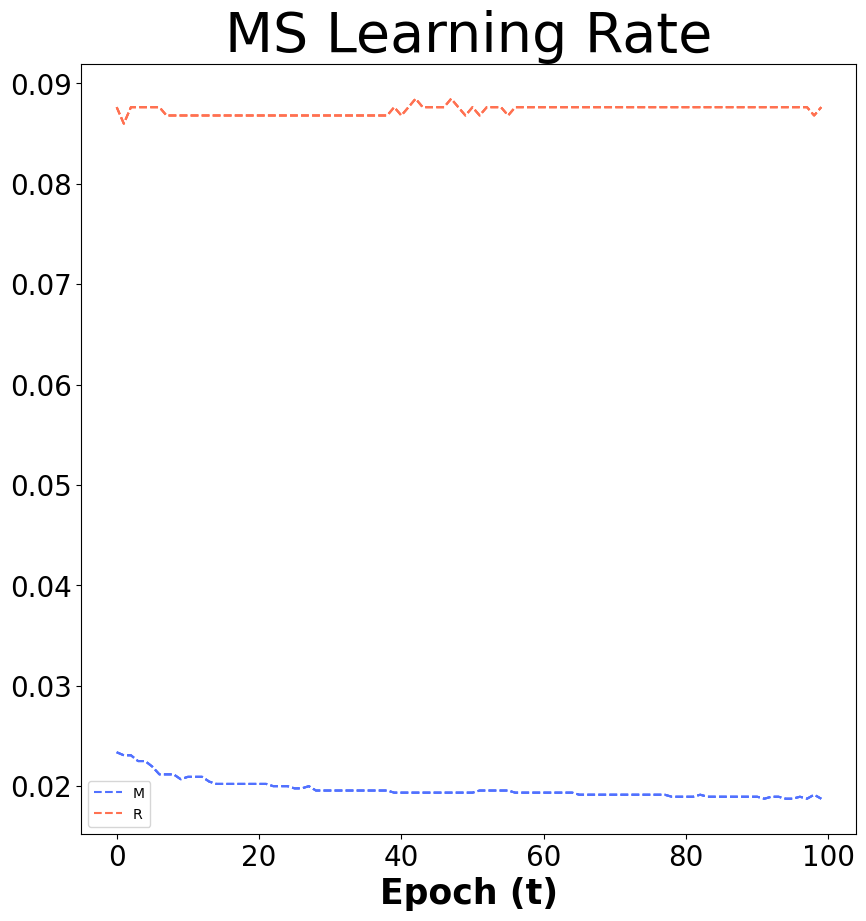

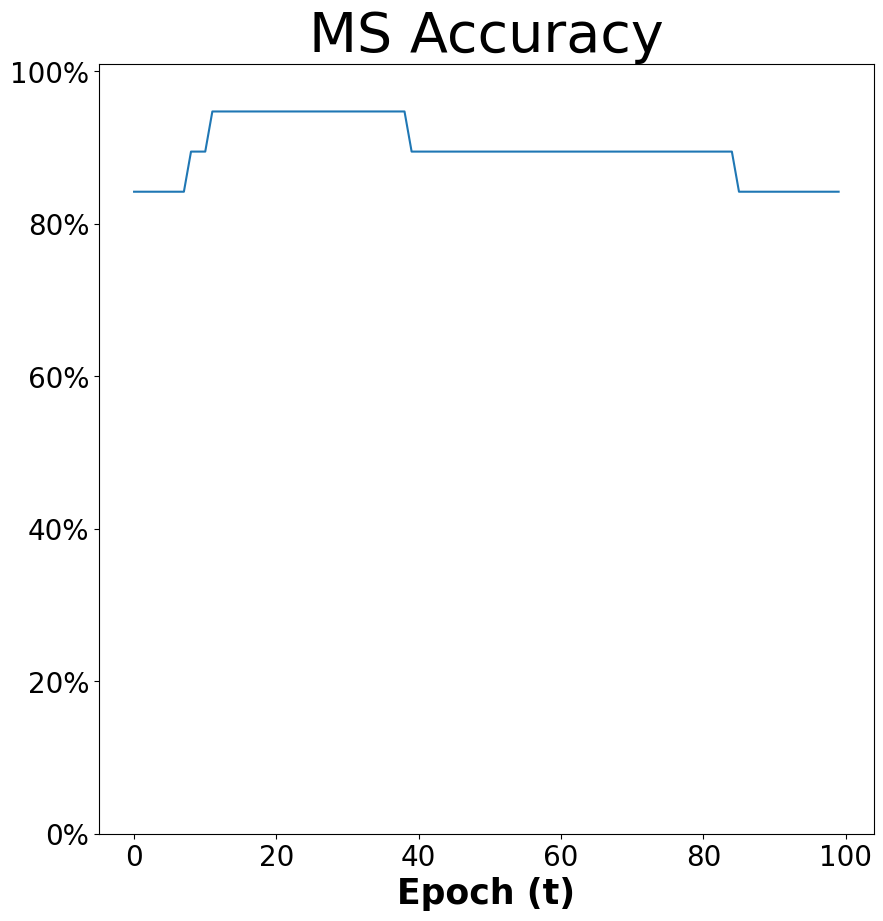

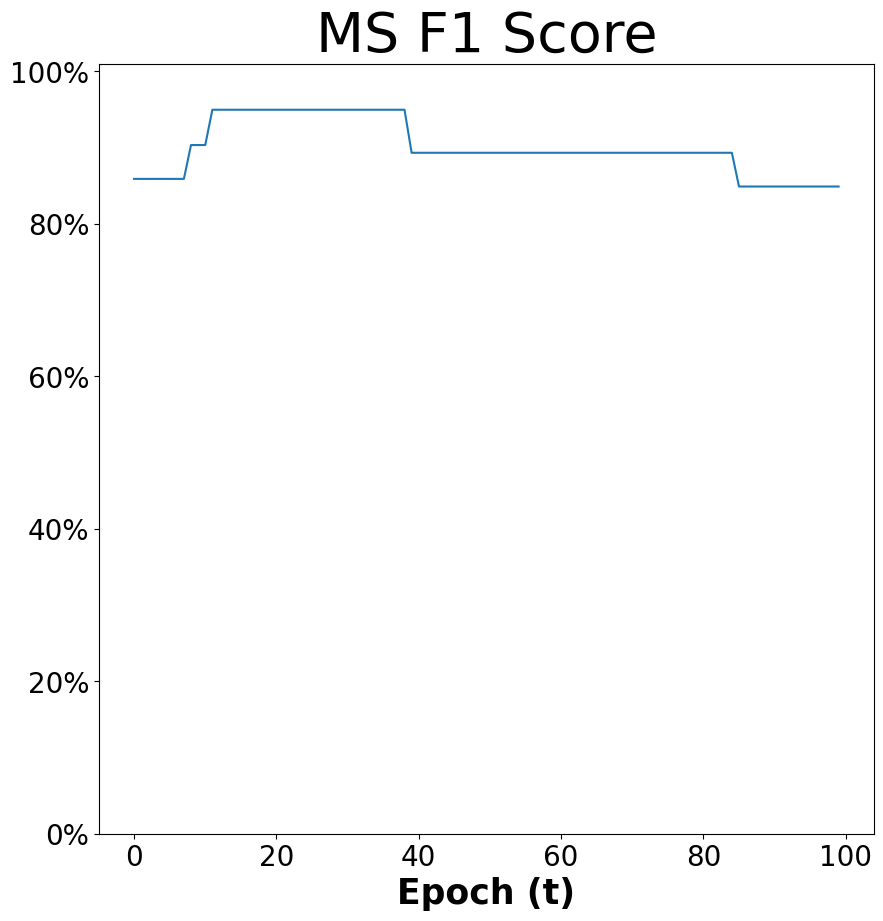

In [71]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 2-step lr = 0.03

In [72]:
learning_rate = 0.03
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4763, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4627, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4532, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4461, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 41, Loss: 0.4405, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 51, Loss: 0.4364, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 61, Loss: 0.4331, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 71, Loss: 0.4304, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 81, Loss: 0.4279, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 91, Loss: 0.4260, Accuracy: 94.74 %, F_1_score: 94.96 %


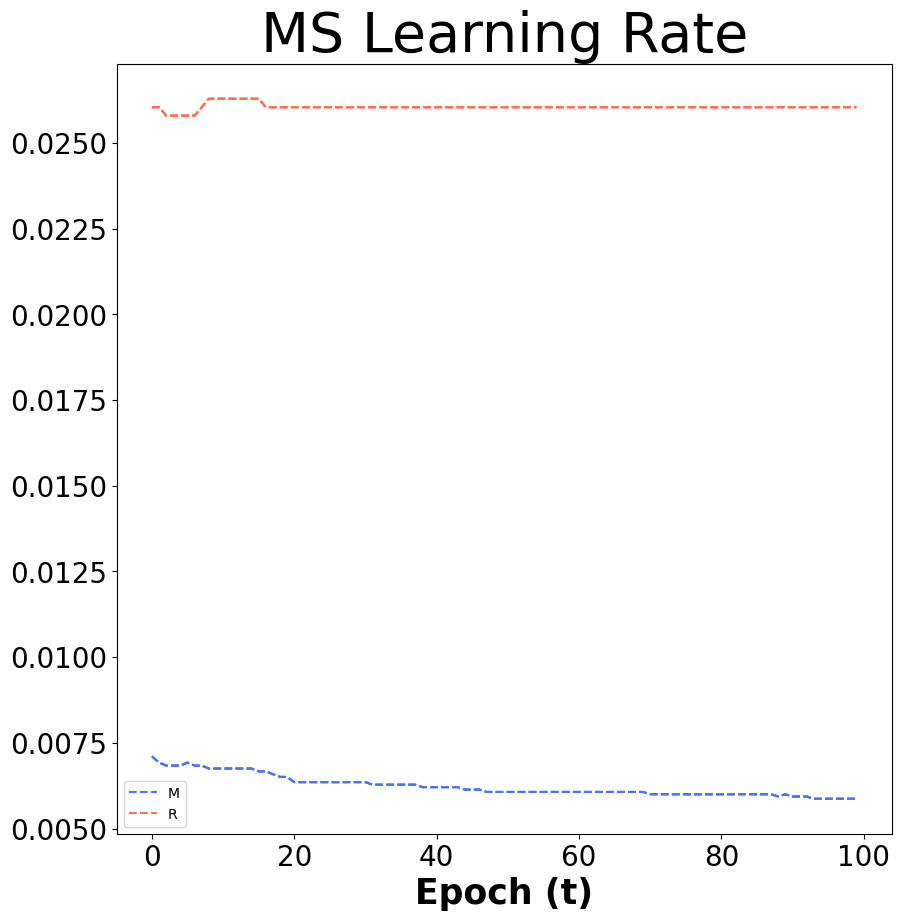

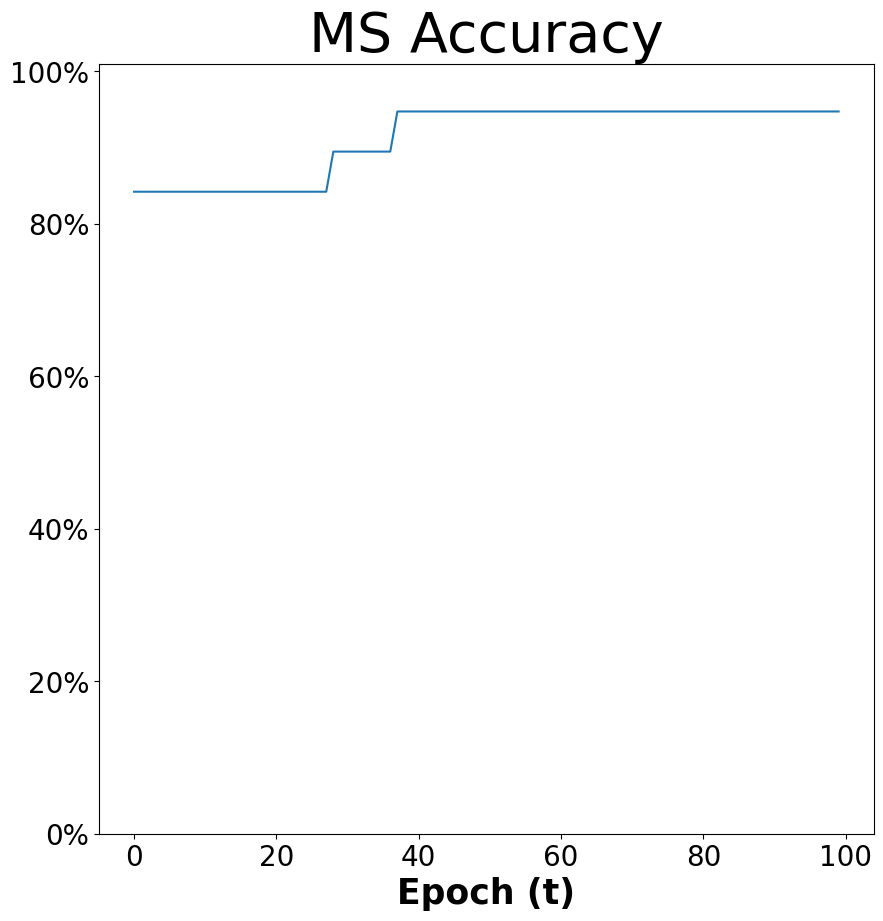

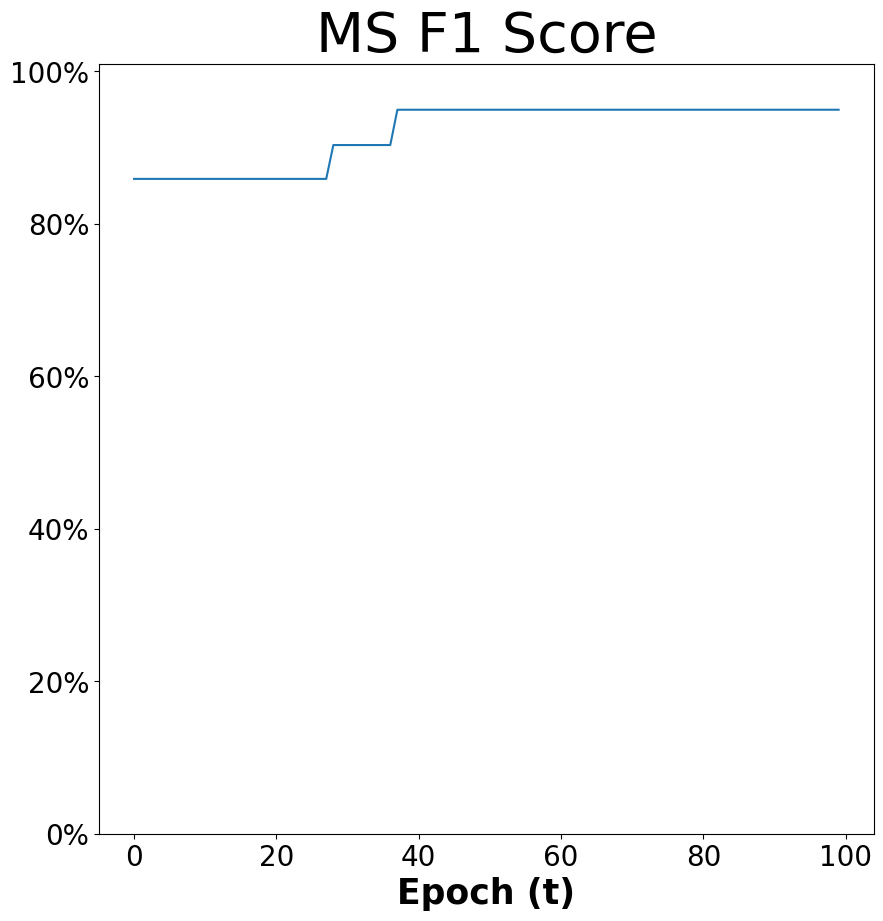

In [73]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### 3-step lr = 0.01

In [74]:
learning_rate = 0.01
ms_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ms_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.middle_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4766, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4715, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4669, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4629, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 41, Loss: 0.4594, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 51, Loss: 0.4562, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 61, Loss: 0.4533, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 71, Loss: 0.4506, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 81, Loss: 0.4483, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 91, Loss: 0.4462, Accuracy: 89.47 %, F_1_score: 90.33 %


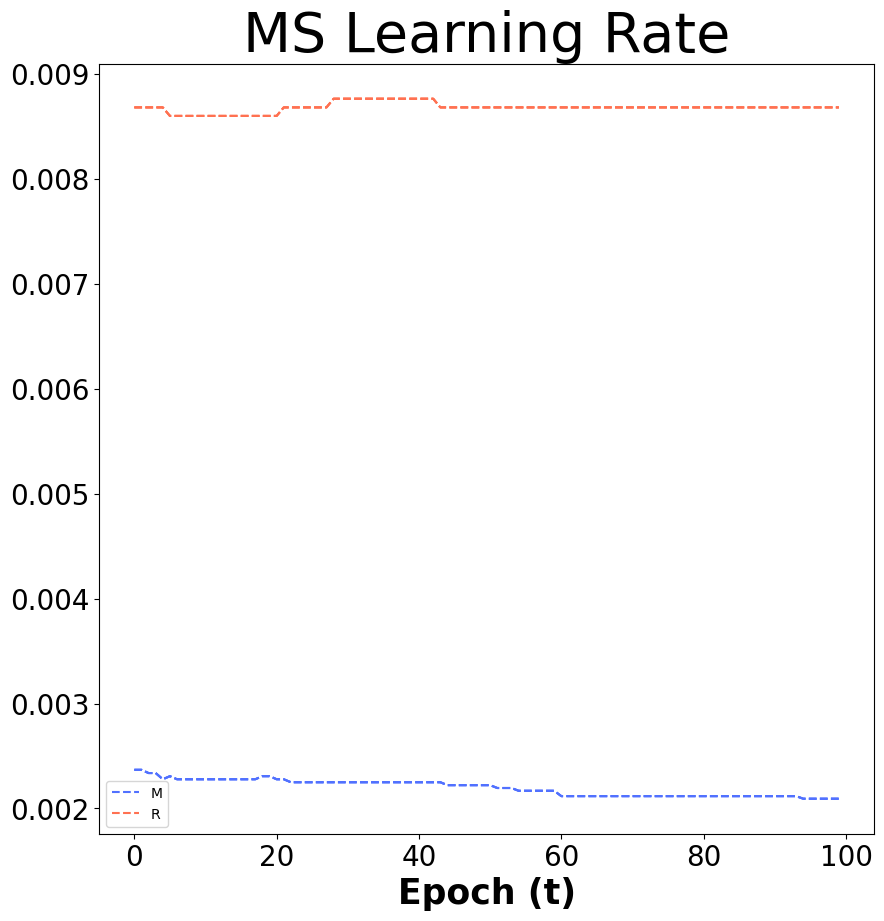

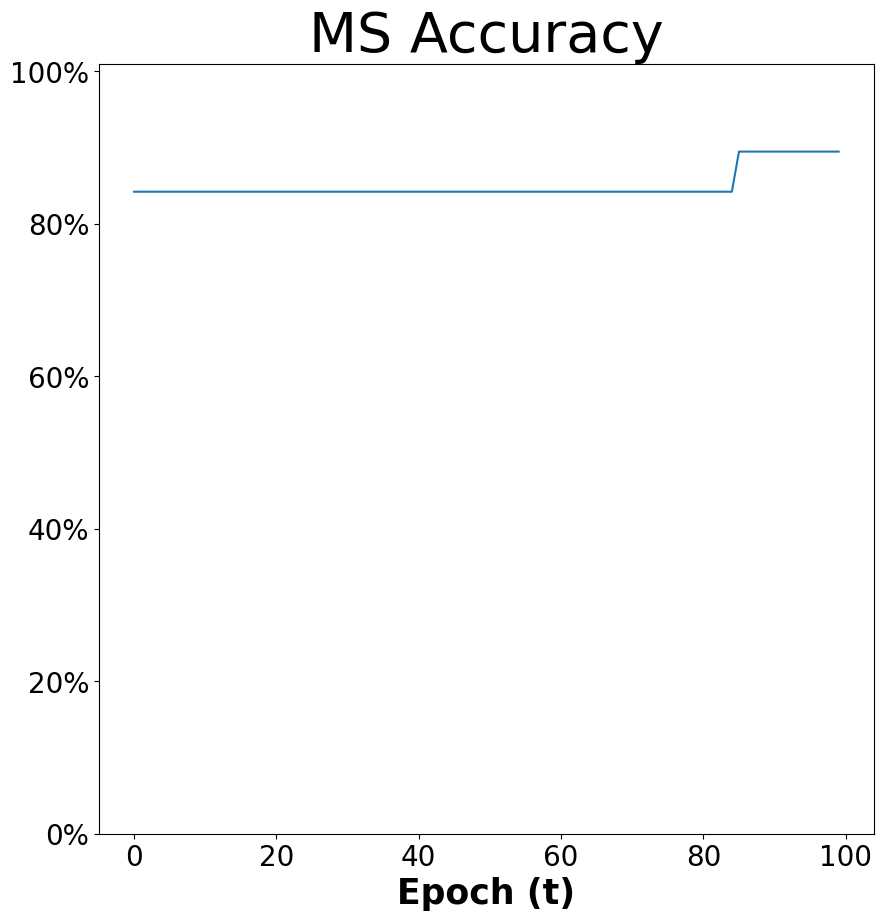

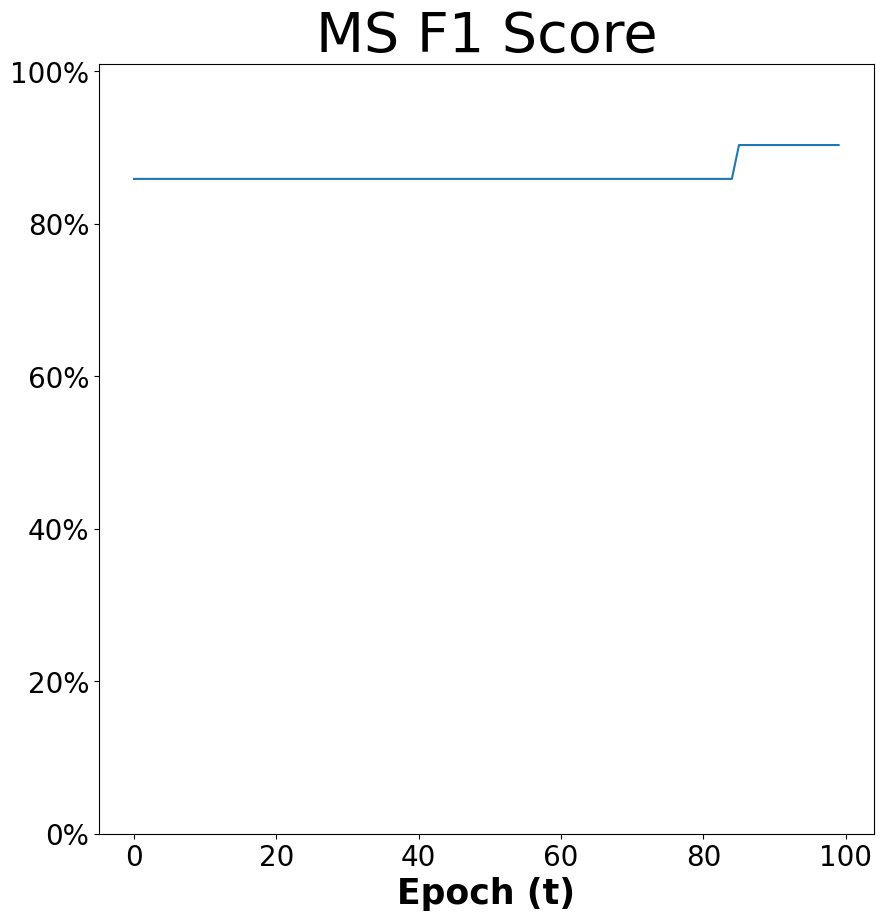

In [75]:
save_figs(ms_glvq_fscore, experiment, "MS", learning_rate)

##### LS

##### 1-step lr = 0.1

In [76]:
learning_rate = 0.1
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4752, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4406, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.4251, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 31, Loss: 0.4171, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 41, Loss: 0.4120, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 51, Loss: 0.4092, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 61, Loss: 0.4069, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 71, Loss: 0.4052, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 81, Loss: 0.4037, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 91, Loss: 0.4024, Accuracy: 89.47 %, F_1_score: 89.32 %


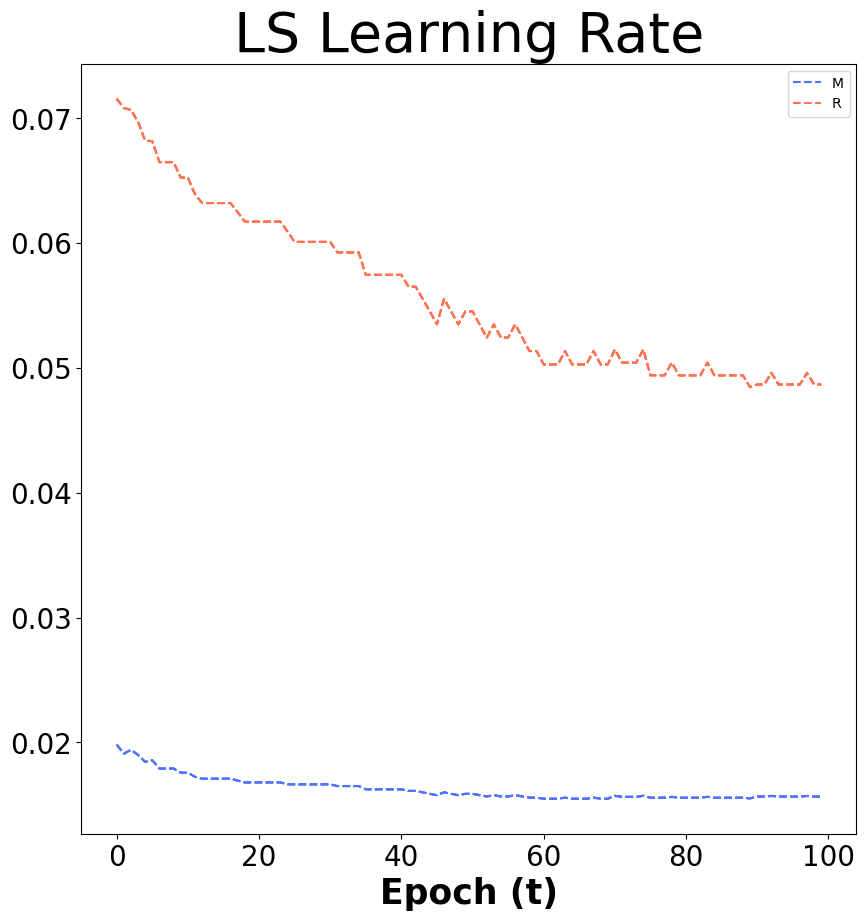

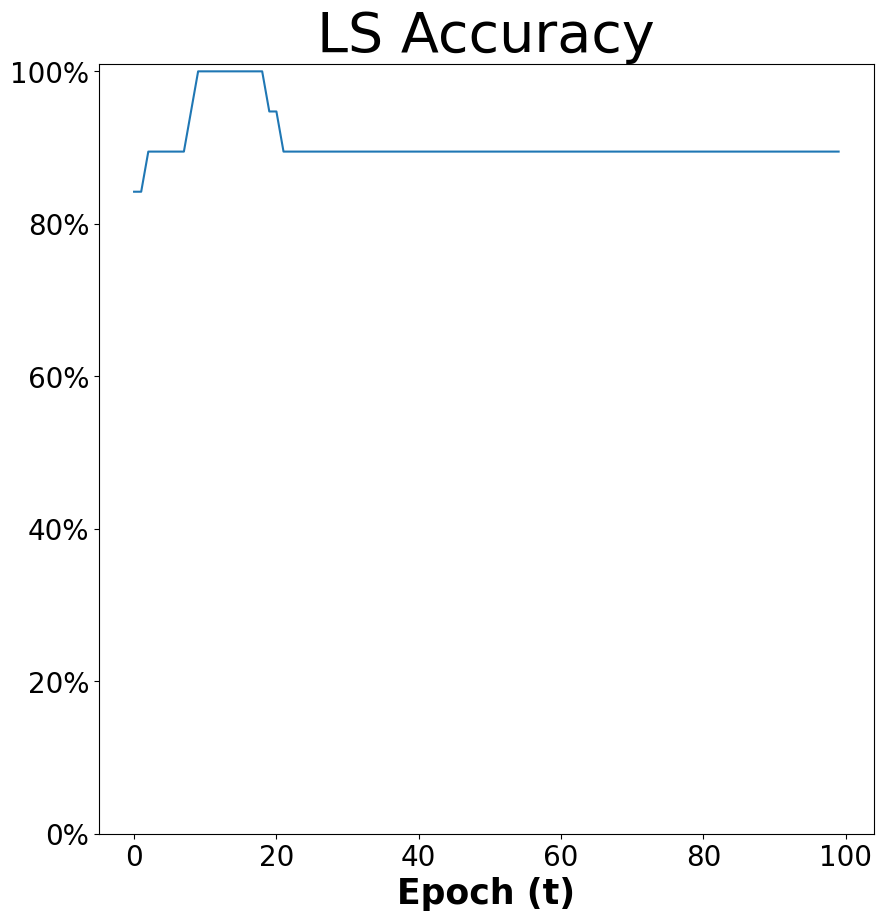

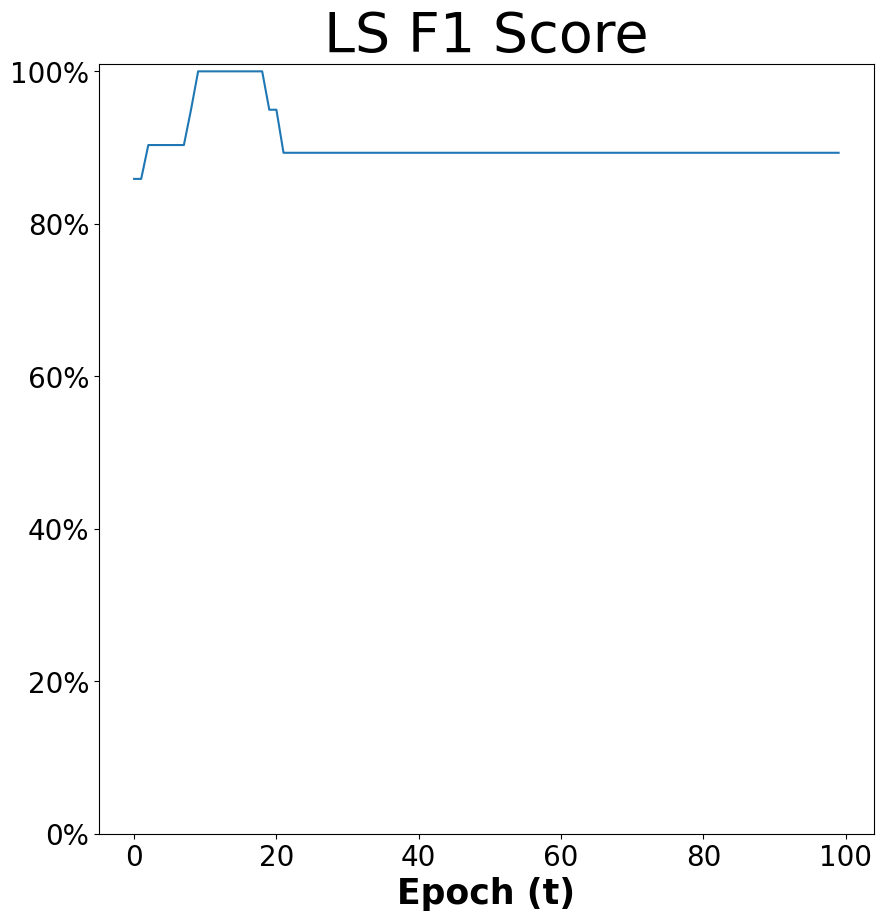

In [77]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 2-step lr = 0.03

In [78]:
learning_rate = 0.03
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4762, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4626, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4517, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 31, Loss: 0.4434, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 41, Loss: 0.4368, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 51, Loss: 0.4316, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 61, Loss: 0.4274, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 71, Loss: 0.4241, Accuracy: 94.74 %, F_1_score: 94.96 %
Epoch: 81, Loss: 0.4213, Accuracy: 89.47 %, F_1_score: 89.32 %
Epoch: 91, Loss: 0.4190, Accuracy: 89.47 %, F_1_score: 89.32 %


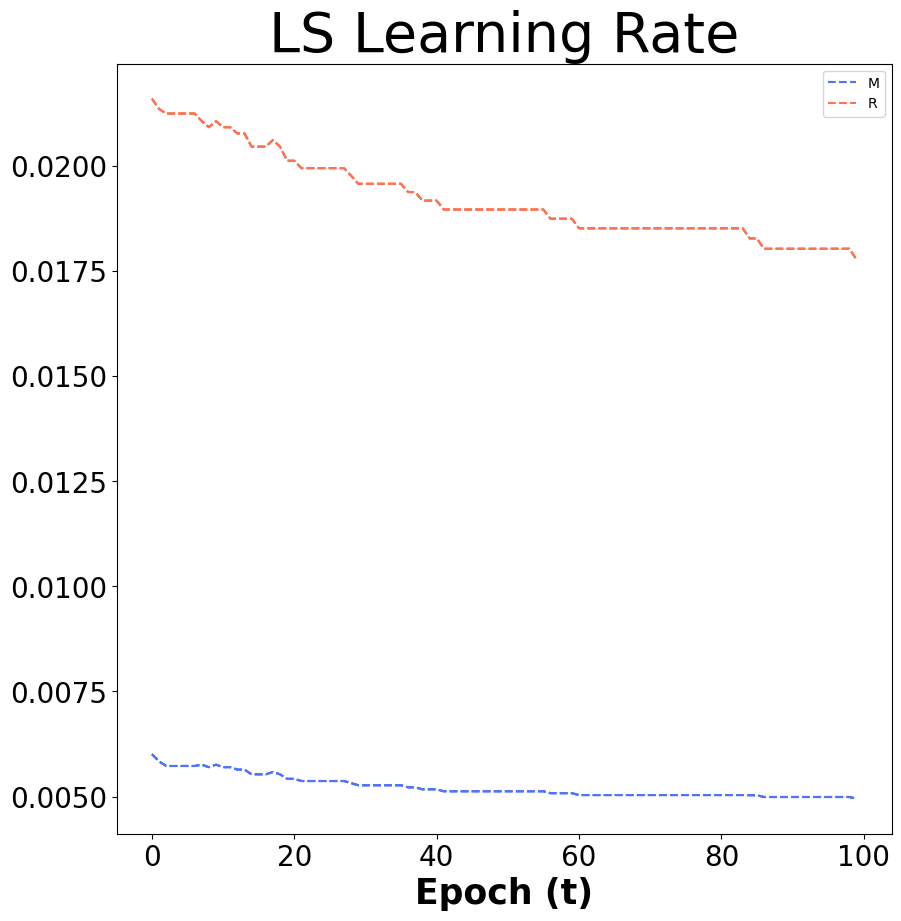

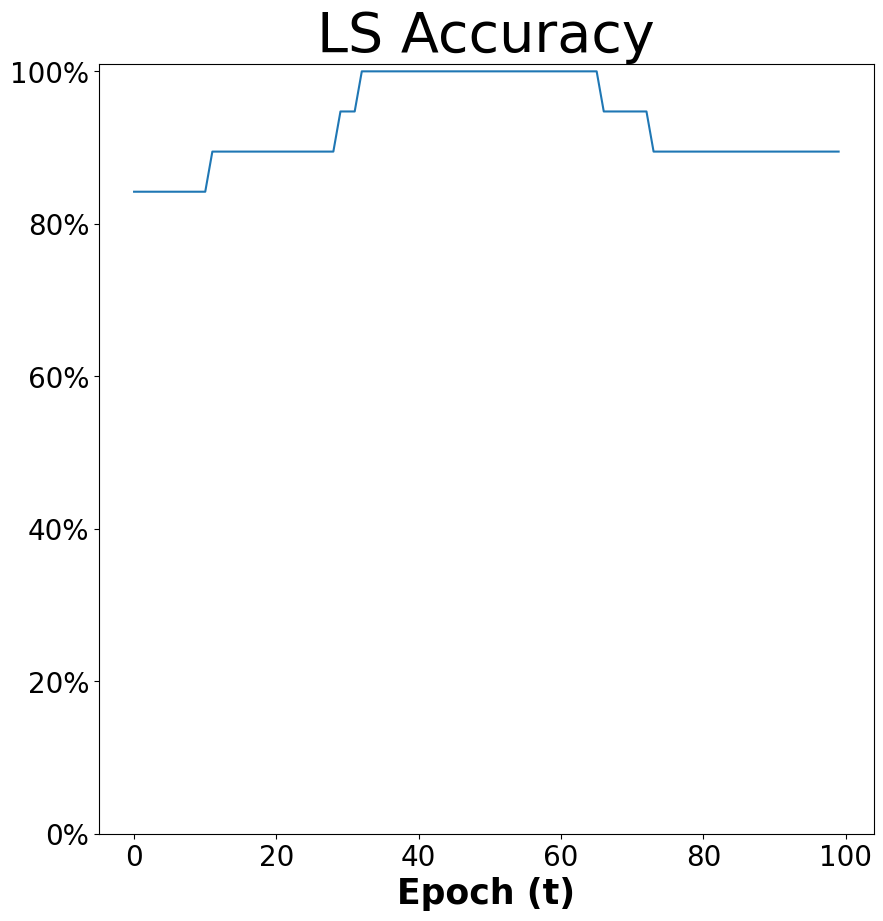

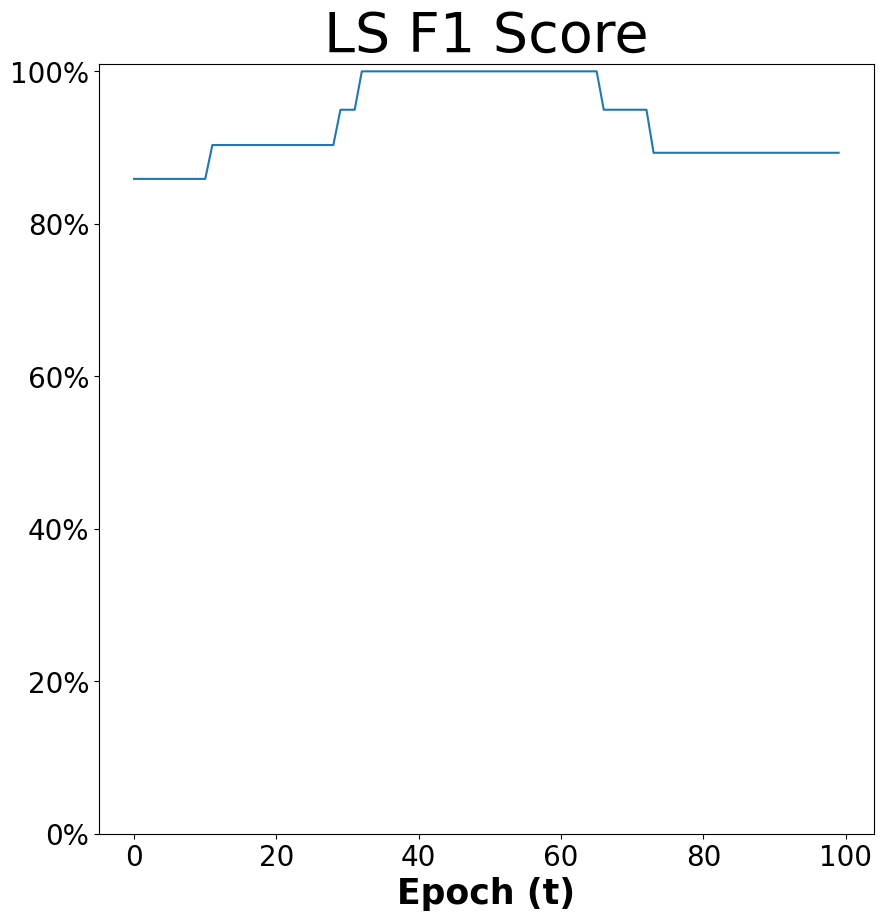

In [79]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### 3-step lr = 0.01

In [80]:
learning_rate = 0.01
ls_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = ls_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4766, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4717, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 21, Loss: 0.4671, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 31, Loss: 0.4628, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 41, Loss: 0.4588, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 51, Loss: 0.4552, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 61, Loss: 0.4519, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 71, Loss: 0.4489, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 81, Loss: 0.4461, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 91, Loss: 0.4435, Accuracy: 94.74 %, F_1_score: 94.96 %


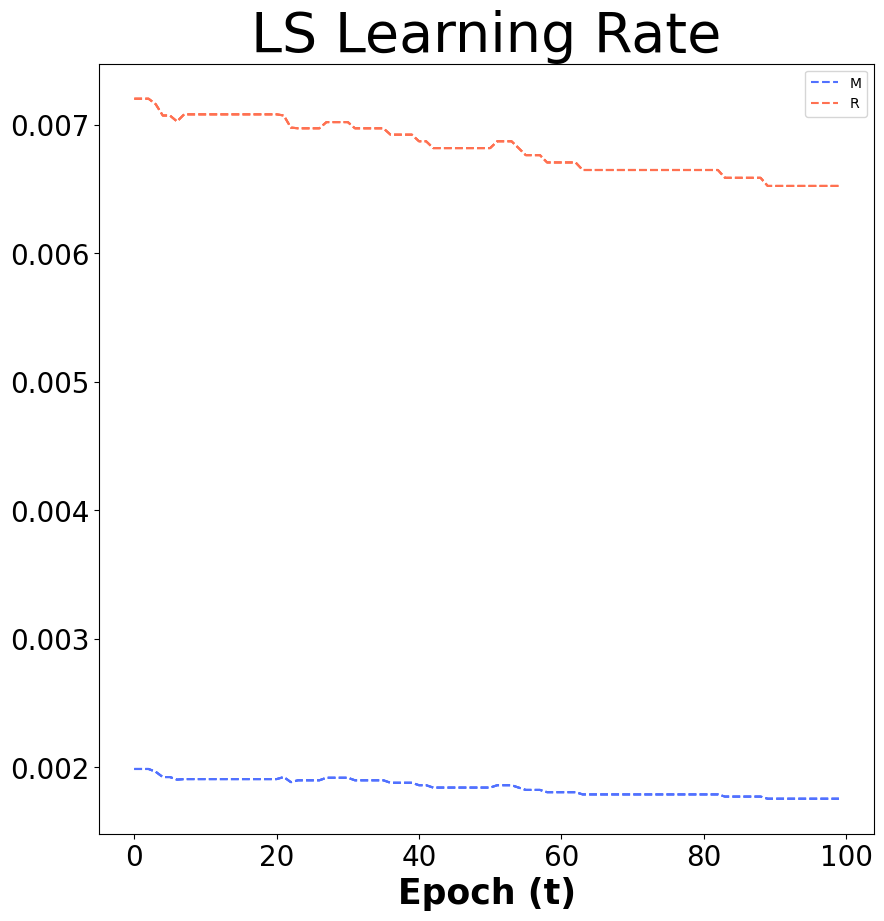

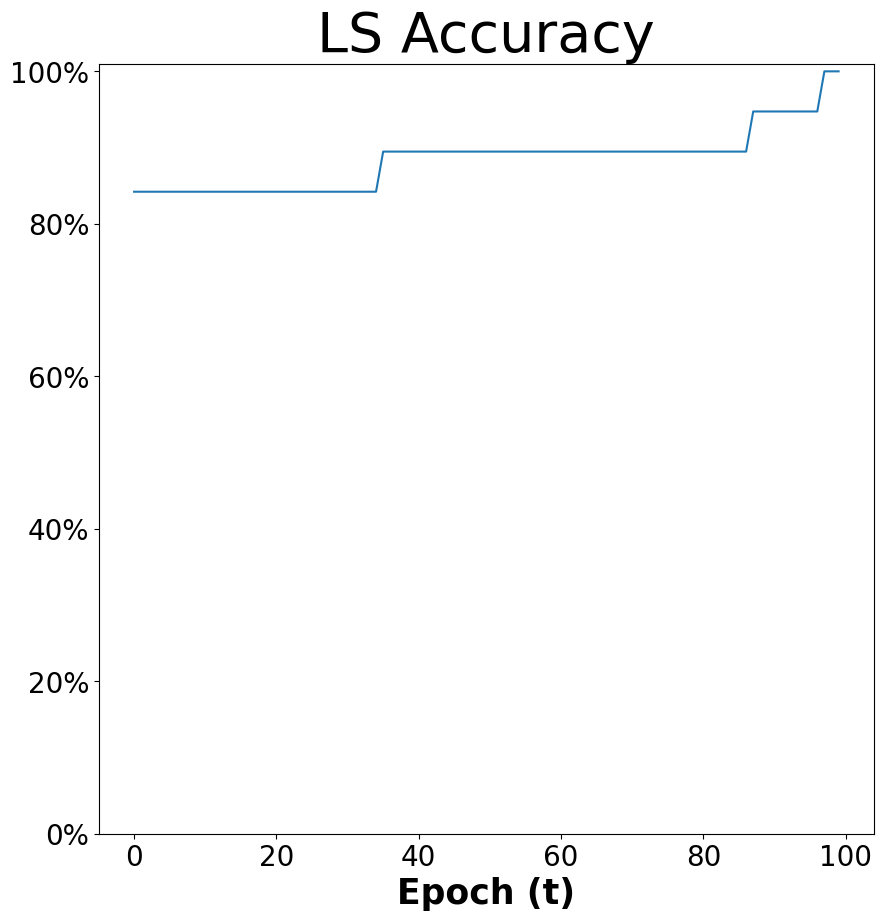

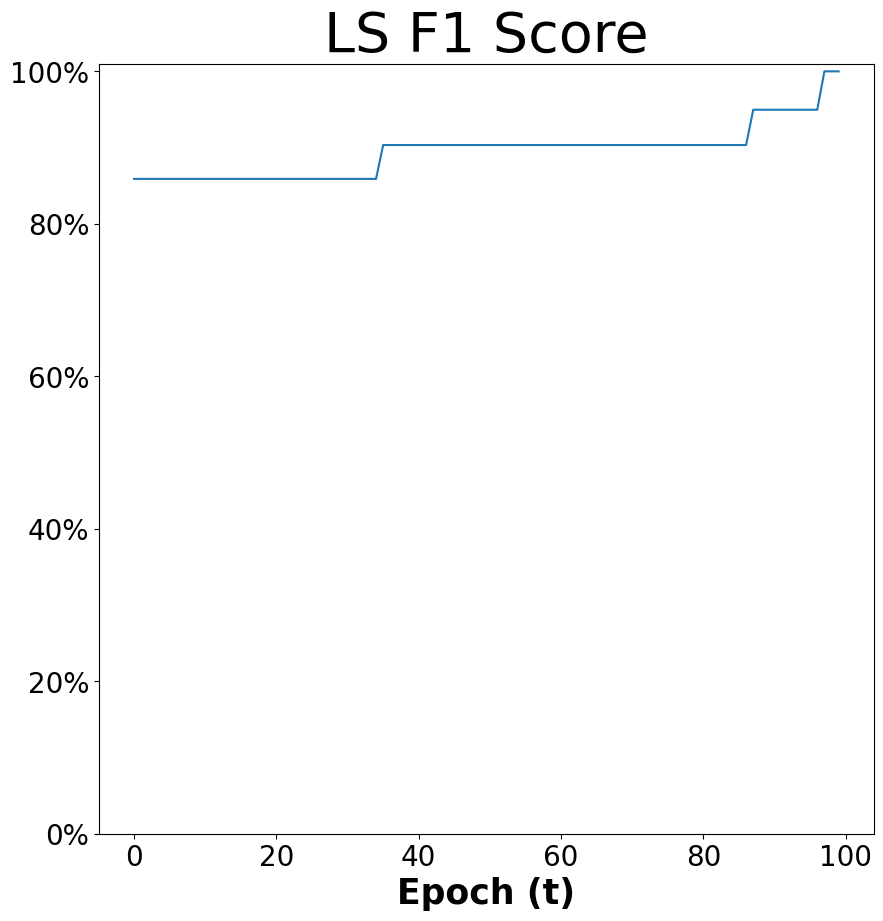

In [81]:
save_figs(ls_glvq_fscore, experiment, "LS", learning_rate)

##### LSR

##### 1-step lr = 0.1

In [82]:
learning_rate = 0.1
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4743, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4333, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 21, Loss: 0.4178, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 31, Loss: 0.4114, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 41, Loss: 0.4083, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 51, Loss: 0.4064, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 61, Loss: 0.4045, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 71, Loss: 0.4030, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 81, Loss: 0.4023, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 91, Loss: 0.4020, Accuracy: 89.47 %, F_1_score: 86.90 %


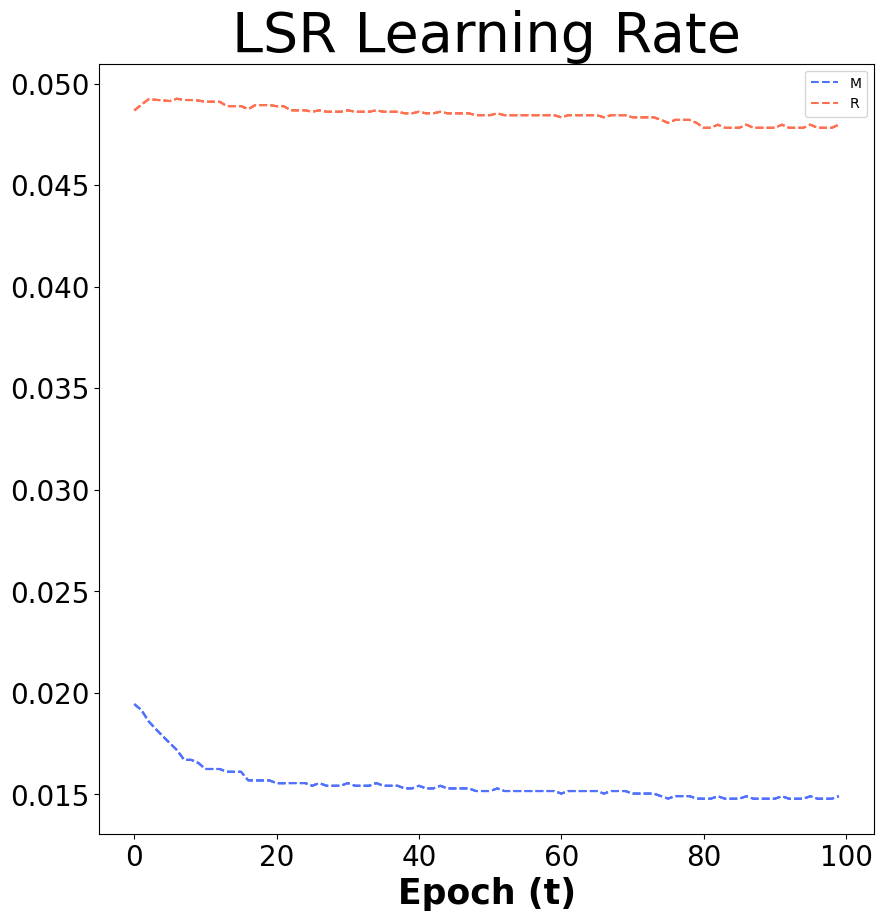

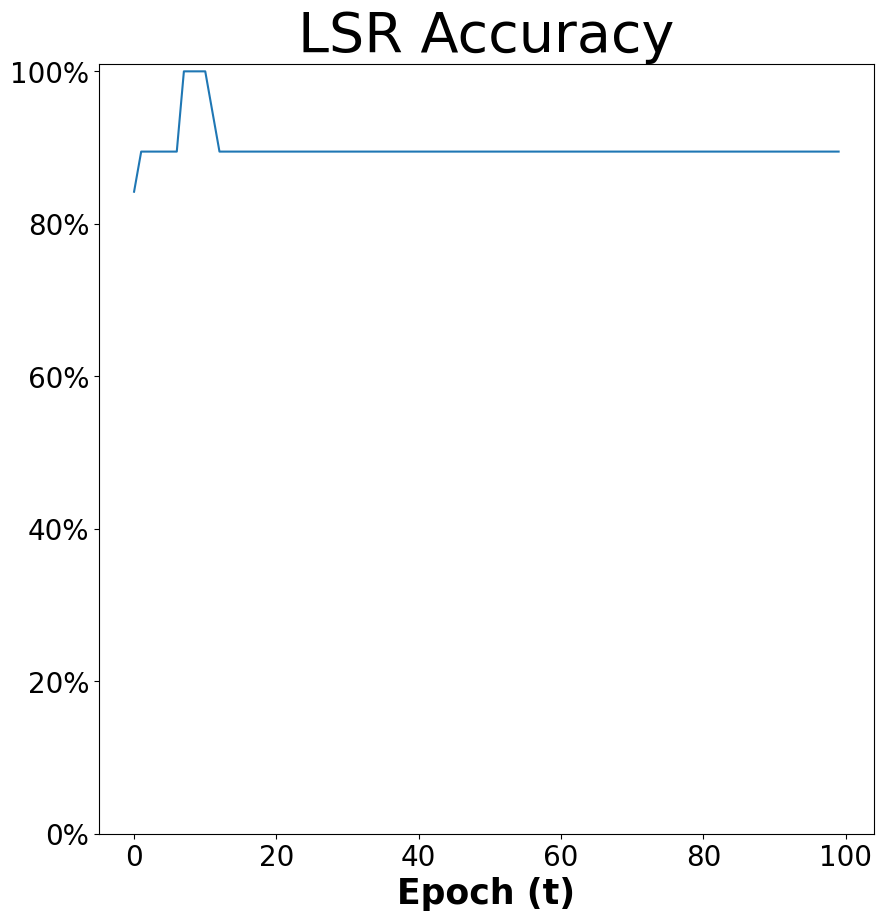

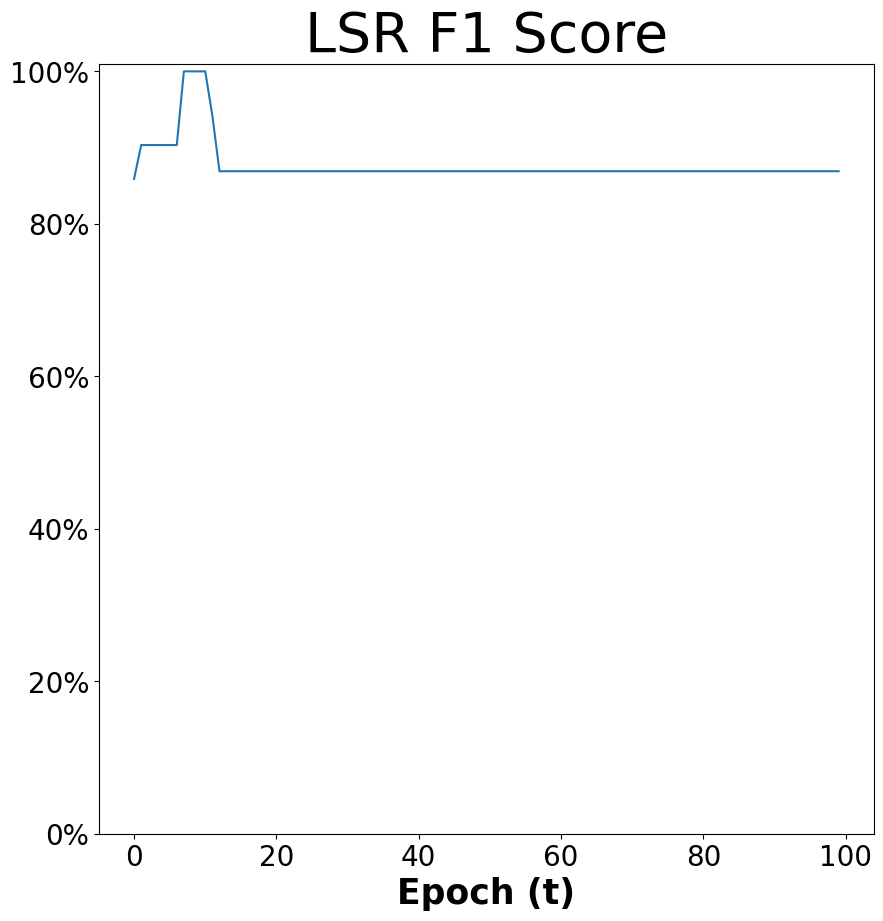

In [83]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 2-step lr = 0.03

In [84]:
learning_rate = 0.03
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4760, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4587, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 21, Loss: 0.4459, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 31, Loss: 0.4364, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 41, Loss: 0.4296, Accuracy: 94.74 %, F_1_score: 94.19 %
Epoch: 51, Loss: 0.4243, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 61, Loss: 0.4202, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 71, Loss: 0.4170, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 81, Loss: 0.4143, Accuracy: 89.47 %, F_1_score: 86.90 %
Epoch: 91, Loss: 0.4128, Accuracy: 89.47 %, F_1_score: 86.90 %


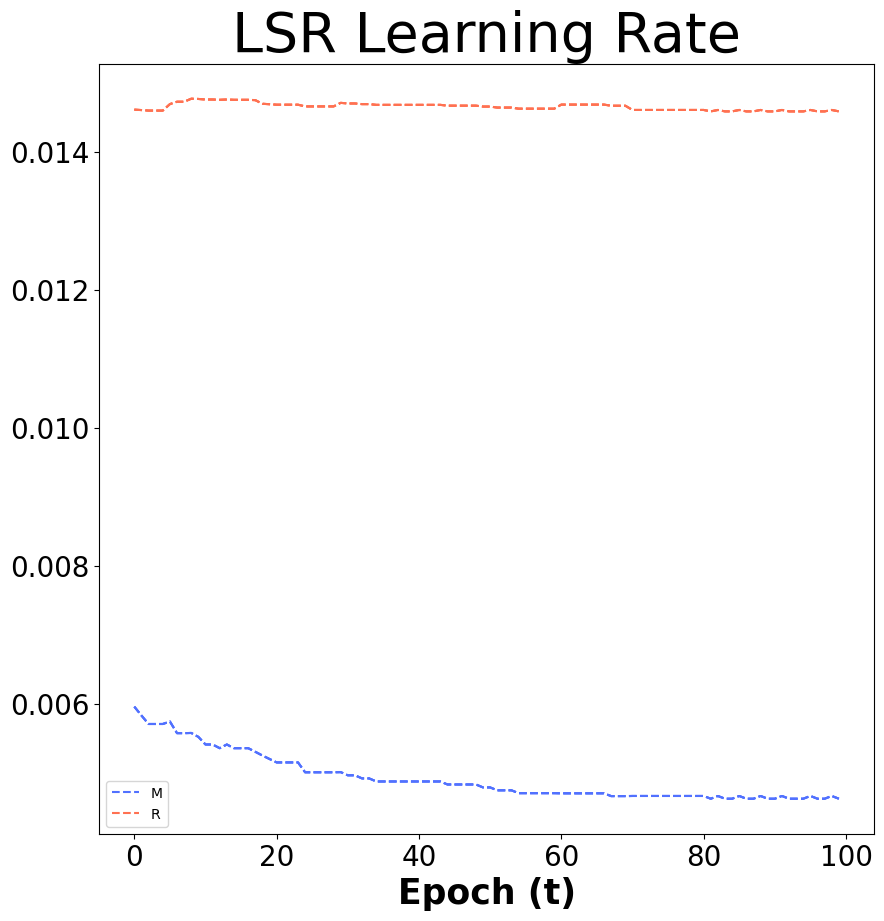

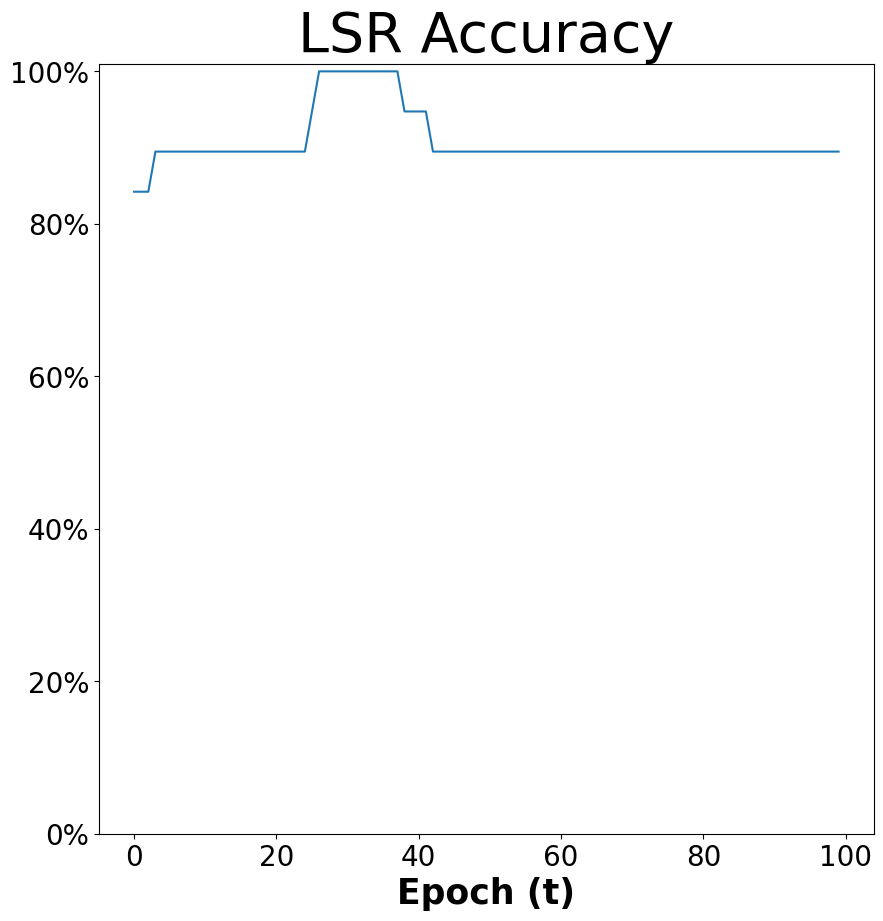

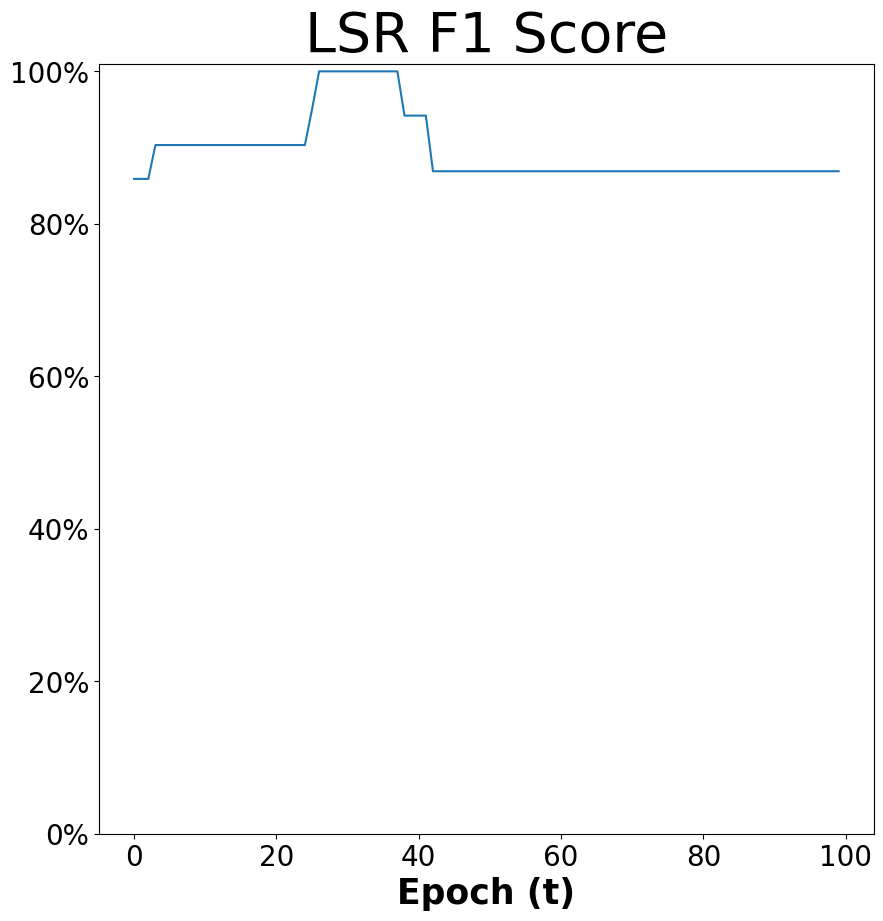

In [85]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)

##### 3-step lr = 0.01

In [86]:
learning_rate = 0.01
lsr_glvq_fscore = cglvq.CGLVQ(prototypes, learning_rate)
hist = lsr_glvq_fscore.train(
    num_epochs,
    train_set_fscore,
    test_set_fscore,
    opt.loose_symmetry_rarity,
    sample_number=train_dist,
)


Epoch: 1, Loss: 0.4765, Accuracy: 84.21 %, F_1_score: 85.89 %
Epoch: 11, Loss: 0.4702, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 21, Loss: 0.4644, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 31, Loss: 0.4592, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 41, Loss: 0.4543, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 51, Loss: 0.4500, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 61, Loss: 0.4462, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 71, Loss: 0.4427, Accuracy: 89.47 %, F_1_score: 90.33 %
Epoch: 81, Loss: 0.4396, Accuracy: 100.00 %, F_1_score: 100.00 %
Epoch: 91, Loss: 0.4367, Accuracy: 100.00 %, F_1_score: 100.00 %


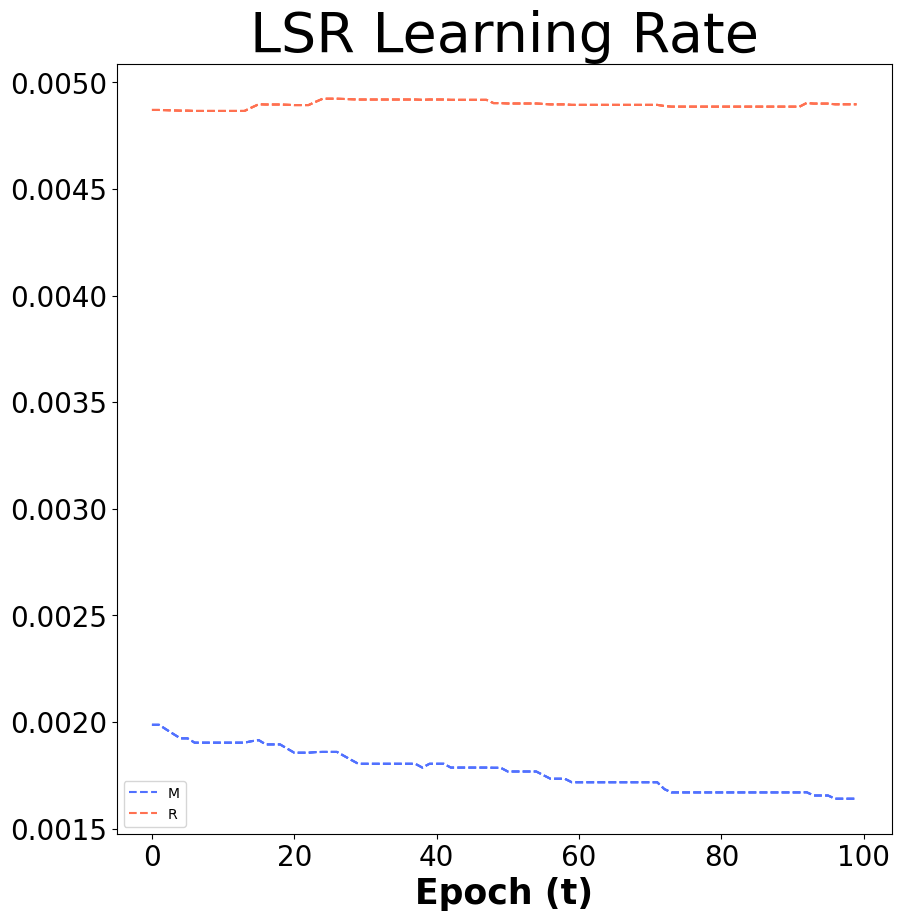

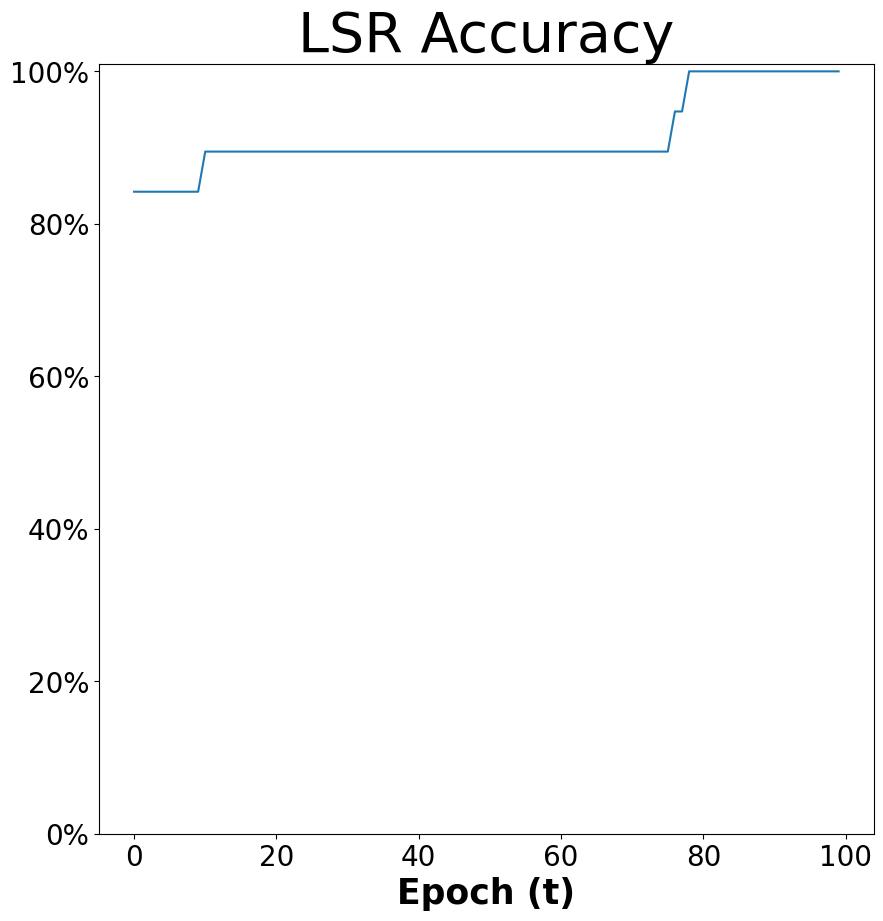

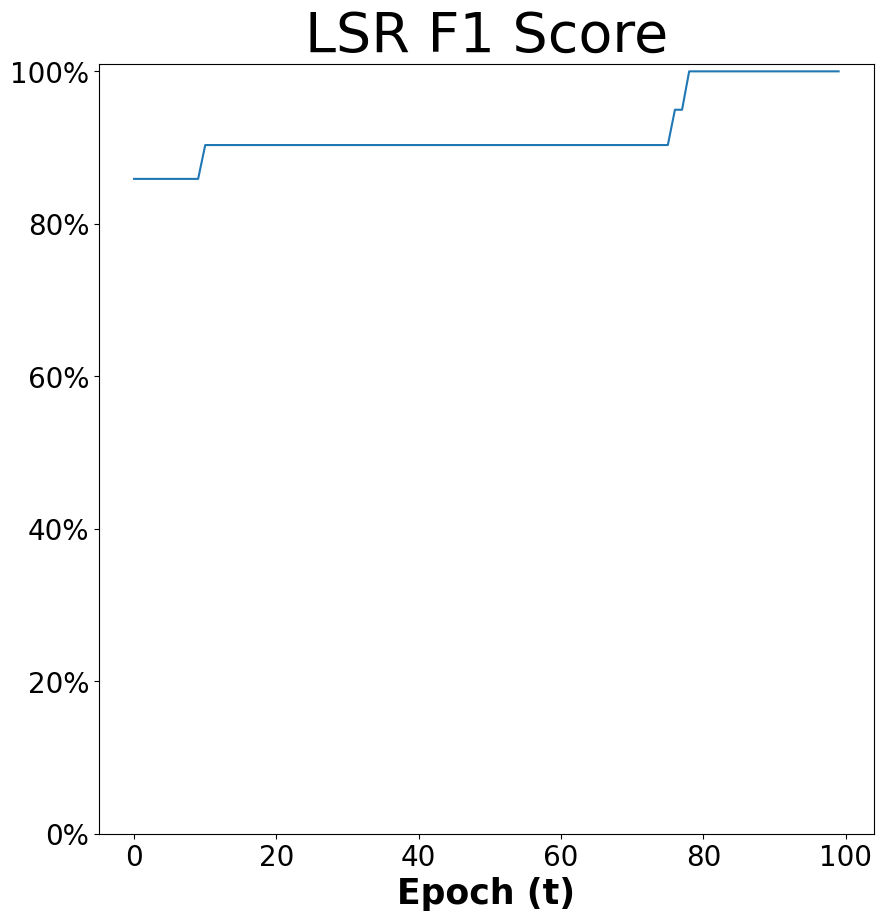

In [87]:
save_figs(lsr_glvq_fscore, experiment, "LSR", learning_rate)